In [72]:
!pip install beautifulsoup4
!pip install requests
!pip install pandas
!pip install tqdm
!pip install scikit-learn
!pip install matplotlib
!pip install seaborn
!pip install urllib3

In [73]:
# ÏöîÏïΩÎ≥¥Í∏∞
pd.set_option('display.max_rows', 100)

In [132]:
#Ï†ÑÏ≤¥Ìñâ Î≥¥Í∏∞ 
pd.set_option('display.max_rows', None)

In [197]:
%matplotlib inline
plt.rcParams['font.family'] = 'AppleGothic' # macOS ÏÇ¨Ïö©Ïûê
plt.rcParams['axes.unicode_minus'] = False

In [75]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from tqdm import tqdm
import re
from datetime import datetime, timedelta
import zipfile
import io
import xml.etree.ElementTree as ET
from concurrent.futures import ThreadPoolExecutor, as_completed
from datetime import datetime, timedelta
import pandas as pd
from tqdm import tqdm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.contrib.concurrent import thread_map

# ÏàòÏùµÎ•† ÏÉÅÏúÑ Í∏∞Ï§Ä Ìà¨Ïûê Ï†ÑÎûµ ÏàòÎ¶Ω

## 1. ÌõÑÎ≥¥Íµ∞ ÏÑ†Ï†ï
### 1) ÏÑ†Ï†ïÍ∏∞Ï§Ä
- Ï†ÑÏ≤¥ ÏÉÅÏû• Ï¢ÖÎ™©(ÏΩîÏä§Ìîº + ÏΩîÏä§Îã•) Ï§ë ÏàòÏùµÎ•†(24ÎÖÑ 1Ïõî ~ 24ÎÖÑ 12Ïõî) ÏÉÅÏúÑ 00% Ï∂îÏ∂ú
- Ï§ëÏÜåÌòïÏ£º Ï§ë ÏµúÍ∑º 1ÎÖÑ ÏàòÏùµÎ•† ÏÉÅÏúÑ 100Í∞ú Ï∂îÏ∂ú

### 2) ÏàòÏùµÎ•†(24ÎÖÑ 1Ïõî ~ 24ÎÖÑ 12Ïõî) ÏÉÅÏúÑ 00% Ï∂îÏ∂ú
#### - ÌïúÍµ≠Í±∞ÎûòÏÜå APIÏóêÏÑú ÏãúÍ∞Ä Ï¥ùÏï° Í∏∞Ï§ÄÏúºÎ°ú ÌÅ¨Î°§ÎßÅ

In [5]:
def get_stock_info(basDd):
  url = {
  "kospi_url": "http://data-dbg.krx.co.kr/svc/apis/sto/stk_bydd_trd",
  "kosdaq_url": "http://data-dbg.krx.co.kr/svc/apis/sto/ksq_bydd_trd"
  }

  params = {
    "basDd": basDd.strftime("%Y%m%d")
  }

  headers = {
    "AUTH_KEY": "18CEC6172A764513B4C60CAA3E3186D3AE2453C3"
  }
  market_is_open = requests.get(list(url.values())[0], params=params, headers=headers)
  if (market_is_open.json()['OutBlock_1'] == []):
    # print("Market is closed")
    return None
  # while (market_is_open.json()['OutBlock_1'] == []):
  #   print("Market is closed")
  #   basDd = basDd + timedelta(days=1)
  #   params['basDd'] = basDd.strftime("%Y%m%d")
  #   market_is_open = requests.get(list(url.values())[0], params=params, headers=headers)

  all_stock_info = pd.DataFrame()
    
  for url in url.values():
    response = requests.get(url, params=params, headers=headers)
    if response.status_code == 200:
      data = response.json()
      if 'OutBlock_1' in data:
          krx_stock_info = pd.DataFrame(data['OutBlock_1'])

          # Ïª¨ÎüºÎ™Ö ÌïúÍ∏ÄÎ°ú Î≥ÄÌôò
          column_map = {
              'BAS_DD': 'Í∏∞Ï§ÄÏùºÏûê',
              'ISU_CD': 'Ï¢ÖÎ™©ÏΩîÎìú',
              'ISU_NM': 'Ï¢ÖÎ™©Î™Ö',
              'MKT_NM': 'ÏãúÏû•Íµ¨Î∂Ñ',
              'SECT_TP_NM': 'ÏÜåÏÜçÎ∂Ä',
              'TDD_CLSPRC': 'Ï¢ÖÍ∞Ä',
              'CMPPREVDD_PRC': 'ÎåÄÎπÑ',
              'FLUC_RT': 'Îì±ÎùΩÎ•†',
              'TDD_OPNPRC': 'ÏãúÍ∞Ä',
              'TDD_HGPRC': 'Í≥†Í∞Ä',
              'TDD_LWPRC': 'Ï†ÄÍ∞Ä',
              'ACC_TRDVOL': 'Í±∞ÎûòÎüâ',
              'ACC_TRDVAL': 'Í±∞ÎûòÎåÄÍ∏à',
              'MKTCAP': 'ÏãúÍ∞ÄÏ¥ùÏï°',
              'LIST_SHRS': 'ÏÉÅÏû•Ï£ºÏãùÏàò'
          }

          krx_stock_info = krx_stock_info.rename(columns=column_map)

          numeric_columns = ['Ï¢ÖÍ∞Ä', 'ÎåÄÎπÑ', 'Îì±ÎùΩÎ•†', 'ÏãúÍ∞Ä', 'Í≥†Í∞Ä', 'Ï†ÄÍ∞Ä', 'Í±∞ÎûòÎüâ', 'Í±∞ÎûòÎåÄÍ∏à', 'ÏãúÍ∞ÄÏ¥ùÏï°', 'ÏÉÅÏû•Ï£ºÏãùÏàò']
          
          for col in numeric_columns:
              if col in krx_stock_info.columns:
                  krx_stock_info[col] = pd.to_numeric(krx_stock_info[col].str.replace(',', ''), errors='coerce')
          
          all_stock_info = pd.concat([all_stock_info, krx_stock_info])

      # print("Data retrieved successfully:")
    else:
        print(f"Failed to retrieve data. HTTP Status Code: {response.status_code}")
        print("Response:", response.text)
  return all_stock_info

In [ ]:
basDd = datetime.strptime("20250103", "%Y%m%d")
# basDd = datetime.now() - timedelta(days=1)
all_stock_info = get_stock_info(basDd)
sorted_data = all_stock_info.sort_values(by='ÏãúÍ∞ÄÏ¥ùÏï°', ascending=True)

In [7]:
last_year = basDd - timedelta(days=365)
last_stock_info = get_stock_info(last_year)

In [9]:
# ÌòÑÏû¨ Îç∞Ïù¥ÌÑ∞ÏôÄ ÏûëÎÖÑ Îç∞Ïù¥ÌÑ∞Î•º Ï¢ÖÎ™©Î™Ö Í∏∞Ï§ÄÏúºÎ°ú Ìï©ÏπòÍ∏∞
merged_df = all_stock_info.merge(last_stock_info, 
            on='Ï¢ÖÎ™©Î™Ö',  # Ï¢ÖÎ™©Î™ÖÏùÑ Í∏∞Ï§ÄÏúºÎ°ú Ìï©Ïπ®
            how='left',   # ÌòÑÏû¨ Îç∞Ïù¥ÌÑ∞(365Ï¢ÖÎ™©)Î•º Í∏∞Ï§ÄÏúºÎ°ú left join
            suffixes=('_current', '_last_year'))  # Ïª¨Îüº Íµ¨Î∂ÑÏùÑ ÏúÑÌïú Ï†ëÎØ∏ÏÇ¨
merged_df["Ïó∞Í∞ÑÏàòÏùµÎ•†"] = (merged_df["Ï¢ÖÍ∞Ä_current"] - merged_df["Ï¢ÖÍ∞Ä_last_year"]) / merged_df["Ï¢ÖÍ∞Ä_last_year"]
merged_df["ÏãúÏ¥ùÏ¶ùÍ∞êÎ•†"] = (merged_df["ÏãúÍ∞ÄÏ¥ùÏï°_current"] - merged_df["ÏãúÍ∞ÄÏ¥ùÏï°_last_year"]) / merged_df["ÏãúÍ∞ÄÏ¥ùÏï°_last_year"]

In [28]:
merged_df = merged_df.sort_values(by='Ïó∞Í∞ÑÏàòÏùµÎ•†', ascending=False)

#### - ETF, ETN, ÏßÄÏàòÏ∂îÏ¢Ö, Ïö∞ÏÑ†Ï£º, Í¥ÄÎ¶¨Ï¢ÖÎ™© Îì± Ï¢ÖÎ™© ÌïÑÌÑ∞ÎßÅ

In [78]:
# ETF Í¥ÄÎ†® ÌÇ§ÏõåÎìú
filter_ETF = [
    "TIGER", "KODEX", "HANARO", "ARIRANG", 
    "KBSTAR", "KOSEF", "SOL", "BNK", 
    "PLUS", "WON", "FOCUS", "KIWOOM", "ACE",
    "KoAct", "Ïï°Ìã∞Î∏å", "S&P", "TREX", "ITF", "ÎÇòÏä§Îã•",
    "Î∞∏Î•òÏóÖ", "(H)", "ÎßàÏù¥Ìã∞", "ÏΩîÏä§Ìîº"
]

# Ïù∏Î≤ÑÏä§/Î†àÎ≤ÑÎ¶¨ÏßÄ Í¥ÄÎ†® ÌÇ§ÏõåÎìú
filter_inverse_leverage = [
    "Ïù∏Î≤ÑÏä§", "Î†àÎ≤ÑÎ¶¨ÏßÄ", "ÏÑ†Î¨º", "ETN", "RISE"
]

# Ïö∞ÏÑ†Ï£º/Ï†ÑÌôòÏÇ¨Ï±Ñ Í¥ÄÎ†® ÌÇ§ÏõåÎìú
filter_preferred = [
    "Ïö∞ÏÑ†Ï£º", "Ïö∞B", "Ï†ÑÌôòÏÇ¨Ï±Ñ"
]

# Í∏∞ÌÉÄ Ï†úÏô∏Ìï† ÌÇ§ÏõåÎìú
filter_etc = [
    "Ïä§Ìå©", "Î¶¨Ï∏†", "Î∞∞Îãπ"
]

filter_sector = [
  'Í¥ÄÎ¶¨Ï¢ÖÎ™©(ÏÜåÏÜçÎ∂ÄÏóÜÏùå)', 'Ìà¨ÏûêÏ£ºÏùòÌôòÍ∏∞Ï¢ÖÎ™©(ÏÜåÏÜçÎ∂ÄÏóÜÏùå)', 'Ïô∏Íµ≠Í∏∞ÏóÖ(ÏÜåÏÜçÎ∂ÄÏóÜÏùå)'
]

# Ï†ÑÏ≤¥ ÌïÑÌÑ∞ÎßÅ ÌÇ§ÏõåÎìú ÌÜµÌï©
filter_keyword = list(set(
    filter_ETF + 
    filter_inverse_leverage + 
    filter_preferred + 
    filter_etc
))


keyword_filtered = merged_df[~merged_df['Ï¢ÖÎ™©Î™Ö'].apply(lambda x: 
    any(keyword in x for keyword in filter_keyword) or 
    bool(re.search(r'Ïö∞$', x)) or
    bool(re.search(r'^HK', x))

)]

sector_filtered = keyword_filtered[~keyword_filtered['ÏÜåÏÜçÎ∂Ä_current'].apply(lambda x : x in filter_sector)]
sector_filtered = keyword_filtered[~keyword_filtered['ÏÜåÏÜçÎ∂Ä_last_year'].apply(lambda x : x in filter_sector)]

filtered_data = sector_filtered.iloc[int(len(sorted_data)*0.0):int(len(sorted_data)*0.2)]
filtered_data = filtered_data[(filtered_data['Ïó∞Í∞ÑÏàòÏùµÎ•†'] > 0.1)&(filtered_data['Ïó∞Í∞ÑÏàòÏùµÎ•†'] < 1)]

#### - Í±∞ÎûòÎüâ ÌïÑÌÑ∞ÎßÅ

In [80]:
# Í±∞ÎûòÎüâ Í∏∞Î≥∏ ÌÜµÍ≥Ñ ÌôïÏù∏
filtered_data = filtered_data[filtered_data['Í±∞ÎûòÎüâ_current'].apply(lambda x : x != 0)]

volume_stats = {
    'ÏµúÎåÄ Í±∞ÎûòÎüâ': filtered_data['Í±∞ÎûòÎüâ_current'].max(),
    'ÏµúÏÜå Í±∞ÎûòÎüâ': filtered_data['Í±∞ÎûòÎüâ_current'].min(),
    'ÌèâÍ∑† Í±∞ÎûòÎüâ': filtered_data['Í±∞ÎûòÎüâ_current'].mean(),
    'Ï§ëÍ∞ÑÍ∞í': filtered_data['Í±∞ÎûòÎüâ_current'].median(),
    'ÌëúÏ§ÄÌé∏Ï∞®': filtered_data['Í±∞ÎûòÎüâ_current'].std()
}

# Í≤∞Í≥º Ï∂úÎ†•
for key, value in volume_stats.items():
    print(f"{key}: {value:,.0f}")

# Í±∞ÎûòÎüâ Î∂ÑÌè¨ ÌôïÏù∏ (ÏÇ¨Î∂ÑÏúÑÏàò)
print("\nÏÇ¨Î∂ÑÏúÑÏàò Î∂ÑÌè¨:")
print(filtered_data['Í±∞ÎûòÎüâ_current'].describe())

# Ï§ëÏïôÍ∞í Ïù¥ÏÉÅÏù¥Î©¥ÏÑú ÏÉÅÏúÑ 95%Ïóê Ìï¥ÎãπÌïòÎäî Ï¢ÖÎ™© ÌïÑÌÑ∞ÎßÅ
volume_filtered = filtered_data[
    (filtered_data['Í±∞ÎûòÎüâ_current'] >= filtered_data['Í±∞ÎûòÎüâ_current'].quantile(0.5)) &
    (filtered_data['Í±∞ÎûòÎüâ_current'] <= filtered_data['Í±∞ÎûòÎüâ_current'].quantile(0.95)) 
]
print(len(volume_filtered))

ÏµúÎåÄ Í±∞ÎûòÎüâ: 42,752,156
ÏµúÏÜå Í±∞ÎûòÎüâ: 213
ÌèâÍ∑† Í±∞ÎûòÎüâ: 1,238,126
Ï§ëÍ∞ÑÍ∞í: 172,699
ÌëúÏ§ÄÌé∏Ï∞®: 3,917,601

ÏÇ¨Î∂ÑÏúÑÏàò Î∂ÑÌè¨:
count    3.000000e+02
mean     1.238126e+06
std      3.917601e+06
min      2.130000e+02
25%      5.491175e+04
50%      1.726990e+05
75%      6.556922e+05
max      4.275216e+07
Name: Í±∞ÎûòÎüâ_current, dtype: float64
135


### 3) Íµ¨Í∞ÑÎ≥Ñ ÏàòÏùµÎ•† vs ÏãúÏ¥ùÏ¶ùÍ∞êÎ•† Í≤∞Í≥º Î∂ÑÏÑù

#### Ï£ºÍ∞Ä ÏàòÏùµÎ•† Í∏∞Ï§Ä


#### ÏãúÏ¥ùÏ¶ùÍ∞êÎ•† Í∏∞Ï§Ä



### 4) Ï¢ÖÎ™© ÏµúÏ¢Ö ÏÑ†Ï†ï
- ÏãúÏ¥ù Ï¶ùÍ∞êÎ•† Í∏∞Ï§Ä ÏÑ†ÌÉù : Ï£ºÍ∞Ä + ÏÉÅÏû•Ï£ºÏãùÏàò Î≥ÄÎèôÏùÑ Î™®Îëê Î∞òÏòÅÌïú Ïã§Ï†ú Í∏∞ÏóÖÍ∞ÄÏπò Î≥ÄÌôî
- ÏãúÏ¥ù 40% ~ 80% Íµ¨Í∞Ñ ÏÑ†Ï†ï : 4Í∞úÏùò ÌëúÎ≥∏ Ï§ë Ï§ëÍ∞Ñ ÌëúÏ§ÄÌé∏Ï∞®, ÏïàÏ†ïÏ†Å ÏàòÏùµ Í∏∞ÎåÄ

In [99]:
# selected_df = volume_filtered[
#     (volume_filtered['Ïó∞Í∞ÑÏàòÏùµÎ•†'] >= volume_filtered['Ïó∞Í∞ÑÏàòÏùµÎ•†'].quantile(0.05)) &  
#     (volume_filtered['Ïó∞Í∞ÑÏàòÏùµÎ•†'] <= volume_filtered['Ïó∞Í∞ÑÏàòÏùµÎ•†'].quantile(0.95))  
# ]
selected_df = volume_filtered

selected_df['Ïó∞Í∞ÑÏàòÏùµÎ•†'].describe()

count    135.000000
mean       0.396984
std        0.234070
min        0.100728
25%        0.199022
50%        0.337313
75%        0.526618
max        0.991071
Name: Ïó∞Í∞ÑÏàòÏùµÎ•†, dtype: float64

In [100]:
final_df = selected_df.filter(
  items=['ÏãúÏû•Íµ¨Î∂Ñ_current', 'Ï¢ÖÎ™©Î™Ö', 'Ï¢ÖÎ™©ÏΩîÎìú_current', 'ÏÜåÏÜçÎ∂Ä_current', 'ÏãúÏ¥ùÏ¶ùÍ∞êÎ•†','Ïó∞Í∞ÑÏàòÏùµÎ•†', 'Ïó∞Í∞ÑÏàòÏùµÎ•†', 'ÏÉÅÏû•Ï£ºÏãùÏàò_current']
  ).rename(columns={
    'ÏãúÏû•Íµ¨Î∂Ñ_current': 'ÏãúÏû•Íµ¨Î∂Ñ',
    'Ï¢ÖÎ™©ÏΩîÎìú_current': 'Ï¢ÖÎ™©ÏΩîÎìú',
    'ÏÜåÏÜçÎ∂Ä_current': 'ÏÜåÏÜçÎ∂Ä',
    'ÏãúÏ¥ùÏ¶ùÍ∞êÎ•†': 'ÏãúÏ¥ù_Ï¶ùÍ∞êÎ•†',
    'Ïó∞Í∞ÑÏàòÏùµÎ•†': 'Ï£ºÍ∞Ä_ÏàòÏùµÎ•†',
    'ÏÉÅÏû•Ï£ºÏãùÏàò_current': 'ÏÉÅÏû•Ï£ºÏãùÏàò'
})

## 2. Ïû¨Î¨¥Ïû¨Ìëú Ï†ïÎ≥¥ ÏàòÏßë
### 1) Í∏∞ÏóÖÏΩîÎìú Í∞ÄÏ†∏Ïò§Í∏∞

In [46]:
url = "https://opendart.fss.or.kr/api/corpCode.xml"

params = {
    "crtfc_key": "4758096e577a50f35eaec98b171e463367c7c23f"
}

# ZIP ÌååÏùº Îã§Ïö¥Î°úÎìú
response = requests.get(url, params=params)

# ZIP ÌååÏùº ÏïïÏ∂ï Ìï¥Ï†ú
with zipfile.ZipFile(io.BytesIO(response.content)) as zf:
    # CORPCODE.xml ÌååÏùº ÏùΩÍ∏∞
    xml_data = zf.read('CORPCODE.xml')
    
# XML ÌååÏã±
root = ET.fromstring(xml_data)

# Îç∞Ïù¥ÌÑ∞ ÌôïÏù∏ (ÏòàÏãú)
data = []
for company in root.findall('list'):
    stock_code = company.findtext('stock_code')
    if stock_code and stock_code.strip():  # Ï¢ÖÎ™©ÏΩîÎìúÍ∞Ä Ï°¥Ïû¨ÌïòÍ≥† Í≥µÎ∞±Ïù¥ ÏïÑÎãå Í≤ΩÏö∞Îßå
        data.append({
            'Í≥†Ïú†Î≤àÌò∏': company.findtext('corp_code'),
            'ÌöåÏÇ¨Î™Ö': company.findtext('corp_name'),
            'Ï¢ÖÎ™©ÏΩîÎìú': stock_code,
            'ÏµúÏ¢ÖÎ≥ÄÍ≤ΩÏùºÏûê': company.findtext('modify_date')
        })

# DataFrame ÏÉùÏÑ±
analysis_df = pd.DataFrame(data)

In [101]:
final_summary = pd.merge(final_df, 
                  analysis_df[['Í≥†Ïú†Î≤àÌò∏', 'Ï¢ÖÎ™©ÏΩîÎìú']],
                  on='Ï¢ÖÎ™©ÏΩîÎìú',
                  how='left')

### 2) Ïû¨Î¨¥Ïû¨Ìëú Í∞ÄÏ†∏Ïò§Í∏∞(1ÎÖÑ)

In [91]:
def api_call(corp_code, bsns_year, reprt_code):
   url = "https://opendart.fss.or.kr/api/fnlttSinglAcntAll.json"
   params = {
       "crtfc_key": "4758096e577a50f35eaec98b171e463367c7c23f",
       "corp_code": corp_code,
       "bsns_year": bsns_year,
       "reprt_code": reprt_code,
       "fs_div": "OFS"
   }
   response = requests.get(url, params=params)
   return response

def find_account_by_keywords(df, keyword_list):
   """ÌÇ§ÏõåÎìú Î¶¨Ïä§Ìä∏Î°ú Í≥ÑÏ†ïÍ≥ºÎ™© Ï∞æÍ∏∞"""
   for keyword in keyword_list:
       found = df[df['account_nm'] == keyword]
       if not found.empty:
           return found.iloc[0]
   return None

def get_quarter_data(response):
    """Ìïú Î∂ÑÍ∏∞ Îç∞Ïù¥ÌÑ∞Î•º ÎîïÏÖîÎÑàÎ¶¨Î°ú Î∞òÌôò. Ïò§Î•ò Î∞úÏÉù Ïãú Îπà ÎîïÏÖîÎÑàÎ¶¨ Î∞òÌôò."""
    quarter_data = {}
    disclosure_date = None

    try:
        json_data = response.json()
        
        # 'status' ÌÇ§Î°ú API ÏùëÎãµ Ïã§Ìå® Ïó¨Î∂Ä ÌôïÏù∏ (DART API ÏóêÎü¨ ÏùëÎãµ ÌòïÏãù)
        if json_data.get('status') != '000' and 'list' not in json_data:
            # print(f"API Ïò§Î•ò ÏùëÎãµ ÎòêÎäî 'list' ÌÇ§ ÏóÜÏùå. URL: {response.url}, ÏùëÎãµ: {json_data.get('message', json_data)}")
            return {}, None

        data_list = json_data.get('list', []) # 'list' ÌÇ§Í∞Ä ÏóÜÏúºÎ©¥ Îπà Î¶¨Ïä§Ìä∏ Î∞òÌôò
        
        if not data_list: # Î¶¨Ïä§Ìä∏Í∞Ä ÎπÑÏñ¥ÏûàÏúºÎ©¥ Îç∞Ïù¥ÌÑ∞ ÏóÜÏùå
            # print(f"Îç∞Ïù¥ÌÑ∞ Î¶¨Ïä§Ìä∏Í∞Ä ÎπÑÏñ¥ ÏûàÏäµÎãàÎã§. URL: {response.url}")
            return {}, None

        df = pd.DataFrame(data_list)

        # ÌïÑÏàò Ïª¨Îüº Ï°¥Ïû¨ Ïó¨Î∂Ä ÌôïÏù∏
        if 'account_nm' not in df.columns or 'thstrm_amount' not in df.columns:
            # print(f"ÌïÑÏàò Ïª¨Îüº(account_nm ÎòêÎäî thstrm_amount)Ïù¥ ÏóÜÏäµÎãàÎã§. URL: {response.url}, Ïª¨Îüº: {df.columns.tolist()}")
            return {}, None

        disclosure_date = df.iloc[0]['rcept_no'][:8] if 'rcept_no' in df.columns and not df.empty else None
        
    except requests.exceptions.JSONDecodeError:
        # print(f"JSON ÎîîÏΩîÎî© Ïò§Î•ò Î∞úÏÉù. URL: {response.url}, ÏùëÎãµ ÌÖçÏä§Ìä∏: {response.text[:100]}...")
        return {}, None
    except Exception as e:
        # Í∏∞ÌÉÄ ÏòàÏÉÅÏπò Î™ªÌïú Ïò§Î•ò Ï≤òÎ¶¨ (ÎÑ§Ìä∏ÏõåÌÅ¨ Ïò§Î•ò Îì±)
        # print(f"get_quarter_data Ï≤òÎ¶¨ Ï§ë ÏòàÏÉÅÏπò Î™ªÌïú Ïò§Î•ò Î∞úÏÉù: {e}. URL: {response.url}")
        return {}, None

    account_keywords = {
       'CIS': {
         'Îß§Ï∂úÏï°': ['Îß§Ï∂úÏï°', 'ÏàòÏùµ(Îß§Ï∂úÏï°)', 'I. ÏòÅÏóÖÏàòÏùµ','ÏòÅÏóÖÏàòÏùµ','ÏàòÏùµ Ìï©Í≥Ñ','‚Ö†. Îß§Ï∂úÏï°'],
         'Îß§Ï∂úÏ¥ùÏù¥Ïùµ': ['Îß§Ï∂úÏ¥ùÏù¥Ïùµ', 'III. ÏòÅÏóÖÏù¥Ïùµ(ÏÜêÏã§)','‚Ö¢. Îß§Ï∂úÏ¥ùÏù¥Ïùµ(ÏÜêÏã§)'],
         'Îß§Ï∂úÏõêÍ∞Ä': ['Îß§Ï∂úÏõêÍ∞Ä', '‚Ö°. ÏòÅÏóÖÎπÑÏö©'],
         'ÏòÅÏóÖÏù¥Ïùµ': ['ÏòÅÏóÖÏù¥Ïùµ(ÏÜêÏã§)', 'ÏòÅÏóÖÏù¥Ïùµ', 'III. ÏòÅÏóÖÏù¥Ïùµ(ÏÜêÏã§)','‚Ö£. ÏòÅÏóÖÏù¥Ïùµ(ÏÜêÏã§)','ÏòÅÏóÖÏÜêÏùµ'],
         'ÎãπÍ∏∞ÏàúÏù¥Ïùµ': ['ÎãπÍ∏∞ÏàúÏù¥Ïùµ(ÏÜêÏã§)', 'VIII. Î∂ÑÍ∏∞ÏàúÏù¥Ïùµ(ÏÜêÏã§)',
                    'VIII. ÎãπÍ∏∞ÏàúÏù¥Ïùµ(ÏÜêÏã§)','ÎãπÍ∏∞ÏàúÏù¥Ïùµ',
                    'Î∂ÑÍ∏∞ÏàúÏù¥Ïùµ','Î∞òÍ∏∞ÏàúÏù¥Ïùµ','Î∂ÑÍ∏∞ÏàúÏù¥Ïùµ(ÏÜêÏã§)','Î∞òÍ∏∞ÏàúÏù¥Ïùµ(ÏÜêÏã§)','Ïó∞Í≤∞Î∂ÑÍ∏∞ÏàúÏù¥Ïùµ','Ïó∞Í≤∞Î∞òÍ∏∞ÏàúÏù¥Ïùµ','Ïó∞Í≤∞ÎãπÍ∏∞ÏàúÏù¥Ïùµ',
                    '1. ÎãπÍ∏∞ÏàúÏù¥Ïùµ(ÏÜêÏã§)','ÎãπÍ∏∞Ïó∞Í≤∞ÏàúÏÜêÏùµ', 'Î∞òÍ∏∞ÏàúÏÜêÏùµ','Ïó∞Í≤∞Î∞òÍ∏∞ÏàúÏù¥Ïùµ(ÏÜêÏã§)','Ïó∞Í≤∞Î∂ÑÍ∏∞ÏàúÏù¥Ïùµ(ÏÜêÏã§)','Ïó∞Í≤∞Î∂ÑÍ∏∞ÏàúÏù¥Ïùµ'],
         'Í∏àÏúµÏõêÍ∞Ä': ['Í∏àÏúµÏõêÍ∞Ä', 'Í∏àÏúµÎπÑÏö©', 'Ïù¥ÏûêÎπÑÏö©'],
         'Í∏àÏúµÏàòÏùµ': ['Í∏àÏúµÏàòÏùµ', 'Í∏àÏúµÏàòÏûÖ', 'Ïù¥ÏûêÏàòÏùµ']
     },
        'BS_ÏûêÏÇ∞': {
            'ÏûêÏÇ∞Ï¥ùÍ≥Ñ': ['ÏûêÏÇ∞Ï¥ùÍ≥Ñ','Í∏∞ÎßêÏûêÏÇ∞','ÏûêÏÇ∞'],
            'Ïú†ÎèôÏûêÏÇ∞': ['Ïú†ÎèôÏûêÏÇ∞'],
            'ÌòÑÍ∏àÎ∞èÌòÑÍ∏àÏÑ±ÏûêÏÇ∞': ['ÌòÑÍ∏àÎ∞èÌòÑÍ∏àÏÑ±ÏûêÏÇ∞', 'ÌòÑÍ∏àÏÑ±ÏûêÏÇ∞']
        },
        'BS_Î∂ÄÏ±Ñ': {
            'Î∂ÄÏ±ÑÏ¥ùÍ≥Ñ': ['Î∂ÄÏ±ÑÏ¥ùÍ≥Ñ','Í∏∞ÎßêÎ∂ÄÏ±Ñ','Î∂ÄÏ±Ñ'],
            'Ïú†ÎèôÎ∂ÄÏ±Ñ': ['Ïú†ÎèôÎ∂ÄÏ±Ñ']
        },
        'BS_ÏûêÎ≥∏': {
            'ÏûêÎ≥∏Ï¥ùÍ≥Ñ': ['ÏûêÎ≥∏Ï¥ùÍ≥Ñ','Í∏∞ÎßêÏûêÎ≥∏','ÏûêÎ≥∏'],
            'ÏûêÎ≥∏Í∏à': ['ÏûêÎ≥∏Í∏à']
        }
    }
    
    for category, account_dict in account_keywords.items():
        for account_key, keyword_list in account_dict.items():
            item = find_account_by_keywords(df, keyword_list) # Ïó¨Í∏∞ÏÑú dfÎäî ÏúÑÏóêÏÑú Ïù¥ÎØ∏ Í≤ÄÏ¶ùÎê®
            if item is not None:
                key = f"{category}_{account_key}"
                amount = item.get('thstrm_amount') # .get()ÏùÑ ÏÇ¨Ïö©ÌïòÏó¨ ÌÇ§Í∞Ä ÏóÜÏñ¥ÎèÑ Ïò§Î•ò Î∞©ÏßÄ
                if pd.notna(amount) and str(amount).strip() != '': # Îπà Î¨∏ÏûêÏó¥ Ï≤òÎ¶¨ Í∞ïÌôî
                    try:
                        quarter_data[key] = int(float(amount)) # Ïà´ÏûêÎ°ú Î≥ÄÌôò Ï†Ñ floatÏúºÎ°ú Ìïú Î≤à Í±∞Ïπ® (Î∂ÄÎèôÏÜåÏàòÏ†ê Î¨∏ÏûêÏó¥ ÎåÄÎπÑ)
                    except ValueError:
                        # print(f"Ïà´Ïûê Î≥ÄÌôò Ïò§Î•ò: Í≥ÑÏ†ï '{account_key}', Í∞í '{amount}'. Í∏∞ÏóÖ: {df.get('corp_name', 'Ïïå Ïàò ÏóÜÏùå')}")
                        quarter_data[key] = 0
                else:
                    quarter_data[key] = 0
            else:
                key = f"{category}_{account_key}"
                quarter_data[key] = 0 # Îß§Ïπ≠ÎêòÎäî Í≥ÑÏ†ïÍ≥ºÎ™©Ïù¥ ÏóÜÎäî Í≤ΩÏö∞ 0ÏúºÎ°ú Ï≤òÎ¶¨
    
    return quarter_data, disclosure_date

def get_corp_quarter_data(corp_code, bsns_year, reprt_code = None):
    # 4Í∞ú Î∂ÑÍ∏∞ API Ìò∏Ï∂ú Î∞è Îç∞Ïù¥ÌÑ∞ ÏàòÏßë
    # get_quarter_dataÏóêÏÑú Ïù¥ÎØ∏ Ïò§Î•ò Ï≤òÎ¶¨Í∞Ä ÎêòÎØÄÎ°ú, Ïó¨Í∏∞ÏÑúÎäî Ìò∏Ï∂úÎßå Ìï©ÎãàÎã§.
    response_2023_4q = api_call(corp_code, str(int(bsns_year)-1), "11011")
    response_2024_1q = api_call(corp_code, bsns_year, "11013")
    response_2024_2q = api_call(corp_code, bsns_year, "11012")
    response_2024_3q = api_call(corp_code, bsns_year, "11014")
    response_2024_4q = api_call(corp_code, bsns_year, "11011")

    # get_quarter_dataÎäî Ïò§Î•ò Ïãú {}, NoneÏùÑ Î∞òÌôòÌïòÎØÄÎ°ú, Ïù¥Î•º Í∑∏ÎåÄÎ°ú Î∞õÏïÑÏÑú Ï≤òÎ¶¨Ìï©ÎãàÎã§.
    q4_2023, q4_2023_date = get_quarter_data(response_2023_4q)
    q1_2024, q1_date = get_quarter_data(response_2024_1q)
    q2_2024, q2_date = get_quarter_data(response_2024_2q)
    q3_2024, q3_date = get_quarter_data(response_2024_3q)
    q4_2024, q4_date = get_quarter_data(response_2024_4q)

    # ÌÜµÌï© ÌÖåÏù¥Î∏î ÏÉùÏÑ±
    results = []

    results.append({
        'Íµ¨Î∂Ñ': 'Í≥µÏãúÏ†ïÎ≥¥',
        'Í≥ÑÏ†ïÍ≥ºÎ™©': 'Í≥µÏãúÎÇ†Ïßú',
        '2023_4Q': q4_2023_date if q4_2023_date else 'N/A',
        '2024_1Q': q1_date if q1_date else 'N/A',
        '2024_2Q': q2_date if q2_date else 'N/A',
        '2024_3Q': q3_date if q3_date else 'N/A',
        '2024_4Q': q4_date if q4_date else 'N/A',
        'Î∞úÍ≤¨Ïó¨Î∂Ä': 'O' # Í≥µÏãúÎÇ†Ïßú ÏûêÏ≤¥Í∞Ä ÏóÜÏúºÎ©¥ ÏùòÎØ∏ÏóÜÏùÑ Ïàò ÏûàÏßÄÎßå, Ïó¨Í∏∞ÏÑúÎäî Í∏∞Ï°¥ Î°úÏßÅ Ïú†ÏßÄ
    })

    account_list = {
        'CIS': ['Îß§Ï∂úÏï°', 'Îß§Ï∂úÏ¥ùÏù¥Ïùµ', 'Îß§Ï∂úÏõêÍ∞Ä', 'ÏòÅÏóÖÏù¥Ïùµ', 'ÎãπÍ∏∞ÏàúÏù¥Ïùµ', 'Í∏àÏúµÏõêÍ∞Ä', 'Í∏àÏúµÏàòÏùµ'],
        'BS_ÏûêÏÇ∞': ['ÏûêÏÇ∞Ï¥ùÍ≥Ñ', 'Ïú†ÎèôÏûêÏÇ∞', 'ÌòÑÍ∏àÎ∞èÌòÑÍ∏àÏÑ±ÏûêÏÇ∞'],
        'BS_Î∂ÄÏ±Ñ': ['Î∂ÄÏ±ÑÏ¥ùÍ≥Ñ', 'Ïú†ÎèôÎ∂ÄÏ±Ñ'],
        'BS_ÏûêÎ≥∏': ['ÏûêÎ≥∏Ï¥ùÍ≥Ñ', 'ÏûêÎ≥∏Í∏à']
    }

    for category, accounts in account_list.items():
        for account in accounts:
            key = f"{category}_{account}"
            
            # get(key, 0)ÏùÑ ÏÇ¨Ïö©ÌïòÎ©¥ qX_YYYY ÎîïÏÖîÎÑàÎ¶¨Í∞Ä ÎπÑÏñ¥ÏûàÎçîÎùºÎèÑ ÏïàÏ†ÑÌïòÍ≤å 0ÏùÑ Î∞òÌôòÌï©ÎãàÎã§.
            has_data = any(q.get(key, 0) != 0 for q in [q1_2024, q2_2024, q3_2024, q4_2024]) # 2024ÎÖÑ Îç∞Ïù¥ÌÑ∞ Ï§ë ÌïòÎÇòÎùºÎèÑ 0Ïù¥ ÏïÑÎãàÎ©¥ O

            results.append({
                'Íµ¨Î∂Ñ': category,
                'Í≥ÑÏ†ïÍ≥ºÎ™©': account,
                '2023_4Q': q4_2023.get(key, 0),
                '2024_1Q': q1_2024.get(key, 0),
                '2024_2Q': q2_2024.get(key, 0),
                '2024_3Q': q3_2024.get(key, 0),
                '2024_4Q': q4_2024.get(key, 0),
                'Î∞úÍ≤¨Ïó¨Î∂Ä': 'O' if has_data else 'X' # 2024ÎÖÑ Îç∞Ïù¥ÌÑ∞ Í∏∞Ï§ÄÏúºÎ°ú ÌåêÎã®
            })

    # DataFrame ÏÉùÏÑ± Î∞è Ï∂úÎ†•
    result_df = pd.DataFrame(results)
    return result_df

In [ ]:
# from concurrent.futures import ThreadPoolExecutor
# import time

# def background_task(corp_code, corp_name):
#     time.sleep(0.1)
#     data = get_corp_quarter_data(corp_code, "2024")
#     return corp_name, data

# with ThreadPoolExecutor(max_workers=5) as executor:
#     futures = [
#         executor.submit(background_task, row['Í≥†Ïú†Î≤àÌò∏'], row['Ï¢ÖÎ™©Î™Ö']) 
#         for _, row in final_summary.iterrows()
#     ]
#     results = [future.result() for future in futures]

# # ÎîïÏÖîÎÑàÎ¶¨Î°ú Î≥ÄÌôò
# result_dict = {name: df for name, df in results}
# print(result_dict)

In [131]:
import time
import requests
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry

def create_session_with_retry():
    """Ïû¨ÏãúÎèÑ Î°úÏßÅÏù¥ Ìè¨Ìï®Îêú ÏÑ∏ÏÖò ÏÉùÏÑ±"""
    session = requests.Session()
    retry_strategy = Retry(
        total=3,  # ÏµúÎåÄ 3Î≤à Ïû¨ÏãúÎèÑ
        backoff_factor=1,  # Ïû¨ÏãúÎèÑ Í∞ÑÍ≤©
        status_forcelist=[429, 500, 502, 503, 504],  # Ïû¨ÏãúÎèÑÌï† ÏÉÅÌÉúÏΩîÎìú
    )
    adapter = HTTPAdapter(max_retries=retry_strategy)
    session.mount("http://", adapter)
    session.mount("https://", adapter)
    return session

def background_task(corp_code, corp_name, max_retries=3):
    """Ïû¨ÏãúÎèÑ Î°úÏßÅÏù¥ Ìè¨Ìï®Îêú ÏûëÏóÖ Ìï®Ïàò"""
    for attempt in range(max_retries):
        try:
            # time.sleep(0.2)  # ÏöîÏ≤≠ Í∞Ñ ÎåÄÍ∏∞ÏãúÍ∞Ñ Ï¶ùÍ∞Ä
            data = get_corp_quarter_data(corp_code, "2024")
            return corp_name, data
        except (requests.exceptions.ConnectionError, 
                requests.exceptions.Timeout,
                Exception) as e:
            if attempt < max_retries - 1:
                wait_time = (2 ** attempt) * 0.5  # ÏßÄÏàò Î∞±Ïò§ÌîÑ
                print(f"Ïû¨ÏãúÎèÑ {attempt + 1}/{max_retries} for {corp_name}, ÎåÄÍ∏∞: {wait_time}Ï¥à")
                time.sleep(wait_time)
            else:
                print(f"ÏµúÏ¢Ö Ïã§Ìå®: {corp_name} - {str(e)}")
                return corp_name, None

# ÎèôÏãú Ïã§Ìñâ Ïä§Î†àÎìú ÏàòÎ•º Ï§ÑÏûÑ
with ThreadPoolExecutor(max_workers=5) as executor:
    futures = [
        executor.submit(background_task, row['Í≥†Ïú†Î≤àÌò∏'], row['Ï¢ÖÎ™©Î™Ö']) 
        for _, row in final_summary.iterrows()
    ]
    
    results = []
    for future in tqdm(as_completed(futures), total=len(futures), desc="Processing"):
        results.append(future.result())

# NoneÏù¥ ÏïÑÎãå Í≤∞Í≥ºÎßå ÌïÑÌÑ∞ÎßÅ
result_dict = {name: df for name, df in results if df is not None}

Processing: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 135/135 [00:46<00:00,  2.90it/s]


In [135]:
def check_accounts_for_zero(df, accounts_to_check):
    """Í≥ÑÏ†ïÍ≥ºÎ™©ÏóêÏÑú 0Ïù¥ ÏûàÎäîÏßÄ ÌôïÏù∏"""
    quarterly_cols = ['2023_4Q', '2024_1Q', '2024_2Q', '2024_3Q', '2024_4Q']
    
    for account in accounts_to_check:
        account_row = df[df['Í≥ÑÏ†ïÍ≥ºÎ™©'] == account]
        if not account_row.empty:
            for col in quarterly_cols:
                if col in account_row.columns:
                    if (account_row[col] == 0).any():
                        return True
    return False

columns_to_check = ['ÎãπÍ∏∞ÏàúÏù¥Ïùµ', 'ÏûêÏÇ∞Ï¥ùÍ≥Ñ', 'ÏûêÎ≥∏Ï¥ùÍ≥Ñ', 'Î∂ÄÏ±ÑÏ¥ùÍ≥Ñ','Îß§Ï∂úÏï°','ÏòÅÏóÖÏù¥Ïùµ']

zero_stocks = []
for corp_name, df in result_dict.items():
    if df is not None and not df.empty:
        if check_accounts_for_zero(df, columns_to_check):
            zero_stocks.append(corp_name)

print(f" 0Ïù¥ Ìè¨Ìï®Îêú Ï¢ÖÎ™© Ïàò {len(zero_stocks)} ,0Ïù¥ Ìè¨Ìï®Îêú Ï¢ÖÎ™©: {zero_stocks}, ")

filtered_dict = {
    corp_name: df for corp_name, df in result_dict.items()
    if df is not None and not df.empty and 
    not check_accounts_for_zero(df, columns_to_check)
}

remaining_stocks = list(filtered_dict.keys())

# final_summaryÏóêÏÑú Ìï¥Îãπ Ï¢ÖÎ™©Îì§Îßå ÌïÑÌÑ∞ÎßÅ
filtered_final_summary = final_summary[final_summary['Ï¢ÖÎ™©Î™Ö'].isin(remaining_stocks)]

print(f"ÏõêÎûò final_summary Ï¢ÖÎ™© Ïàò: {len(final_summary)}")
print(f"ÌïÑÌÑ∞ÎßÅ ÌõÑ Ï¢ÖÎ™© Ïàò: {len(filtered_final_summary)}")
print(f"Ï†úÍ±∞Îêú Ï¢ÖÎ™© Ïàò: {len(final_summary) - len(filtered_final_summary)}")



 0Ïù¥ Ìè¨Ìï®Îêú Ï¢ÖÎ™© Ïàò 32 ,0Ïù¥ Ìè¨Ìï®Îêú Ï¢ÖÎ™©: ['Î≥¥Î°úÎÖ∏Ïù¥', 'SKÏä§ÌÄòÏñ¥', 'SG', 'KBÍ∏àÏúµ', 'CS', 'ÏóêÎ∏åÎ¶¨Î¥á', 'ÌïúÌôîÏò§ÏÖò', 'ÏÇºÏÑ±ÏÉùÎ™Ö', 'JBÍ∏àÏúµÏßÄÏ£º', 'ÏÑ∏Í≤ΩÌïòÏù¥ÌÖåÌÅ¨', 'Î∏åÎ¶øÏßÄÎ∞îÏù¥Ïò§ÌÖåÎùºÌì®Ìã±Ïä§', 'ÏóêÏä§Ìã∞Ìåú', 'ÌïòÎÇòÍ∏àÏúµÏßÄÏ£º', 'NHÌà¨ÏûêÏ¶ùÍ∂å', 'SKC', 'Ïã†ÌïúÏßÄÏ£º', 'ÎèôÏÑ±ÌôîÏù∏ÌÖç', 'Ïú†ÏùºÎ°úÎ≥¥Ìã±Ïä§', 'Í∏∞ÏóÖÏùÄÌñâ', 'Ïö∞Î¶¨Í∏∞Ïà†Ìà¨Ïûê', 'Ïö∞Î¶¨Í∏àÏúµÏßÄÏ£º', 'ÏÜåÎ£©Ïä§', 'Î≤îÏñëÍ±¥ÏòÅ', 'ÏÖÄÎ¶¨Îìú', 'KT&G', 'ÏΩîÎ¶¨ÏïàÎ¶¨', 'ÏÇºÏÑ±Ï¶ùÍ∂å', 'ÏÑ∏Ïö∞Í∏ÄÎ°úÎ≤å', 'SKÌÖîÎ†àÏΩ§', 'Ìù•Íµ≠ÌôîÏû¨', 'ÌïúÌôîÌà¨ÏûêÏ¶ùÍ∂å', 'ÏóêÏù¥ÌîÑÎ¶¥Î∞îÏù¥Ïò§'], 
ÏõêÎûò final_summary Ï¢ÖÎ™© Ïàò: 135
ÌïÑÌÑ∞ÎßÅ ÌõÑ Ï¢ÖÎ™© Ïàò: 103
Ï†úÍ±∞Îêú Ï¢ÖÎ™© Ïàò: 32


### 3) Ï£ºÏãùÏ†ïÎ≥¥ Í∞ÄÏ†∏Ïò§Í∏∞(1ÎÖÑ)

In [ ]:
# start_date = datetime(2024, 1, 1)
# end_date = datetime(2024, 12, 31)

# current_date = start_date
# all_data = pd.DataFrame()

# while current_date <= end_date:
#     stock_data = get_stock_info(current_date)
#     if not stock_data is None:
#         temp_data = stock_data.filter(items=['Ï¢ÖÎ™©ÏΩîÎìú', 'Ï¢ÖÎ™©Î™Ö', 'Ï¢ÖÍ∞Ä'])
#         # ÌòÑÏû¨ ÎÇ†ÏßúÎ•º Ïª¨ÎüºÎ™ÖÏúºÎ°ú ÏÇ¨Ïö©
#         date_str = current_date.strftime("%Y%m%d")
#         temp_data = temp_data.rename(columns={'Ï¢ÖÍ∞Ä': date_str})
        
#         # Ï≤òÏùåÏù¥Î©¥ Í∑∏ÎåÄÎ°ú, ÏïÑÎãàÎ©¥ Ï¢ÖÎ™©ÏΩîÎìúÏôÄ Ï¢ÖÎ™©Î™Ö Í∏∞Ï§ÄÏúºÎ°ú merge
#         if all_data.empty:
#             all_data = temp_data
#         else:
#             all_data = pd.merge(all_data, temp_data, on=['Ï¢ÖÎ™©ÏΩîÎìú', 'Ï¢ÖÎ™©Î™Ö'], how='outer')
    
#     current_date += timedelta(days=1)
# all_data.to_csv('all_data.csv', index=False)

In [ ]:
def get_daily_data(date):
    """Îã®Ïùº ÎÇ†ÏßúÏùò Îç∞Ïù¥ÌÑ∞ Í∞ÄÏ†∏Ïò§Í∏∞"""
    stock_data = get_stock_info(date)
    if stock_data is not None:
        temp_data = stock_data.filter(items=['Ï¢ÖÎ™©ÏΩîÎìú', 'Ï¢ÖÎ™©Î™Ö', 'Ï¢ÖÍ∞Ä'])
        date_str = date.strftime("%Y%m%d")
        temp_data = temp_data.rename(columns={'Ï¢ÖÍ∞Ä': date_str})
        return date, temp_data
    return date, None

# ÎÇ†Ïßú Î¶¨Ïä§Ìä∏ ÏÉùÏÑ±
start_date = datetime(2024, 1, 1)
end_date = datetime(2024, 12, 31)
date_list = []
current_date = start_date
while current_date <= end_date:
    date_list.append(current_date)
    current_date += timedelta(days=1)

# Î≥ëÎ†¨ Ï≤òÎ¶¨ with ÏßÑÌñâÏÉÅÌô©
results = []
with ThreadPoolExecutor(max_workers=10) as executor:
    futures = {executor.submit(get_daily_data, date): date for date in date_list}
    
    for future in tqdm(as_completed(futures), total=len(futures), desc="Îç∞Ïù¥ÌÑ∞ ÏàòÏßë"):
        results.append(future.result())

# ÎÇ†ÏßúÏàúÏúºÎ°ú Ï†ïÎ†¨ÌïòÍ≥† Îç∞Ïù¥ÌÑ∞ Î≥ëÌï©
results.sort(key=lambda x: x[0])  # ÎÇ†Ïßú Í∏∞Ï§Ä Ï†ïÎ†¨
all_data = pd.DataFrame()

for date, temp_data in results:
    if temp_data is not None:
        if all_data.empty:
            all_data = temp_data
        else:
            all_data = pd.merge(all_data, temp_data, on=['Ï¢ÖÎ™©ÏΩîÎìú', 'Ï¢ÖÎ™©Î™Ö'], how='outer')

all_data.to_csv('all_data.csv', index=False)

In [136]:
all_data = pd.read_csv('all_data.csv')

In [140]:
sample = pd.merge(filtered_final_summary, all_data, on=['Ï¢ÖÎ™©ÏΩîÎìú', 'Ï¢ÖÎ™©Î™Ö'], how='inner')

## 3. ÏßÄÌëú ÏÉùÏÑ±
### 1) per, pbr, roe, roa, ÏòÅÏóÖÏù¥ÏùµÎ•†, Î∂ÄÏ±ÑÎπÑÏú® ÏÉùÏÑ±

In [138]:
def get_account_value_by_name(financial_data, account_name, quarter_column):
    """Í≥ÑÏ†ïÍ≥ºÎ™© Ïù¥Î¶ÑÏúºÎ°ú Í∞í Ï∞æÍ∏∞"""
    mask = financial_data['Í≥ÑÏ†ïÍ≥ºÎ™©'] == account_name
    account_row = financial_data[mask]
    
    if not account_row.empty:
        try:
            return float(account_row[quarter_column].iloc[0])
        except:
            return 0
    return 0

def select_quarter_column(financial_data, date):
    """Ìï¥Îãπ ÎÇ†ÏßúÏóê ÎßûÎäî Î∂ÑÍ∏∞ Ïª¨Îüº ÏÑ†ÌÉù"""
    date_int = int(date)
    
    # Í≥µÏãúÎÇ†Ïßú ÌñâÏóêÏÑú Ìï¥Îãπ ÎÇ†ÏßúÎ≥¥Îã§ Í∞ÄÏû• Í∞ÄÍπåÏö¥ Í≥ºÍ±∞ Î∂ÑÍ∏∞ Ï∞æÍ∏∞
    disclosure_row = financial_data[financial_data['Í≥ÑÏ†ïÍ≥ºÎ™©'] == 'Í≥µÏãúÎÇ†Ïßú']
    if disclosure_row.empty:
        return None
    
    # ÎÇ†Ïßú Ïª¨ÎüºÎì§ ÌôïÏù∏
    date_columns = [col for col in financial_data.columns if re.match(r'^\d{4}_\d+Q$', str(col))]
    
    # Ìï¥Îãπ ÎÇ†Ïßú Ïù¥Ï†ÑÏùò Í∞ÄÏû• ÏµúÍ∑º Î∂ÑÍ∏∞ Ï∞æÍ∏∞
    for col in reversed(date_columns):  # ÏµúÏã† Î∂ÑÍ∏∞Î∂ÄÌÑ∞ Ïó≠ÏàúÏúºÎ°ú
        try:
            disclosure_date = int(disclosure_row[col].iloc[0])
            if date_int >= disclosure_date:
                return col
        except:
            continue
    
    # Ï∞æÏßÄ Î™ªÌïòÎ©¥ Í∞ÄÏû• Ïò§ÎûòÎêú Î∂ÑÍ∏∞
    return date_columns[0] if date_columns else None

def calculate_ratios(financial_data, quarter, shares_outstanding, stock_price):
    """Ïû¨Î¨¥ÎπÑÏú® Í≥ÑÏÇ∞"""
    if not quarter:
        return {key: None for key in ['PER', 'PBR', 'ROE', 'ROA', 'ÏòÅÏóÖÏù¥ÏùµÎ•†', 'Î∂ÄÏ±ÑÎπÑÏú®']}
    
    # Ïó∞Í∞ÑÌôî Ìå©ÌÑ∞
    annualization_factors = {
        '1Q': 4, '2Q': 2, '3Q': 4/3, '4Q': 1
    }
    factor = annualization_factors.get(quarter[-2:], 1)
    
    try:
        # Ïû¨Î¨¥ Îç∞Ïù¥ÌÑ∞ Ï∂îÏ∂ú
        net_income_raw = get_account_value_by_name(financial_data, 'ÎãπÍ∏∞ÏàúÏù¥Ïùµ', quarter)
        total_assets = get_account_value_by_name(financial_data, 'ÏûêÏÇ∞Ï¥ùÍ≥Ñ', quarter)
        total_equity = get_account_value_by_name(financial_data, 'ÏûêÎ≥∏Ï¥ùÍ≥Ñ', quarter)
        total_debt = get_account_value_by_name(financial_data, 'Î∂ÄÏ±ÑÏ¥ùÍ≥Ñ', quarter)
        revenue_raw = get_account_value_by_name(financial_data, 'Îß§Ï∂úÏï°', quarter)
        operating_income_raw = get_account_value_by_name(financial_data, 'ÏòÅÏóÖÏù¥Ïùµ', quarter)
        
        # Ïó∞Í∞ÑÌôî
        net_income = net_income_raw * factor
        revenue = revenue_raw * factor
        operating_income = operating_income_raw * factor
        
        # Ï£ºÎãπ ÏßÄÌëú
        eps = net_income / shares_outstanding if shares_outstanding > 0 else 0
        bps = total_equity / shares_outstanding if shares_outstanding > 0 else 0
        
        # ÎπÑÏú® Í≥ÑÏÇ∞
        ratios = {
            'PER': stock_price / eps if eps > 0 else None,
            'PBR': stock_price / bps if bps > 0 else None,
            'ROE': (net_income / total_equity * 100) if total_equity > 0 else None,
            'ROA': (net_income / total_assets * 100) if total_assets > 0 else None,
            'ÏòÅÏóÖÏù¥ÏùµÎ•†': (operating_income_raw / revenue_raw * 100) if revenue_raw > 0 else None,
            'Î∂ÄÏ±ÑÎπÑÏú®': (total_debt / total_equity * 100) if total_equity > 0 else None
        }
        
        return ratios
        
    except Exception as e:
        print(f"ÎπÑÏú® Í≥ÑÏÇ∞ Ïò§Î•ò: {e}")
        return {key: None for key in ['PER', 'PBR', 'ROE', 'ROA', 'ÏòÅÏóÖÏù¥ÏùµÎ•†', 'Î∂ÄÏ±ÑÎπÑÏú®']}

def process_company_analysis(row_data, result_dict):
    """Îã®Ïùº Í∏∞ÏóÖÏùò Ï¢ÖÍ∞Ä + Ïû¨Î¨¥ÎπÑÏú®ÏùÑ Long FormatÏúºÎ°ú ÏÉùÏÑ±"""
    try:
        corp_code = row_data['Í≥†Ïú†Î≤àÌò∏']
        corp_name = row_data['Ï¢ÖÎ™©Î™Ö']
        shares_outstanding = row_data['ÏÉÅÏû•Ï£ºÏãùÏàò']
        
        # result_dictÏóêÏÑú Ïû¨Î¨¥Îç∞Ïù¥ÌÑ∞ Í∞ÄÏ†∏Ïò§Í∏∞
        financial_data = result_dict.get(corp_name)
        if financial_data is None:
            print(f"Ïû¨Î¨¥Îç∞Ïù¥ÌÑ∞ ÏóÜÏùå: {corp_name}")
            return []
        
        # ÎÇ†Ïßú Ïª¨ÎüºÎì§ Ï∞æÍ∏∞ (Ï£ºÍ∞Ä Îç∞Ïù¥ÌÑ∞)
        date_columns = [col for col in row_data.index if re.match(r'^202\d{5}$', str(col))]
        
        # Í≤∞Í≥º Î¶¨Ïä§Ìä∏
        analysis_rows = []
        
        # 1. Ï¢ÖÍ∞Ä Ìñâ Ï∂îÍ∞Ä
        stock_price_row = {'Ï¢ÖÎ™©Î™Ö': corp_name, 'Íµ¨Î∂Ñ': 'Ï¢ÖÍ∞Ä'}
        for date_col in date_columns:
            stock_price = row_data[date_col]
            stock_price_row[date_col] = stock_price if pd.notna(stock_price) else None
        analysis_rows.append(stock_price_row)
        
        # 2. Í∞Å Ïû¨Î¨¥ÎπÑÏú® Ìñâ Ï∂îÍ∞Ä
        ratio_names = ['PER', 'PBR', 'ROE', 'ROA', 'ÏòÅÏóÖÏù¥ÏùµÎ•†', 'Î∂ÄÏ±ÑÎπÑÏú®']
        
        # Í∞Å ÎÇ†ÏßúÎ≥ÑÎ°ú Ïû¨Î¨¥ÎπÑÏú® Í≥ÑÏÇ∞
        daily_ratios = {}
        for date_col in date_columns:
            stock_price = row_data[date_col]
            if pd.notna(stock_price) and stock_price > 0:
                quarter = select_quarter_column(financial_data, date_col)
                ratios = calculate_ratios(financial_data, quarter, shares_outstanding, stock_price)
                daily_ratios[date_col] = ratios
        
        # Í∞Å ÎπÑÏú®Î≥ÑÎ°ú Ìñâ ÏÉùÏÑ±
        for ratio_name in ratio_names:
            ratio_row = {'Ï¢ÖÎ™©Î™Ö': corp_name, 'Íµ¨Î∂Ñ': ratio_name}
            for date_col in date_columns:
                if date_col in daily_ratios:
                    ratio_row[date_col] = daily_ratios[date_col].get(ratio_name)
                else:
                    ratio_row[date_col] = None
            analysis_rows.append(ratio_row)
        
        return analysis_rows
        
    except Exception as e:
        print(f"Í∏∞ÏóÖ {row_data.get('Ï¢ÖÎ™©Î™Ö', 'Unknown')} Ï≤òÎ¶¨ Ïò§Î•ò: {e}")
        return []

def create_company_analysis_dataframe(sample_data, result_dict, max_workers=5):
    """Î™®Îì† Í∏∞ÏóÖÏùò Î∂ÑÏÑù Îç∞Ïù¥ÌÑ∞Î•º Long Format DataFrameÏúºÎ°ú ÏÉùÏÑ±"""
    
    all_analysis_rows = []
    
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        # Í∞Å Ìñâ(Í∏∞ÏóÖ)ÏùÑ Î≥ëÎ†¨Î°ú Ï≤òÎ¶¨
        futures = []
        for idx, row in sample_data.iterrows():
            future = executor.submit(process_company_analysis, row, result_dict)
            futures.append(future)
        
        # Í≤∞Í≥º ÏàòÏßë
        for future in tqdm(futures, desc="Í∏∞ÏóÖÎ≥Ñ Î∂ÑÏÑù Îç∞Ïù¥ÌÑ∞ ÏÉùÏÑ±"):
            company_rows = future.result()
            all_analysis_rows.extend(company_rows)
    
    # DataFrame ÏÉùÏÑ±
    analysis_df = pd.DataFrame(all_analysis_rows)
    
    # Ïª¨Îüº ÏàúÏÑú Ï†ïÎ†¨ (Ï¢ÖÎ™©Î™Ö, Íµ¨Î∂Ñ, ÎÇ†ÏßúÎì§...)
    if not analysis_df.empty:
        date_cols = [col for col in analysis_df.columns if re.match(r'^202\d{5}$', str(col))]
        date_cols.sort()
        
        column_order = ['Ï¢ÖÎ™©Î™Ö', 'Íµ¨Î∂Ñ'] + date_cols
        analysis_df = analysis_df[column_order]
    
    return analysis_df


# ÌäπÏ†ï Í∏∞ÏóÖÎßå ÌïÑÌÑ∞ÎßÅ
def filter_company_analysis(analysis_df, company_name):
    """ÌäπÏ†ï Í∏∞ÏóÖÏùò Î∂ÑÏÑù Îç∞Ïù¥ÌÑ∞Îßå Ï∂îÏ∂ú"""
    return analysis_df[analysis_df['Ï¢ÖÎ™©Î™Ö'] == company_name].reset_index(drop=True)

# ÌäπÏ†ï ÏßÄÌëúÎßå ÌïÑÌÑ∞ÎßÅ  
def filter_metric_analysis(analysis_df, metric_name):
    """ÌäπÏ†ï ÏßÄÌëúÏùò Î™®Îì† Í∏∞ÏóÖ Îç∞Ïù¥ÌÑ∞ Ï∂îÏ∂ú"""
    return analysis_df[analysis_df['Íµ¨Î∂Ñ'] == metric_name].reset_index(drop=True)



In [141]:
analysis_df = create_company_analysis_dataframe(sample, result_dict)

Í∏∞ÏóÖÎ≥Ñ Î∂ÑÏÑù Îç∞Ïù¥ÌÑ∞ ÏÉùÏÑ±: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 103/103 [00:11<00:00,  9.35it/s]


In [170]:
analysis_df.to_csv('analysis_df.csv', index=False, encoding='utf-8-sig')

In [ ]:
# ÏÇ¨Ïö© ÏòàÏãú:
# samsung_analysis = filter_company_analysis(analysis_df, 'ÏÇºÏÑ±Ï†ÑÏûê')
# per_analysis = filter_metric_analysis(analysis_df, 'PER')

# ÏÇ¨Ïö©Î≤ï:
# analysis_df = create_company_analysis_dataframe(sample, result_dict)
# print(analysis_df.head(20))  # Ï≤òÏùå 20Ìñâ ÌôïÏù∏


### 2) Îç∞Ïù¥ÌÑ∞ Í≤ÄÏ¶ù Î∞è ÏàòÏ†ï

In [142]:
analysis_df[(analysis_df == 0).any(axis=1)]['Ï¢ÖÎ™©Î™Ö'].unique()

array([], dtype=object)

In [ ]:
for corp in analysis_df[(analysis_df == 0).any(axis=1)]['Ï¢ÖÎ™©Î™Ö'].unique():
  unique_corp_no = final_summary[final_summary['Ï¢ÖÎ™©Î™Ö'] == corp]['Í≥†Ïú†Î≤àÌò∏'].iloc[0]
  result_dict[corp] = get_corp_quarter_data(unique_corp_no, "2024")

### 3) ÏßÄÌëú Î∂ÑÏÑù

#### ÏßÄÌëú Î∂ÑÏÑù

In [199]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def remove_outliers_iqr(data, factor=1.5):
    """IQR Î∞©Î≤ïÏúºÎ°ú Ïù¥ÏÉÅÏπò Ï†úÍ±∞"""
    if len(data) == 0:
        return data
    
    data_array = np.array(data)
    Q1 = np.percentile(data_array, 25)
    Q3 = np.percentile(data_array, 75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - factor * IQR
    upper_bound = Q3 + factor * IQR
    
    # PER ÌäπÏÑ±ÏÉÅ ÏµúÏÜå 1, ÏµúÎåÄ 100ÏúºÎ°ú Ï†úÌïú
    lower_bound = max(lower_bound, 1)
    upper_bound = min(upper_bound, 100)
    
    filtered_data = [x for x in data_array if lower_bound <= x <= upper_bound]
    return filtered_data

# PER Îç∞Ïù¥ÌÑ∞ Ï∂îÏ∂ú
per_data = filter_metric_analysis(analysis_df, 'PER')
date_cols = [col for col in per_data.columns if col.isdigit() and len(col) == 8]

# ÏõîÎ≥Ñ Îç∞Ïù¥ÌÑ∞ ÏàòÏßë Î∞è Ïù¥ÏÉÅÏπò Ï†úÍ±∞
monthly_data_clean = {}
for date in date_cols:
    month = date[:6]  # YYYYMM
    if month not in monthly_data_clean:
        monthly_data_clean[month] = []
    
    data = per_data[date].dropna().tolist()
    if len(data) > 0:
        # Ìï¥Îãπ ÎÇ†Ïßú Îç∞Ïù¥ÌÑ∞ÏóêÏÑú Ïù¥ÏÉÅÏπò Ï†úÍ±∞
        clean_data = remove_outliers_iqr(data)
        monthly_data_clean[month].extend(clean_data)

# ÏõîÎ≥Ñ Î∞ïÏä§ÌîåÎ°Ø (Ïù¥ÏÉÅÏπò Ï†úÍ±∞ ÌõÑ)
months = sorted(monthly_data_clean.keys())
month_data_clean = [monthly_data_clean[month] for month in months]

# ÏõêÎ≥∏Í≥º Ïù¥ÏÉÅÏπò Ï†úÍ±∞ ÌõÑ ÎπÑÍµê
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

# ÏõêÎ≥∏ Îç∞Ïù¥ÌÑ∞
monthly_data_orig = {}
for date in date_cols:
    month = date[:6]
    if month not in monthly_data_orig:
        monthly_data_orig[month] = []
    data = per_data[date].dropna().tolist()
    if len(data) > 0:
        monthly_data_orig[month].extend(data)

month_data_orig = [monthly_data_orig[month] for month in months]

# ÏõêÎ≥∏ Î∞ïÏä§ÌîåÎ°Ø
ax1.boxplot(month_data_orig, labels=months)
ax1.set_title('PER ÏõîÎ≥Ñ Î∞ïÏä§ÌîåÎ°Ø (ÏõêÎ≥∏)')
ax1.set_xlabel('Ïõî')
ax1.set_ylabel('PER')
ax1.tick_params(axis='x', rotation=45)
ax1.set_ylim(0, 200)  # yÏ∂ï Ï†úÌïúÏúºÎ°ú Î≥¥Í∏∞ ÏâΩÍ≤å

# Ïù¥ÏÉÅÏπò Ï†úÍ±∞ ÌõÑ Î∞ïÏä§ÌîåÎ°Ø
ax2.boxplot(month_data_clean, labels=months)
ax2.set_title('PER ÏõîÎ≥Ñ Î∞ïÏä§ÌîåÎ°Ø (Ïù¥ÏÉÅÏπò Ï†úÍ±∞)')
ax2.set_xlabel('Ïõî')
ax2.set_ylabel('PER')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Ïù¥ÏÉÅÏπò Ï†úÍ±∞ Ìö®Í≥º Ï∂úÎ†•
print("=== Ïù¥ÏÉÅÏπò Ï†úÍ±∞ Ìö®Í≥º ===")
for i, month in enumerate(months):
    orig_count = len(month_data_orig[i])
    clean_count = len(month_data_clean[i])
    removed = orig_count - clean_count
    print(f"{month}: {orig_count}Í∞ú ‚Üí {clean_count}Í∞ú ({removed}Í∞ú Ï†úÍ±∞, {removed/orig_count*100:.1f}%)")

=== Ïù¥ÏÉÅÏπò Ï†úÍ±∞ Ìö®Í≥º ===
202401: 1540Í∞ú ‚Üí 1370Í∞ú (170Í∞ú Ï†úÍ±∞, 11.0%)
202402: 1330Í∞ú ‚Üí 1178Í∞ú (152Í∞ú Ï†úÍ±∞, 11.4%)
202403: 1400Í∞ú ‚Üí 1240Í∞ú (160Í∞ú Ï†úÍ±∞, 11.4%)
202404: 1470Í∞ú ‚Üí 1312Í∞ú (158Í∞ú Ï†úÍ±∞, 10.7%)
202405: 1440Í∞ú ‚Üí 1248Í∞ú (192Í∞ú Ï†úÍ±∞, 13.3%)
202406: 1387Í∞ú ‚Üí 1188Í∞ú (199Í∞ú Ï†úÍ±∞, 14.3%)
202407: 1679Í∞ú ‚Üí 1439Í∞ú (240Í∞ú Ï†úÍ±∞, 14.3%)
202408: 1569Í∞ú ‚Üí 1363Í∞ú (206Í∞ú Ï†úÍ±∞, 13.1%)
202409: 1367Í∞ú ‚Üí 1201Í∞ú (166Í∞ú Ï†úÍ±∞, 12.1%)
202410: 1500Í∞ú ‚Üí 1320Í∞ú (180Í∞ú Ï†úÍ±∞, 12.0%)
202411: 1498Í∞ú ‚Üí 1153Í∞ú (345Í∞ú Ï†úÍ±∞, 23.0%)
202412: 1360Í∞ú ‚Üí 904Í∞ú (456Í∞ú Ï†úÍ±∞, 33.5%)


In [202]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def remove_outliers_iqr(data, factor=1.5):
    """IQR Î∞©Î≤ïÏúºÎ°ú Ïù¥ÏÉÅÏπò Ï†úÍ±∞"""
    if len(data) == 0:
        return data
    
    data_array = np.array(data)
    Q1 = np.percentile(data_array, 25)
    Q3 = np.percentile(data_array, 75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - factor * IQR
    upper_bound = Q3 + factor * IQR
    
    filtered_data = [x for x in data_array if lower_bound <= x <= upper_bound]
    return filtered_data

# Î™®Îì† ÏßÄÌëú Î¶¨Ïä§Ìä∏
metrics = ['PER', 'PBR', 'ROE', 'ROA', 'ÏòÅÏóÖÏù¥ÏùµÎ•†', 'Î∂ÄÏ±ÑÎπÑÏú®']

# 7Ìñâ 2Ïó¥ ÏÑúÎ∏åÌîåÎ°Ø ÏÉùÏÑ±
fig, axes = plt.subplots(7, 2, figsize=(20, 35))

for row, metric in enumerate(metrics):
    print(f"Ï≤òÎ¶¨ Ï§ë: {metric}")
    
    # Ìï¥Îãπ ÏßÄÌëú Îç∞Ïù¥ÌÑ∞ Ï∂îÏ∂ú
    metric_data = filter_metric_analysis(analysis_df, metric)
    date_cols = [col for col in metric_data.columns if col.isdigit() and len(col) == 8]
    
    # ÏõîÎ≥Ñ Îç∞Ïù¥ÌÑ∞ ÏàòÏßë (ÏõêÎ≥∏)
    monthly_data_orig = {}
    for date in date_cols:
        month = date[:6]
        if month not in monthly_data_orig:
            monthly_data_orig[month] = []
        data = metric_data[date].dropna().tolist()
        if len(data) > 0:
            monthly_data_orig[month].extend(data)
    
    # ÏõîÎ≥Ñ Îç∞Ïù¥ÌÑ∞ ÏàòÏßë (Ïù¥ÏÉÅÏπò Ï†úÍ±∞)
    monthly_data_clean = {}
    for date in date_cols:
        month = date[:6]
        if month not in monthly_data_clean:
            monthly_data_clean[month] = []
        data = metric_data[date].dropna().tolist()
        if len(data) > 0:
            clean_data = remove_outliers_iqr(data)
            monthly_data_clean[month].extend(clean_data)
    
    months = sorted(monthly_data_orig.keys())
    month_data_orig = [monthly_data_orig[month] for month in months]
    month_data_clean = [monthly_data_clean[month] for month in months]
    
    # ÏõêÎ≥∏ Î∞ïÏä§ÌîåÎ°Ø (Ï¢åÏ∏°)
    axes[row, 0].boxplot(month_data_orig, labels=months)
    axes[row, 0].set_title(f'{metric} ÏõîÎ≥Ñ Î∞ïÏä§ÌîåÎ°Ø (ÏõêÎ≥∏)')
    axes[row, 0].set_xlabel('Ïõî')
    axes[row, 0].set_ylabel(metric)
    axes[row, 0].tick_params(axis='x', rotation=45)
    
    # YÏ∂ï Î≤îÏúÑ ÏÑ§Ï†ï (ÏßÄÌëúÎ≥Ñ Ï°∞Ï†ï)
    if metric == 'PER':
        axes[row, 0].set_ylim(0, 200)
    elif metric == 'PBR':
        axes[row, 0].set_ylim(0, 10)
    elif metric in ['ROE', 'ROA']:
        axes[row, 0].set_ylim(-50, 50)
    elif metric == 'ÏòÅÏóÖÏù¥ÏùµÎ•†':
        axes[row, 0].set_ylim(-50, 50)
    elif metric == 'Î∂ÄÏ±ÑÎπÑÏú®':
        axes[row, 0].set_ylim(0, 300)
    
    # Ïù¥ÏÉÅÏπò Ï†úÍ±∞ ÌõÑ Î∞ïÏä§ÌîåÎ°Ø (Ïö∞Ï∏°)
    axes[row, 1].boxplot(month_data_clean, labels=months)
    axes[row, 1].set_title(f'{metric} ÏõîÎ≥Ñ Î∞ïÏä§ÌîåÎ°Ø (Ïù¥ÏÉÅÏπò Ï†úÍ±∞)')
    axes[row, 1].set_xlabel('Ïõî')
    axes[row, 1].set_ylabel(metric)
    axes[row, 1].tick_params(axis='x', rotation=45)
    
    # Ïù¥ÏÉÅÏπò Ï†úÍ±∞ Ìö®Í≥º Ï∂úÎ†•
    print(f"=== {metric} Ïù¥ÏÉÅÏπò Ï†úÍ±∞ Ìö®Í≥º ===")
    total_orig = sum(len(data) for data in month_data_orig)
    total_clean = sum(len(data) for data in month_data_clean)
    total_removed = total_orig - total_clean
    print(f"Ï†ÑÏ≤¥: {total_orig}Í∞ú ‚Üí {total_clean}Í∞ú ({total_removed}Í∞ú Ï†úÍ±∞, {total_removed/total_orig*100:.1f}%)")

plt.tight_layout()
plt.show()

# Ï†ÑÏ≤¥ ÏöîÏïΩ ÌÜµÍ≥Ñ
print("\n=== Ï†ÑÏ≤¥ ÏßÄÌëú Ïù¥ÏÉÅÏπò Ï†úÍ±∞ ÏöîÏïΩ ===")
for metric in metrics:
    metric_data = filter_metric_analysis(analysis_df, metric)
    date_cols = [col for col in metric_data.columns if col.isdigit() and len(col) == 8]
    
    total_orig = 0
    total_clean = 0
    
    for date in date_cols:
        data = metric_data[date].dropna().tolist()
        if len(data) > 0:
            total_orig += len(data)
            clean_data = remove_outliers_iqr(data)
            total_clean += len(clean_data)
    
    removed = total_orig - total_clean
    if total_orig > 0:
        print(f"{metric}: {removed}Í∞ú Ï†úÍ±∞ ({removed/total_orig*100:.1f}%)")

Ï≤òÎ¶¨ Ï§ë: PER
=== PER Ïù¥ÏÉÅÏπò Ï†úÍ±∞ Ìö®Í≥º ===
Ï†ÑÏ≤¥: 17540Í∞ú ‚Üí 15519Í∞ú (2021Í∞ú Ï†úÍ±∞, 11.5%)
Ï≤òÎ¶¨ Ï§ë: PBR
=== PBR Ïù¥ÏÉÅÏπò Ï†úÍ±∞ Ìö®Í≥º ===
Ï†ÑÏ≤¥: 25132Í∞ú ‚Üí 22677Í∞ú (2455Í∞ú Ï†úÍ±∞, 9.8%)
Ï≤òÎ¶¨ Ï§ë: ROE
=== ROE Ïù¥ÏÉÅÏπò Ï†úÍ±∞ Ìö®Í≥º ===
Ï†ÑÏ≤¥: 25132Í∞ú ‚Üí 21691Í∞ú (3441Í∞ú Ï†úÍ±∞, 13.7%)
Ï≤òÎ¶¨ Ï§ë: ROA
=== ROA Ïù¥ÏÉÅÏπò Ï†úÍ±∞ Ìö®Í≥º ===
Ï†ÑÏ≤¥: 25132Í∞ú ‚Üí 22446Í∞ú (2686Í∞ú Ï†úÍ±∞, 10.7%)
Ï≤òÎ¶¨ Ï§ë: ÏòÅÏóÖÏù¥ÏùµÎ•†
=== ÏòÅÏóÖÏù¥ÏùµÎ•† Ïù¥ÏÉÅÏπò Ï†úÍ±∞ Ìö®Í≥º ===
Ï†ÑÏ≤¥: 25132Í∞ú ‚Üí 21022Í∞ú (4110Í∞ú Ï†úÍ±∞, 16.4%)
Ï≤òÎ¶¨ Ï§ë: Î∂ÄÏ±ÑÎπÑÏú®
=== Î∂ÄÏ±ÑÎπÑÏú® Ïù¥ÏÉÅÏπò Ï†úÍ±∞ Ìö®Í≥º ===
Ï†ÑÏ≤¥: 25132Í∞ú ‚Üí 22626Í∞ú (2506Í∞ú Ï†úÍ±∞, 10.0%)



=== Ï†ÑÏ≤¥ ÏßÄÌëú Ïù¥ÏÉÅÏπò Ï†úÍ±∞ ÏöîÏïΩ ===
PER: 2021Í∞ú Ï†úÍ±∞ (11.5%)
PBR: 2455Í∞ú Ï†úÍ±∞ (9.8%)
ROE: 3441Í∞ú Ï†úÍ±∞ (13.7%)
ROA: 2686Í∞ú Ï†úÍ±∞ (10.7%)
ÏòÅÏóÖÏù¥ÏùµÎ•†: 4110Í∞ú Ï†úÍ±∞ (16.4%)
Î∂ÄÏ±ÑÎπÑÏú®: 2506Í∞ú Ï†úÍ±∞ (10.0%)


In [206]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def remove_outliers_iqr(data, factor=1.5):
    """IQR Î∞©Î≤ïÏúºÎ°ú Ïù¥ÏÉÅÏπò Ï†úÍ±∞"""
    if len(data) == 0:
        return data
    
    data_array = np.array(data)
    Q1 = np.percentile(data_array, 25)
    Q3 = np.percentile(data_array, 75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - factor * IQR
    upper_bound = Q3 + factor * IQR
    
    filtered_data = [x for x in data_array if lower_bound <= x <= upper_bound]
    return filtered_data

# Î™®Îì† ÏßÄÌëú Î¶¨Ïä§Ìä∏
metrics = ['PER', 'PBR', 'ROE', 'ROA', 'ÏòÅÏóÖÏù¥ÏùµÎ•†', 'Î∂ÄÏ±ÑÎπÑÏú®']

# 7Ìñâ 2Ïó¥ ÏÑúÎ∏åÌîåÎ°Ø ÏÉùÏÑ±
fig, axes = plt.subplots(6, 2, figsize=(20, 30))

for row, metric in enumerate(metrics):
    print(f"Ï≤òÎ¶¨ Ï§ë: {metric}")
    
    # Ìï¥Îãπ ÏßÄÌëú Îç∞Ïù¥ÌÑ∞ Ï∂îÏ∂ú
    metric_data = filter_metric_analysis(analysis_df, metric)
    date_cols = [col for col in metric_data.columns if col.isdigit() and len(col) == 8]
    
    # ÏõîÎ≥Ñ Îç∞Ïù¥ÌÑ∞ ÏàòÏßë (ÏõêÎ≥∏)
    monthly_data_orig = {}
    for date in date_cols:
        month = date[:6]
        if month not in monthly_data_orig:
            monthly_data_orig[month] = []
        data = metric_data[date].dropna().tolist()
        if len(data) > 0:
            monthly_data_orig[month].extend(data)
    
    # ÏõîÎ≥Ñ Îç∞Ïù¥ÌÑ∞ ÏàòÏßë (Ïù¥ÏÉÅÏπò Ï†úÍ±∞)
    monthly_data_clean = {}
    for date in date_cols:
        month = date[:6]
        if month not in monthly_data_clean:
            monthly_data_clean[month] = []
        data = metric_data[date].dropna().tolist()
        if len(data) > 0:
            clean_data = remove_outliers_iqr(data)
            monthly_data_clean[month].extend(clean_data)
    
    months = sorted(monthly_data_orig.keys())
    month_data_orig = [monthly_data_orig[month] for month in months]
    month_data_clean = [monthly_data_clean[month] for month in months]
    
    # ÏõêÎ≥∏ Î∞ïÏä§ÌîåÎ°Ø (Ï¢åÏ∏°)
    axes[row, 0].boxplot(month_data_orig, labels=months)
    axes[row, 0].set_title(f'{metric} ÏõîÎ≥Ñ Î∞ïÏä§ÌîåÎ°Ø (ÏõêÎ≥∏)')
    axes[row, 0].set_xlabel('Ïõî')
    axes[row, 0].set_ylabel(metric)
    axes[row, 0].tick_params(axis='x', rotation=45)
    
    # YÏ∂ï Î≤îÏúÑ ÏÑ§Ï†ï (ÏßÄÌëúÎ≥Ñ Ï°∞Ï†ï)
    if metric == 'PER':
        axes[row, 0].set_ylim(0, 200)
    elif metric == 'PBR':
        axes[row, 0].set_ylim(0, 10)
    elif metric in ['ROE', 'ROA']:
        axes[row, 0].set_ylim(-50, 50)
    elif metric == 'ÏòÅÏóÖÏù¥ÏùµÎ•†':
        axes[row, 0].set_ylim(-50, 50)
    elif metric == 'Î∂ÄÏ±ÑÎπÑÏú®':
        axes[row, 0].set_ylim(0, 300)
    
    # Ïù¥ÏÉÅÏπò Ï†úÍ±∞ ÌõÑ Î∞ïÏä§ÌîåÎ°Ø (Ïö∞Ï∏°)
    axes[row, 1].boxplot(month_data_clean, labels=months)
    axes[row, 1].set_title(f'{metric} ÏõîÎ≥Ñ Î∞ïÏä§ÌîåÎ°Ø (Ïù¥ÏÉÅÏπò Ï†úÍ±∞)')
    axes[row, 1].set_xlabel('Ïõî')
    axes[row, 1].set_ylabel(metric)
    axes[row, 1].tick_params(axis='x', rotation=45)
    
    # Ïù¥ÏÉÅÏπò Ï†úÍ±∞ Ìö®Í≥º Ï∂úÎ†•
    print(f"=== {metric} Ïù¥ÏÉÅÏπò Ï†úÍ±∞ Ìö®Í≥º ===")
    total_orig = sum(len(data) for data in month_data_orig)
    total_clean = sum(len(data) for data in month_data_clean)
    total_removed = total_orig - total_clean
    print(f"Ï†ÑÏ≤¥: {total_orig}Í∞ú ‚Üí {total_clean}Í∞ú ({total_removed}Í∞ú Ï†úÍ±∞, {total_removed/total_orig*100:.1f}%)")

plt.tight_layout()
plt.show()

# Ï†ÑÏ≤¥ ÏöîÏïΩ ÌÜµÍ≥Ñ
print("\n=== Ï†ÑÏ≤¥ ÏßÄÌëú Ïù¥ÏÉÅÏπò Ï†úÍ±∞ ÏöîÏïΩ ===")
for metric in metrics:
    metric_data = filter_metric_analysis(analysis_df, metric)
    date_cols = [col for col in metric_data.columns if col.isdigit() and len(col) == 8]
    
    total_orig = 0
    total_clean = 0
    
    for date in date_cols:
        data = metric_data[date].dropna().tolist()
        if len(data) > 0:
            total_orig += len(data)
            clean_data = remove_outliers_iqr(data)
            total_clean += len(clean_data)
    
    removed = total_orig - total_clean
    if total_orig > 0:
        print(f"{metric}: {removed}Í∞ú Ï†úÍ±∞ ({removed/total_orig*100:.1f}%)")

# ============== Ïó¨Í∏∞ÏÑúÎ∂ÄÌÑ∞ Ï∂îÍ∞ÄÎêú Î∂ÄÎ∂Ñ ==============

print("\n" + "="*100)
print("üéØ Ïù¥ÏÉÅÏπò Ï†úÍ±∞ ÌõÑ Ìà¨Ïûê Íµ¨Í∞Ñ Î∂ÑÏÑù (Îß§Ïàò/Îß§ÎèÑ ÏßÄÏ†ê Ï∞∏Í≥†)")
print("="*100)

# Ïù¥ÏÉÅÏπò Ï†úÍ±∞Îêú Îç∞Ïù¥ÌÑ∞Î°ú Ìà¨Ïûê Íµ¨Í∞Ñ Î∂ÑÏÑù
investment_analysis = []

for metric in metrics:
    metric_data = filter_metric_analysis(analysis_df, metric)
    date_cols = [col for col in metric_data.columns if col.isdigit() and len(col) == 8]
    
    # Ïù¥ÏÉÅÏπò Ï†úÍ±∞Îêú Ï†ÑÏ≤¥ Îç∞Ïù¥ÌÑ∞ ÏàòÏßë
    all_clean_data = []
    for date in date_cols:
        data = metric_data[date].dropna().tolist()
        if len(data) > 0:
            clean_data = remove_outliers_iqr(data)
            all_clean_data.extend(clean_data)
    
    if len(all_clean_data) > 0:
        Q1 = np.percentile(all_clean_data, 25)
        Q3 = np.percentile(all_clean_data, 75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        median = np.median(all_clean_data)
        mean = np.mean(all_clean_data)
        
        investment_analysis.append({
            'ÏßÄÌëú': metric,
            'Lower_Bound': round(lower_bound, 2),
            'Q1_Îß§ÏàòÏ†ÅÍ∑π': round(Q1, 2),
            'Median_Ï†ÅÏ†ï': round(median, 2),
            'Mean_ÌèâÍ∑†': round(mean, 2),
            'Q3_Îß§ÎèÑÍ≤ÄÌÜ†': round(Q3, 2),
            'Upper_Bound': round(upper_bound, 2),
            'Ï†ïÏ†úÎç∞Ïù¥ÌÑ∞Ïàò': len(all_clean_data)
        })

# Ìà¨Ïûê Íµ¨Í∞Ñ Î∂ÑÏÑù ÌÖåÏù¥Î∏î Ï∂úÎ†•
investment_df = pd.DataFrame(investment_analysis)
print(investment_df.to_string(index=False))

print(f"\nüìä Ìà¨Ïûê Íµ¨Í∞Ñ Ìï¥ÏÑù Í∞ÄÏù¥Îìú:")
print(f"Lower_Bound ~ Q1     : üü¢ Îß§Ïàò Ï†ÅÍ∑π Í≥†Î†§ (Ï†ÄÌèâÍ∞Ä Íµ¨Í∞Ñ)")
print(f"Q1 ~ Median         : üü° Îß§Ïàò Í≤ÄÌÜ† (Ï†ÅÏ†ï ÌïòÎã®)")  
print(f"Median ~ Mean       : üü† Î≥¥Ïú†/Í¥ÄÎßù (Ï†ÅÏ†ï Ï§ëÍ∞Ñ)")
print(f"Mean ~ Q3           : üî¥ Îß§ÎèÑ Í≤ÄÌÜ† (Ï†ÅÏ†ï ÏÉÅÎã®)")
print(f"Q3 ~ Upper_Bound    : üî¥ Îß§ÎèÑ Ï†ÅÍ∑π Í≥†Î†§ (Í≥†ÌèâÍ∞Ä Íµ¨Í∞Ñ)")
print(f"Upper_Bound Ï¥àÍ≥º    : ‚õî Ìà¨Ïûê Í∏àÏßÄ (Í∑πÎèÑ Í≥†ÌèâÍ∞Ä)")

# Ïã§Ï†Ñ Ìà¨Ïûê ÌôúÏö© ÏòàÏãú
print(f"\nüí° Ïã§Ï†Ñ ÌôúÏö© ÏòàÏãú:")
for _, row in investment_df.iterrows():
    metric = row['ÏßÄÌëú']
    if metric == 'PER':
        print(f"üìà {metric}: {row['Q1_Îß§ÏàòÏ†ÅÍ∑π']}Î∞∞ Ïù¥Ìïò Îß§Ïàò, {row['Q3_Îß§ÎèÑÍ≤ÄÌÜ†']}Î∞∞ Ïù¥ÏÉÅ Îß§ÎèÑ")
    elif metric == 'PBR':
        print(f"üìä {metric}: {row['Q1_Îß§ÏàòÏ†ÅÍ∑π']}Î∞∞ Ïù¥Ìïò Îß§Ïàò, {row['Q3_Îß§ÎèÑÍ≤ÄÌÜ†']}Î∞∞ Ïù¥ÏÉÅ Îß§ÎèÑ")
    elif metric == 'ROE':
        print(f"üí∞ {metric}: {row['Q1_Îß§ÏàòÏ†ÅÍ∑π']}% Ïù¥ÏÉÅ ÏÑ†Ìò∏, {row['Median_Ï†ÅÏ†ï']}% Ï†ÅÏ†ï")

Ï≤òÎ¶¨ Ï§ë: PER
=== PER Ïù¥ÏÉÅÏπò Ï†úÍ±∞ Ìö®Í≥º ===
Ï†ÑÏ≤¥: 17540Í∞ú ‚Üí 15519Í∞ú (2021Í∞ú Ï†úÍ±∞, 11.5%)
Ï≤òÎ¶¨ Ï§ë: PBR
=== PBR Ïù¥ÏÉÅÏπò Ï†úÍ±∞ Ìö®Í≥º ===
Ï†ÑÏ≤¥: 25132Í∞ú ‚Üí 22677Í∞ú (2455Í∞ú Ï†úÍ±∞, 9.8%)
Ï≤òÎ¶¨ Ï§ë: ROE
=== ROE Ïù¥ÏÉÅÏπò Ï†úÍ±∞ Ìö®Í≥º ===
Ï†ÑÏ≤¥: 25132Í∞ú ‚Üí 21691Í∞ú (3441Í∞ú Ï†úÍ±∞, 13.7%)
Ï≤òÎ¶¨ Ï§ë: ROA
=== ROA Ïù¥ÏÉÅÏπò Ï†úÍ±∞ Ìö®Í≥º ===
Ï†ÑÏ≤¥: 25132Í∞ú ‚Üí 22446Í∞ú (2686Í∞ú Ï†úÍ±∞, 10.7%)
Ï≤òÎ¶¨ Ï§ë: ÏòÅÏóÖÏù¥ÏùµÎ•†
=== ÏòÅÏóÖÏù¥ÏùµÎ•† Ïù¥ÏÉÅÏπò Ï†úÍ±∞ Ìö®Í≥º ===
Ï†ÑÏ≤¥: 25132Í∞ú ‚Üí 21022Í∞ú (4110Í∞ú Ï†úÍ±∞, 16.4%)
Ï≤òÎ¶¨ Ï§ë: Î∂ÄÏ±ÑÎπÑÏú®
=== Î∂ÄÏ±ÑÎπÑÏú® Ïù¥ÏÉÅÏπò Ï†úÍ±∞ Ìö®Í≥º ===
Ï†ÑÏ≤¥: 25132Í∞ú ‚Üí 22626Í∞ú (2506Í∞ú Ï†úÍ±∞, 10.0%)



=== Ï†ÑÏ≤¥ ÏßÄÌëú Ïù¥ÏÉÅÏπò Ï†úÍ±∞ ÏöîÏïΩ ===
PER: 2021Í∞ú Ï†úÍ±∞ (11.5%)
PBR: 2455Í∞ú Ï†úÍ±∞ (9.8%)
ROE: 3441Í∞ú Ï†úÍ±∞ (13.7%)
ROA: 2686Í∞ú Ï†úÍ±∞ (10.7%)
ÏòÅÏóÖÏù¥ÏùµÎ•†: 4110Í∞ú Ï†úÍ±∞ (16.4%)
Î∂ÄÏ±ÑÎπÑÏú®: 2506Í∞ú Ï†úÍ±∞ (10.0%)

üéØ Ïù¥ÏÉÅÏπò Ï†úÍ±∞ ÌõÑ Ìà¨Ïûê Íµ¨Í∞Ñ Î∂ÑÏÑù (Îß§Ïàò/Îß§ÎèÑ ÏßÄÏ†ê Ï∞∏Í≥†)
   ÏßÄÌëú  Lower_Bound  Q1_Îß§ÏàòÏ†ÅÍ∑π  Median_Ï†ÅÏ†ï  Mean_ÌèâÍ∑†  Q3_Îß§ÎèÑÍ≤ÄÌÜ†  Upper_Bound  Ï†ïÏ†úÎç∞Ïù¥ÌÑ∞Ïàò
  PER       -31.92     9.09      18.42    28.93    36.43        77.43   15519
  PBR        -2.07     0.75       1.41     1.97     2.63         5.45   22677
  ROE       -12.59     0.31       4.18     4.49     8.91        21.81   21691
  ROA        -8.47    -0.02       2.11     2.71     5.62        14.07   22446
ÏòÅÏóÖÏù¥ÏùµÎ•†       -14.18     0.07       4.90     4.68     9.57        23.82   21022
 Î∂ÄÏ±ÑÎπÑÏú®       -99.36    21.14      51.75    68.09   101.47       221.97   22626

üìä Ìà¨Ïûê Íµ¨Í∞Ñ Ìï¥ÏÑù Í∞ÄÏù¥Îìú:
Lower_Bound ~ Q1     : üü¢ Îß§Ïàò Ï†ÅÍ∑π Í≥†

In [203]:
# Í∞ÑÎã®Ìïú ÏöîÏïΩ ÌÖåÏù¥Î∏î
metrics = ['Ï¢ÖÍ∞Ä', 'PER', 'PBR', 'ROE', 'ROA', 'ÏòÅÏóÖÏù¥ÏùµÎ•†', 'Î∂ÄÏ±ÑÎπÑÏú®']
bounds_summary = []

for metric in metrics:
    metric_data = filter_metric_analysis(analysis_df, metric)
    date_cols = [col for col in metric_data.columns if col.isdigit() and len(col) == 8]
    
    # Ï†ÑÏ≤¥ Îç∞Ïù¥ÌÑ∞ ÏàòÏßë
    all_data = []
    for date in date_cols:
        data = metric_data[date].dropna().tolist()
        all_data.extend(data)
    
    if len(all_data) > 0:
        Q1 = np.percentile(all_data, 25)
        Q3 = np.percentile(all_data, 75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        bounds_summary.append({
            'ÏßÄÌëú': metric,
            'Q1': round(Q1, 2),
            'Q3': round(Q3, 2), 
            'IQR': round(IQR, 2),
            'Lower_Bound': round(lower_bound, 2),
            'Upper_Bound': round(upper_bound, 2)
        })

# ÌëúÎ°ú Ï∂úÎ†•
bounds_table = pd.DataFrame(bounds_summary)
print("=== ÏßÄÌëúÎ≥Ñ Ïù¥ÏÉÅÏπò Í≤ΩÍ≥ÑÍ∞í ÏöîÏïΩ ===")
print(bounds_table.to_string(index=False))

=== ÏßÄÌëúÎ≥Ñ Ïù¥ÏÉÅÏπò Í≤ΩÍ≥ÑÍ∞í ÏöîÏïΩ ===
   ÏßÄÌëú      Q1       Q3      IQR  Lower_Bound  Upper_Bound
   Ï¢ÖÍ∞Ä 3415.00 21850.00 18435.00    -24237.50     49502.50
  PER    9.98    52.03    42.05       -53.09       115.10
  PBR    0.79     3.56     2.77        -3.36         7.72
  ROE   -1.79     8.91    10.70       -17.84        24.96
  ROA   -0.79     5.69     6.48       -10.51        15.40
ÏòÅÏóÖÏù¥ÏùµÎ•†   -3.87     9.99    13.86       -24.66        30.79
 Î∂ÄÏ±ÑÎπÑÏú®   24.22   123.69    99.47      -124.99       272.89


In [204]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def get_outlier_bounds(data, factor=1.5):
    """Ïù¥ÏÉÅÏπò Í≤ΩÍ≥ÑÍ∞í Í≥ÑÏÇ∞"""
    if len(data) == 0:
        return None, None, None, None
    
    data_array = np.array(data)
    Q1 = np.percentile(data_array, 25)
    Q3 = np.percentile(data_array, 75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - factor * IQR
    upper_bound = Q3 + factor * IQR
    
    return Q1, Q3, lower_bound, upper_bound

# Î™®Îì† ÏßÄÌëú Î¶¨Ïä§Ìä∏
metrics = ['Ï¢ÖÍ∞Ä', 'PER', 'PBR', 'ROE', 'ROA', 'ÏòÅÏóÖÏù¥ÏùµÎ•†', 'Î∂ÄÏ±ÑÎπÑÏú®']

# Í≤∞Í≥ºÎ•º Ï†ÄÏû•Ìï† ÎîïÏÖîÎÑàÎ¶¨
bounds_results = {}

for metric in metrics:
    print(f"\n=== {metric} ÏõîÎ≥Ñ Ïù¥ÏÉÅÏπò Í≤ΩÍ≥ÑÍ∞í ===")
    
    # Ìï¥Îãπ ÏßÄÌëú Îç∞Ïù¥ÌÑ∞ Ï∂îÏ∂ú
    metric_data = filter_metric_analysis(analysis_df, metric)
    date_cols = [col for col in metric_data.columns if col.isdigit() and len(col) == 8]
    
    # ÏõîÎ≥Ñ Í≤ΩÍ≥ÑÍ∞í Í≥ÑÏÇ∞
    monthly_bounds = []
    
    for date in date_cols:
        month = date[:6]
        data = metric_data[date].dropna().tolist()
        
        if len(data) > 0:
            Q1, Q3, lower_bound, upper_bound = get_outlier_bounds(data)
            monthly_bounds.append({
                'ÎÇ†Ïßú': date,
                'Ïõî': month,
                'Q1': Q1,
                'Q3': Q3,
                'Lower_Bound': lower_bound,
                'Upper_Bound': upper_bound,
                'Îç∞Ïù¥ÌÑ∞Ïàò': len(data)
            })
    
    # DataFrameÏúºÎ°ú Î≥ÄÌôò
    bounds_df = pd.DataFrame(monthly_bounds)
    
    # ÏõîÎ≥ÑÎ°ú Í∑∏Î£πÌôîÌïòÏó¨ ÌèâÍ∑† Í≥ÑÏÇ∞
    monthly_summary = bounds_df.groupby('Ïõî').agg({
        'Q1': 'mean',
        'Q3': 'mean', 
        'Lower_Bound': 'mean',
        'Upper_Bound': 'mean',
        'Îç∞Ïù¥ÌÑ∞Ïàò': 'sum'
    }).round(2)
    
    bounds_results[metric] = monthly_summary
    
    # Ìëú Ï∂úÎ†•
    print(monthly_summary.to_string())

# Ï†ÑÏ≤¥ ÏöîÏïΩ ÌÖåÏù¥Î∏î ÏÉùÏÑ±
print("\n" + "="*100)
print("Ï†ÑÏ≤¥ ÏßÄÌëúÎ≥Ñ ÏõîÎ≥Ñ Ïù¥ÏÉÅÏπò Í≤ΩÍ≥ÑÍ∞í ÏöîÏïΩ")
print("="*100)

# Î™®Îì† ÏßÄÌëúÎ•º ÌïòÎÇòÏùò ÌÅ∞ ÌÖåÏù¥Î∏îÎ°ú ÎßåÎì§Í∏∞
summary_table = []

for metric in metrics:
    metric_data = filter_metric_analysis(analysis_df, metric)
    date_cols = [col for col in metric_data.columns if col.isdigit() and len(col) == 8]
    
    # Ï†ÑÏ≤¥ Í∏∞Í∞Ñ ÌÜµÍ≥Ñ
    all_data = []
    for date in date_cols:
        data = metric_data[date].dropna().tolist()
        all_data.extend(data)
    
    if len(all_data) > 0:
        Q1, Q3, lower_bound, upper_bound = get_outlier_bounds(all_data)
        summary_table.append({
            'ÏßÄÌëú': metric,
            'Q1': round(Q1, 2),
            'Q3': round(Q3, 2),
            'Lower_Bound': round(lower_bound, 2),
            'Upper_Bound': round(upper_bound, 2),
            'Ï†ÑÏ≤¥_Îç∞Ïù¥ÌÑ∞Ïàò': len(all_data)
        })

summary_df = pd.DataFrame(summary_table)
print(summary_df.to_string(index=False))

# Í∞Å ÏßÄÌëúÎ≥Ñ ÏÑ∏Î∂Ä ÏõîÎ≥Ñ ÌÖåÏù¥Î∏îÎèÑ Ï†ÄÏû•
print(f"\nÍ∞Å ÏßÄÌëúÎ≥Ñ ÏÉÅÏÑ∏ ÏõîÎ≥Ñ Í≤ΩÍ≥ÑÍ∞í:")
for metric, bounds_df in bounds_results.items():
    print(f"\n--- {metric} ---")
    print(bounds_df.to_string())


=== Ï¢ÖÍ∞Ä ÏõîÎ≥Ñ Ïù¥ÏÉÅÏπò Í≤ΩÍ≥ÑÍ∞í ===
             Q1        Q3  Lower_Bound  Upper_Bound  Îç∞Ïù¥ÌÑ∞Ïàò
Ïõî                                                        
202401  3132.16  18683.64    -20195.06     42010.85  2266
202402  3328.95  19797.63    -21374.08     44500.66  1957
202403  3320.75  20515.75    -22471.75     46308.25  2060
202404  3308.21  20445.48    -22397.68     46151.37  2163
202405  3512.00  20808.50    -22432.75     46753.25  2060
202406  3608.55  21644.74    -23445.72     48699.01  1957
202407  3656.74  22743.48    -24973.37     51373.59  2369
202408  3288.21  21002.14    -23282.68     47573.04  2163
202409  3347.22  21725.56    -24220.28     49293.06  1854
202410  3362.88  22825.00    -25830.31     52018.19  2060
202411  3619.88  22190.00    -24235.30     50045.18  2163
202412  4055.75  23635.00    -25313.12     53003.88  2060

=== PER ÏõîÎ≥Ñ Ïù¥ÏÉÅÏπò Í≤ΩÍ≥ÑÍ∞í ===
           Q1      Q3  Lower_Bound  Upper_Bound  Îç∞Ïù¥ÌÑ∞Ïàò
Ïõî                              

In [205]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def get_investment_bounds(data, factor=1.5):
    """Ìà¨Ïûê ÏßÄÏ†ê Î∂ÑÏÑùÏö© ÌÜµÍ≥ÑÍ∞í Í≥ÑÏÇ∞"""
    if len(data) == 0:
        return None
    
    data_array = np.array(data)
    Q1 = np.percentile(data_array, 25)
    Q3 = np.percentile(data_array, 75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - factor * IQR
    upper_bound = Q3 + factor * IQR
    median = np.median(data_array)
    mean = np.mean(data_array)
    
    return {
        'Q1': Q1,
        'Q3': Q3,
        'Lower_Bound': lower_bound,
        'Upper_Bound': upper_bound,
        'Median': median,
        'Mean': mean,
        'Count': len(data_array)
    }

# Î™®Îì† ÏßÄÌëú Î¶¨Ïä§Ìä∏
metrics = ['Ï¢ÖÍ∞Ä', 'PER', 'PBR', 'ROE', 'ROA', 'ÏòÅÏóÖÏù¥ÏùµÎ•†', 'Î∂ÄÏ±ÑÎπÑÏú®']

print("="*120)
print("ÏßÄÌëúÎ≥Ñ Ìà¨Ïûê Íµ¨Í∞Ñ Î∂ÑÏÑù (Îß§Ïàò/Îß§ÎèÑ ÏßÄÏ†ê Ï∞∏Í≥†)")
print("="*120)

investment_summary = []

for metric in metrics:
    metric_data = filter_metric_analysis(analysis_df, metric)
    date_cols = [col for col in metric_data.columns if col.isdigit() and len(col) == 8]
    
    # Ï†ÑÏ≤¥ Îç∞Ïù¥ÌÑ∞ ÏàòÏßë
    all_data = []
    for date in date_cols:
        data = metric_data[date].dropna().tolist()
        all_data.extend(data)
    
    if len(all_data) > 0:
        stats = get_investment_bounds(all_data)
        
        investment_summary.append({
            'ÏßÄÌëú': metric,
            'Lower_Bound': round(stats['Lower_Bound'], 2),
            'Q1': round(stats['Q1'], 2),
            'Median': round(stats['Median'], 2),
            'Mean': round(stats['Mean'], 2),
            'Q3': round(stats['Q3'], 2),
            'Upper_Bound': round(stats['Upper_Bound'], 2),
            'Îç∞Ïù¥ÌÑ∞Ïàò': stats['Count']
        })

# Ìà¨Ïûê Íµ¨Í∞Ñ Î∂ÑÏÑù ÌÖåÏù¥Î∏î
investment_df = pd.DataFrame(investment_summary)
print(investment_df.to_string(index=False))

print(f"\nüìä Ìà¨Ïûê Íµ¨Í∞Ñ Ìï¥ÏÑù:")
print(f"Lower_Bound ~ Q1    : üü¢ Îß§Ïàò Ï†ÅÍ∑π Í≥†Î†§ (Ï†ÄÌèâÍ∞Ä)")
print(f"Q1 ~ Median        : üü° Îß§Ïàò Í≤ÄÌÜ† (Ï†ÅÏ†ï ÌïòÎã®)")  
print(f"Median ~ Mean      : üü† Î≥¥Ïú†/Í¥ÄÎßù (Ï†ÅÏ†ï Íµ¨Í∞Ñ)")
print(f"Mean ~ Q3          : üî¥ Îß§ÎèÑ Í≤ÄÌÜ† (Ï†ÅÏ†ï ÏÉÅÎã®)")
print(f"Q3 ~ Upper_Bound   : üî¥ Îß§ÎèÑ Ï†ÅÍ∑π Í≥†Î†§ (Í≥†ÌèâÍ∞Ä)")
print(f"Upper_Bound Ï¥àÍ≥º   : ‚õî Ìà¨Ïûê Í∏àÏßÄ (Í∑πÎèÑ Í≥†ÌèâÍ∞Ä)")

# ÏõîÎ≥Ñ ÏÉÅÏÑ∏ Î∂ÑÏÑùÎèÑ Ï†úÍ≥µ
print(f"\n" + "="*80)
print("ÏõîÎ≥Ñ ÏÉÅÏÑ∏ Ìà¨Ïûê Íµ¨Í∞Ñ Î∂ÑÏÑù")
print("="*80)

for metric in ['PER', 'PBR', 'ROE']:  # Ï£ºÏöî ÏßÄÌëúÎßå
    print(f"\n--- {metric} ÏõîÎ≥Ñ Î∂ÑÏÑù ---")
    
    metric_data = filter_metric_analysis(analysis_df, metric)
    date_cols = [col for col in metric_data.columns if col.isdigit() and len(col) == 8]
    
    monthly_analysis = []
    
    # ÏõîÎ≥Ñ Í≥ÑÏÇ∞
    monthly_data = {}
    for date in date_cols:
        month = date[:6]
        if month not in monthly_data:
            monthly_data[month] = []
        data = metric_data[date].dropna().tolist()
        monthly_data[month].extend(data)
    
    for month, data in monthly_data.items():
        if len(data) > 0:
            stats = get_investment_bounds(data)
            monthly_analysis.append({
                'Ïõî': month,
                'Lower': round(stats['Lower_Bound'], 2),
                'Q1': round(stats['Q1'], 2),
                'Median': round(stats['Median'], 2),
                'Mean': round(stats['Mean'], 2),
                'Q3': round(stats['Q3'], 2),
                'Upper': round(stats['Upper_Bound'], 2)
            })
    
    monthly_df = pd.DataFrame(monthly_analysis)
    print(monthly_df.to_string(index=False))

ÏßÄÌëúÎ≥Ñ Ìà¨Ïûê Íµ¨Í∞Ñ Î∂ÑÏÑù (Îß§Ïàò/Îß§ÎèÑ ÏßÄÏ†ê Ï∞∏Í≥†)
   ÏßÄÌëú  Lower_Bound      Q1  Median     Mean       Q3  Upper_Bound  Îç∞Ïù¥ÌÑ∞Ïàò
   Ï¢ÖÍ∞Ä    -24237.50 3415.00 8960.00 24871.95 21850.00     49502.50 25132
  PER       -53.09    9.98   22.36   249.60    52.03       115.10 17540
  PBR        -3.36    0.79    1.65     3.40     3.56         7.72 25132
  ROE       -17.84   -1.79    3.33    -5.63     8.91        24.96 25132
  ROA       -10.51   -0.79    1.96     1.28     5.69        15.40 25132
ÏòÅÏóÖÏù¥ÏùµÎ•†       -24.66   -3.87    4.30   -37.91     9.99        30.79 25132
 Î∂ÄÏ±ÑÎπÑÏú®      -124.99   24.22   58.86   135.19   123.69       272.89 25132

üìä Ìà¨Ïûê Íµ¨Í∞Ñ Ìï¥ÏÑù:
Lower_Bound ~ Q1    : üü¢ Îß§Ïàò Ï†ÅÍ∑π Í≥†Î†§ (Ï†ÄÌèâÍ∞Ä)
Q1 ~ Median        : üü° Îß§Ïàò Í≤ÄÌÜ† (Ï†ÅÏ†ï ÌïòÎã®)
Median ~ Mean      : üü† Î≥¥Ïú†/Í¥ÄÎßù (Ï†ÅÏ†ï Íµ¨Í∞Ñ)
Mean ~ Q3          : üî¥ Îß§ÎèÑ Í≤ÄÌÜ† (Ï†ÅÏ†ï ÏÉÅÎã®)
Q3 ~ Upper_Bound   : üî¥ Îß§ÎèÑ Ï†ÅÍ∑π Í≥†Î†§ (Í≥†ÌèâÍ∞Ä)
Upper_Bound Ï¥

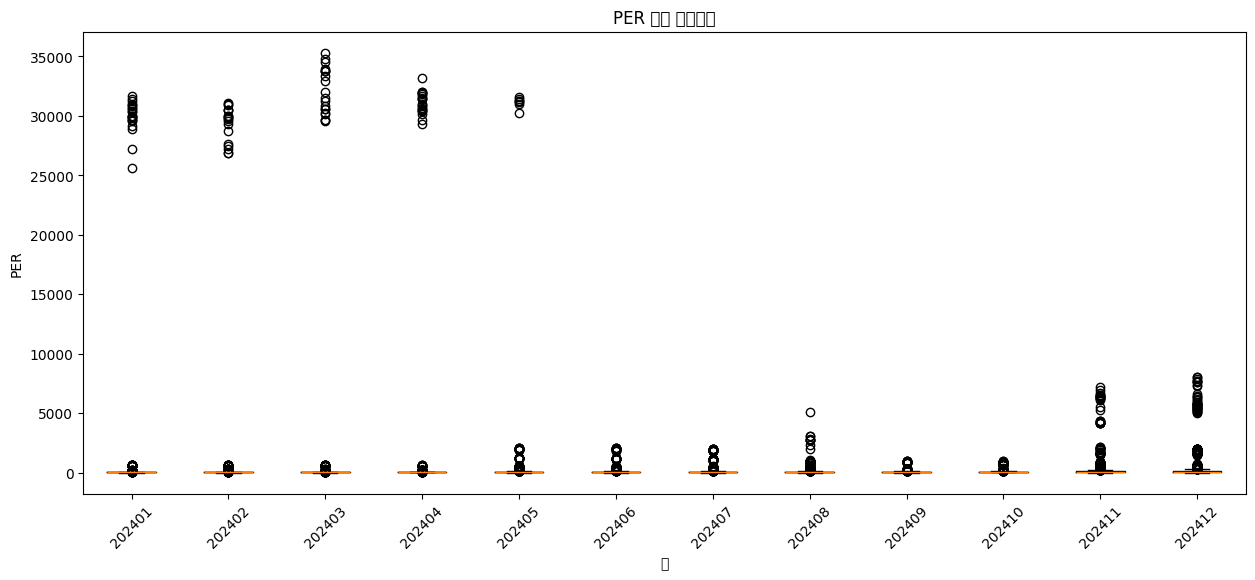

In [195]:
monthly_data = {}
for date in date_cols:
    month = date[:6]  # YYYYMM
    if month not in monthly_data:
        monthly_data[month] = []
    
    data = per_data[date].dropna()
    if len(data) > 0:
        monthly_data[month].extend(data.tolist())

# ÏõîÎ≥Ñ Î∞ïÏä§ÌîåÎ°Ø
months = sorted(monthly_data.keys())
month_data = [monthly_data[month] for month in months]

plt.figure(figsize=(15, 6))
plt.boxplot(month_data, labels=months)
plt.title('PER ÏõîÎ≥Ñ Î∞ïÏä§ÌîåÎ°Ø')
plt.xlabel('Ïõî')
plt.ylabel('PER')
plt.xticks(rotation=45)
plt.show()

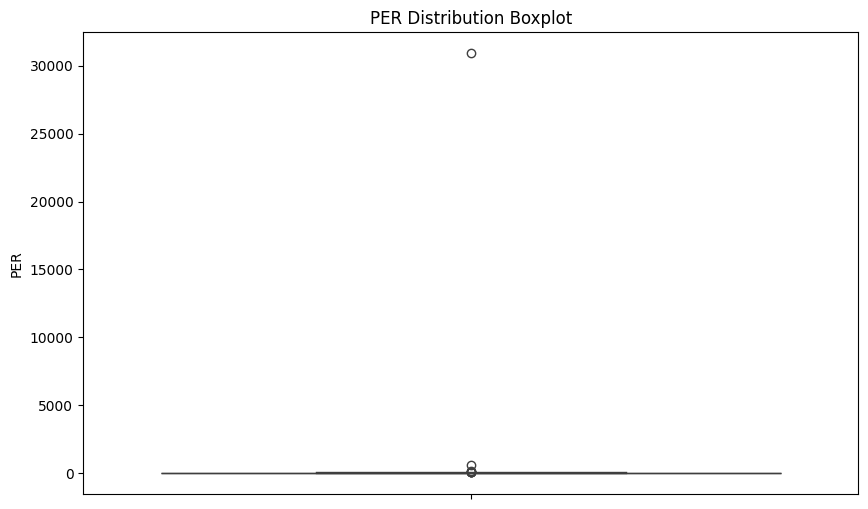

In [191]:
data = filter_metric_analysis(analysis_df, 'PER')['20240102']
data.describe()
plt.figure(figsize=(10, 6))
sns.boxplot(y=data.dropna())
plt.title('PER Distribution Boxplot')
plt.ylabel('PER')
plt.show()

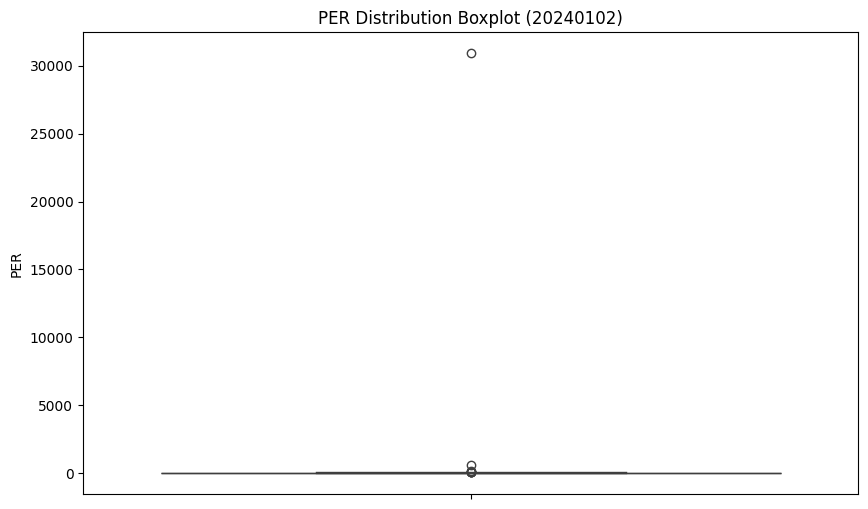

In [190]:
plt.figure(figsize=(10, 6))
sns.boxplot(y=data.dropna())
plt.title('PER Distribution Boxplot (20240102)')
plt.ylabel('PER')
plt.show()

üöÄ ÌÄÄÌä∏ Ìà¨Ïûê Ï†ÑÎûµ Î∂ÑÏÑù ÏãúÏûë
=== Îç∞Ïù¥ÌÑ∞ Î°úÎî© Î∞è Ï†ÑÏ≤òÎ¶¨ ===
Ï¥ù Îç∞Ïù¥ÌÑ∞ ÌñâÏàò: 721
ÎÇ†Ïßú Ïª¨Îüº Ïàò: 244
Î∂ÑÏÑù Í∏∞Í∞Ñ: 20240102 ~ 20241230
Íµ¨Î∂Ñ Ï¢ÖÎ•ò: ['Ï¢ÖÍ∞Ä', 'PER', 'PBR', 'ROE', 'ROA', 'ÏòÅÏóÖÏù¥ÏùµÎ•†', 'Î∂ÄÏ±ÑÎπÑÏú®']
Ï¢ÖÎ™© Ïàò: 103

=== ÏàòÏùµÎ•† Í≥ÑÏÇ∞ ===
ÌèâÍ∑† Ïó∞Í∞Ñ ÏàòÏùµÎ•†: 35.52%
Ï§ëÍ∞ÑÍ∞í: 28.41%
ÏµúÍ≥† ÏàòÏùµÎ•†: 178.94%
ÏµúÏ†Ä ÏàòÏùµÎ•†: -6.49%

=== Ïû¨Î¨¥ÏßÄÌëú Îç∞Ïù¥ÌÑ∞ Ï∂îÏ∂ú ===
Ïû¨Î¨¥ÏßÄÌëú Îç∞Ïù¥ÌÑ∞ ÌòïÌÉú: (103, 6)

=== Ï¢ÖÎ™© Ïä§ÌÅ¨Î¶¨Îãù ===
Ïä§ÌÅ¨Î¶¨Îãù ÌÜµÍ≥º Ï¢ÖÎ™©: 25Í∞ú

=== Ìå©ÌÑ∞ Ïä§ÏΩîÏñ¥ Í≥ÑÏÇ∞ ===
Ìå©ÌÑ∞ Î∂ÑÏÑù ÏôÑÎ£å Ï¢ÖÎ™©: 25Í∞ú

=== ÏÉÅÏúÑ 20Í∞ú Ï¢ÖÎ™© Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ ÏÉùÏÑ± ===

üìä Î∂ÑÏÑù Í≤∞Í≥º

üèÜ ÏÉÅÏúÑ 10Í∞ú Ï∂îÏ≤ú Ï¢ÖÎ™©:
 1. ÎåÄÎ™ÖÏÜåÎÖ∏ÏãúÏ¶å          | Ï†êÏàò: 386605.814 | ÏàòÏùµÎ•†:   45.0%
 2. Ïú†Î∞îÏù¥Ïò§Î°úÏßÅÏä§         | Ï†êÏàò: 10.330 | ÏàòÏùµÎ•†:   10.2%
 3. Ìã∞Ïì∞Î¶¨             | Ï†êÏàò:  9.736 | ÏàòÏùµÎ•†:   23.2%
 4. SKÌïòÏù¥ÎãâÏä§          | Ï†êÏàò:  8.166 | ÏàòÏùµÎ•†:   22.1%
 5. ÏïÑÏù¥ÎπÑ

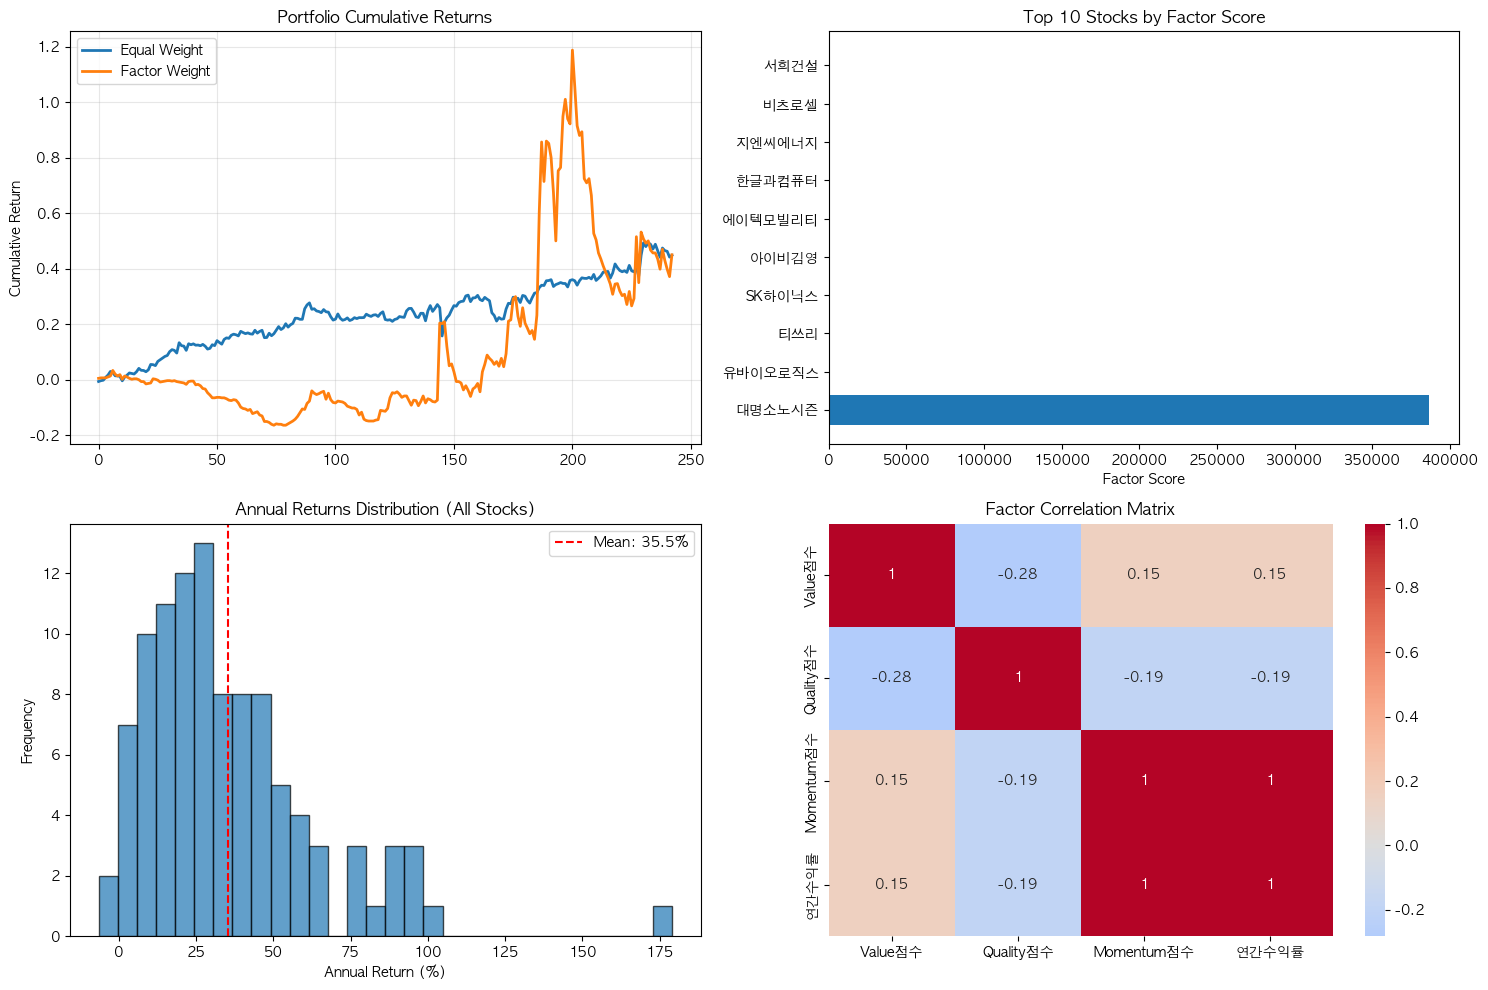


üéØ Ìà¨Ïûê Ï†ÑÎûµ Ï†úÏïà:
1. ÏÉÅÏúÑ 20Í∞ú Ï¢ÖÎ™©ÏúºÎ°ú Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ Íµ¨ÏÑ±
2. Î∂ÑÍ∏∞Î≥Ñ Î¶¨Î∞∏Îü∞Ïã± Ïã§Ïãú
3. Í∞úÎ≥Ñ Ï¢ÖÎ™© ÎπÑÏ§ë 5% Ïù¥ÌïòÎ°ú Ï†úÌïú
4. ÏÑπÌÑ∞ Î∂ÑÏÇ∞ Í≥†Î†§ÌïòÏó¨ Ï°∞Ï†ï
5. ÏãúÏû• ÏÉÅÌô©Ïóê Îî∞Î•∏ ÌòÑÍ∏à ÎπÑÏ§ë Ï°∞Ï†à


In [177]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# ÌïúÍ∏Ä Ìè∞Ìä∏ ÏÑ§Ï†ï
plt.rcParams['axes.unicode_minus'] = False

def load_and_prepare_data(file_path):
    """
    Îç∞Ïù¥ÌÑ∞ Î°úÎìú Î∞è Ï†ÑÏ≤òÎ¶¨
    """
    print("=== Îç∞Ïù¥ÌÑ∞ Î°úÎî© Î∞è Ï†ÑÏ≤òÎ¶¨ ===")
    
    # CSV ÌååÏùº ÏùΩÍ∏∞
    df = pd.read_csv(file_path, encoding='utf-8')
    
    # ÎÇ†Ïßú Ïª¨Îüº Ï∂îÏ∂ú (YYYYMMDD ÌòïÌÉú)
    date_columns = [col for col in df.columns if re.match(r'^\d{8}$', col)]
    
    print(f"Ï¥ù Îç∞Ïù¥ÌÑ∞ ÌñâÏàò: {len(df)}")
    print(f"ÎÇ†Ïßú Ïª¨Îüº Ïàò: {len(date_columns)}")
    print(f"Î∂ÑÏÑù Í∏∞Í∞Ñ: {date_columns[0]} ~ {date_columns[-1]}")
    
    # Íµ¨Î∂ÑÎ≥Ñ Îç∞Ïù¥ÌÑ∞ Î∂ÑÎ¶¨
    data_dict = {}
    for category in df['Íµ¨Î∂Ñ'].unique():
        data_dict[category] = df[df['Íµ¨Î∂Ñ'] == category].set_index('Ï¢ÖÎ™©Î™Ö')[date_columns]
    
    print(f"Íµ¨Î∂Ñ Ï¢ÖÎ•ò: {list(data_dict.keys())}")
    print(f"Ï¢ÖÎ™© Ïàò: {len(data_dict['Ï¢ÖÍ∞Ä'])}")
    
    return data_dict, date_columns

def calculate_stock_returns(price_data, date_columns):
    """
    Ï¢ÖÎ™©Î≥Ñ ÏàòÏùµÎ•† Í≥ÑÏÇ∞
    """
    print("\n=== ÏàòÏùµÎ•† Í≥ÑÏÇ∞ ===")
    
    # Ïó∞Í∞Ñ ÏàòÏùµÎ•† Í≥ÑÏÇ∞
    annual_returns = {}
    for stock in price_data.index:
        try:
            start_price = price_data.loc[stock, date_columns[0]]
            end_price = price_data.loc[stock, date_columns[-1]]
            
            if pd.notna(start_price) and pd.notna(end_price) and start_price > 0:
                annual_return = (end_price / start_price - 1) * 100
                annual_returns[stock] = annual_return
        except:
            continue
    
    # ÏùºÎ≥Ñ ÏàòÏùµÎ•† Í≥ÑÏÇ∞
    daily_returns = price_data.pct_change(axis=1)
    
    # ÌÜµÍ≥Ñ Ï∂úÎ†•
    returns_list = list(annual_returns.values())
    print(f"ÌèâÍ∑† Ïó∞Í∞Ñ ÏàòÏùµÎ•†: {np.mean(returns_list):.2f}%")
    print(f"Ï§ëÍ∞ÑÍ∞í: {np.median(returns_list):.2f}%")
    print(f"ÏµúÍ≥† ÏàòÏùµÎ•†: {max(returns_list):.2f}%")
    print(f"ÏµúÏ†Ä ÏàòÏùµÎ•†: {min(returns_list):.2f}%")
    
    return annual_returns, daily_returns

def get_latest_fundamentals(data_dict, date_columns):
    """
    ÏµúÏã† Ïû¨Î¨¥ÏßÄÌëú Îç∞Ïù¥ÌÑ∞ Ï∂îÏ∂ú
    """
    print("\n=== Ïû¨Î¨¥ÏßÄÌëú Îç∞Ïù¥ÌÑ∞ Ï∂îÏ∂ú ===")
    
    fundamentals = {}
    metrics = ['PER', 'PBR', 'ROE', 'ROA', 'ÏòÅÏóÖÏù¥ÏùµÎ•†', 'Î∂ÄÏ±ÑÎπÑÏú®']
    
    for metric in metrics:
        if metric in data_dict:
            # Í∞ÄÏû• ÏµúÍ∑º Îç∞Ïù¥ÌÑ∞ ÏÇ¨Ïö©
            latest_data = data_dict[metric][date_columns[-1]]
            fundamentals[metric] = latest_data.to_dict()
    
    # DataFrameÏúºÎ°ú Î≥ÄÌôò
    fundamental_df = pd.DataFrame(fundamentals)
    print(f"Ïû¨Î¨¥ÏßÄÌëú Îç∞Ïù¥ÌÑ∞ ÌòïÌÉú: {fundamental_df.shape}")
    
    return fundamental_df

def screen_stocks(fundamental_df, annual_returns):
    """
    Ï¢ÖÎ™© Ïä§ÌÅ¨Î¶¨Îãù
    """
    print("\n=== Ï¢ÖÎ™© Ïä§ÌÅ¨Î¶¨Îãù ===")
    
    qualified_stocks = []
    
    for stock in fundamental_df.index:
        if stock not in annual_returns:
            continue
            
        try:
            per = fundamental_df.loc[stock, 'PER']
            pbr = fundamental_df.loc[stock, 'PBR']
            roe = fundamental_df.loc[stock, 'ROE']
            debt_ratio = fundamental_df.loc[stock, 'Î∂ÄÏ±ÑÎπÑÏú®']
            
            # NaN Ï≤¥ÌÅ¨
            if pd.isna(per) or pd.isna(pbr) or pd.isna(roe) or pd.isna(debt_ratio):
                continue
            
            # Ïä§ÌÅ¨Î¶¨Îãù Ï°∞Í±¥
            if (per > 0 and per < 50 and      # PER 0~50
                pbr > 0 and pbr < 5 and       # PBR 0~5
                roe > 0 and                   # ROE ÏñëÏàò
                debt_ratio < 300):            # Î∂ÄÏ±ÑÎπÑÏú® 300% ÎØ∏Îßå
                
                qualified_stocks.append(stock)
                
        except:
            continue
    
    print(f"Ïä§ÌÅ¨Î¶¨Îãù ÌÜµÍ≥º Ï¢ÖÎ™©: {len(qualified_stocks)}Í∞ú")
    return qualified_stocks

def calculate_factor_scores(fundamental_df, annual_returns, qualified_stocks):
    """
    Ìå©ÌÑ∞ Ïä§ÏΩîÏñ¥ Í≥ÑÏÇ∞
    """
    print("\n=== Ìå©ÌÑ∞ Ïä§ÏΩîÏñ¥ Í≥ÑÏÇ∞ ===")
    
    factor_data = []
    
    for stock in qualified_stocks:
        try:
            per = fundamental_df.loc[stock, 'PER']
            pbr = fundamental_df.loc[stock, 'PBR']
            roe = fundamental_df.loc[stock, 'ROE']
            roa = fundamental_df.loc[stock, 'ROA']
            profit_margin = fundamental_df.loc[stock, 'ÏòÅÏóÖÏù¥ÏùµÎ•†']
            annual_return = annual_returns[stock]
            
            # Ìå©ÌÑ∞ Ïä§ÏΩîÏñ¥ Í≥ÑÏÇ∞
            value_score = (1/per + 1/pbr) if per > 0 and pbr > 0 else 0
            quality_score = (roe + roa + profit_margin) / 3
            momentum_score = annual_return / 100  # ÌçºÏÑºÌä∏Î•º ÏÜåÏàòÎ°ú Î≥ÄÌôò
            
            # Ï¢ÖÌï© Ïä§ÏΩîÏñ¥ (0-1 Ï†ïÍ∑úÌôî ÌõÑ Í∞ÄÏ§ëÌèâÍ∑†)
            total_score = value_score * 0.3 + quality_score * 0.4 + momentum_score * 0.3
            
            factor_data.append({
                'Ï¢ÖÎ™©Î™Ö': stock,
                'PER': per,
                'PBR': pbr,
                'ROE': roe,
                'ROA': roa,
                'ÏòÅÏóÖÏù¥ÏùµÎ•†': profit_margin,
                'Ïó∞Í∞ÑÏàòÏùµÎ•†': annual_return,
                'ValueÏ†êÏàò': value_score,
                'QualityÏ†êÏàò': quality_score,
                'MomentumÏ†êÏàò': momentum_score,
                'Ï¢ÖÌï©Ï†êÏàò': total_score
            })
            
        except:
            continue
    
    factor_df = pd.DataFrame(factor_data).set_index('Ï¢ÖÎ™©Î™Ö')
    print(f"Ìå©ÌÑ∞ Î∂ÑÏÑù ÏôÑÎ£å Ï¢ÖÎ™©: {len(factor_df)}Í∞ú")
    
    return factor_df

def create_portfolio(factor_df, top_n=20):
    """
    Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ ÏÉùÏÑ±
    """
    print(f"\n=== ÏÉÅÏúÑ {top_n}Í∞ú Ï¢ÖÎ™© Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ ÏÉùÏÑ± ===")
    
    # Ï¢ÖÌï©Ï†êÏàò Í∏∞Ï§Ä ÏÉÅÏúÑ Ï¢ÖÎ™© ÏÑ†ÌÉù
    top_stocks = factor_df.nlargest(top_n, 'Ï¢ÖÌï©Ï†êÏàò')
    
    # ÎèôÏùºÍ∞ÄÏ§ë Ìè¨Ìä∏Ìè¥Î¶¨Ïò§
    equal_weights = {stock: 1/top_n for stock in top_stocks.index}
    
    # Ìå©ÌÑ∞Ï†êÏàò Í∞ÄÏ§ë Ìè¨Ìä∏Ìè¥Î¶¨Ïò§
    total_score = top_stocks['Ï¢ÖÌï©Ï†êÏàò'].sum()
    factor_weights = {stock: score/total_score for stock, score in top_stocks['Ï¢ÖÌï©Ï†êÏàò'].items()}
    
    return top_stocks, equal_weights, factor_weights

def backtest_portfolio(portfolio_weights, daily_returns, date_columns):
    """
    Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ Î∞±ÌÖåÏä§ÌåÖ
    """
    portfolio_returns = []
    
    for date in date_columns[1:]:  # Ï≤´ ÎÇ† Ï†úÏô∏ (ÏàòÏùµÎ•† Í≥ÑÏÇ∞ Î∂àÍ∞Ä)
        daily_return = 0
        valid_weights = 0
        
        for stock, weight in portfolio_weights.items():
            if stock in daily_returns.index:
                stock_return = daily_returns.loc[stock, date]
                if pd.notna(stock_return):
                    daily_return += weight * stock_return
                    valid_weights += weight
        
        # Ïú†Ìö®Ìïú Í∞ÄÏ§ëÏπòÎ°ú Ï†ïÍ∑úÌôî
        if valid_weights > 0:
            daily_return = daily_return / valid_weights
        
        portfolio_returns.append(daily_return)
    
    portfolio_returns = pd.Series(portfolio_returns)
    
    # ÏÑ±Í≥º ÏßÄÌëú Í≥ÑÏÇ∞
    total_return = (1 + portfolio_returns).prod() - 1
    volatility = portfolio_returns.std() * np.sqrt(252)
    
    # ÏÉ§ÌîÑ ÎπÑÏú® (Î¨¥ÏúÑÌóò ÏàòÏùµÎ•† 2% Í∞ÄÏ†ï)
    excess_return = total_return - 0.02
    sharpe_ratio = excess_return / volatility if volatility > 0 else 0
    
    # ÏµúÎåÄ ÎÇôÌè≠
    cumulative = (1 + portfolio_returns).cumprod()
    running_max = cumulative.expanding().max()
    drawdown = (cumulative - running_max) / running_max
    max_drawdown = drawdown.min()
    
    performance = {
        'Ï¥ùÏàòÏùµÎ•†': total_return * 100,
        'Î≥ÄÎèôÏÑ±': volatility * 100,
        'ÏÉ§ÌîÑÎπÑÏú®': sharpe_ratio,
        'ÏµúÎåÄÎÇôÌè≠': max_drawdown * 100
    }
    
    return portfolio_returns, performance

def run_complete_analysis(file_path='analysis_df.csv'):
    """
    Ï†ÑÏ≤¥ ÌÄÄÌä∏ Î∂ÑÏÑù Ïã§Ìñâ
    """
    print("üöÄ ÌÄÄÌä∏ Ìà¨Ïûê Ï†ÑÎûµ Î∂ÑÏÑù ÏãúÏûë")
    print("=" * 50)
    
    # 1. Îç∞Ïù¥ÌÑ∞ Î°úÎìú
    data_dict, date_columns = load_and_prepare_data(file_path)
    
    # 2. ÏàòÏùµÎ•† Í≥ÑÏÇ∞
    annual_returns, daily_returns = calculate_stock_returns(data_dict['Ï¢ÖÍ∞Ä'], date_columns)
    
    # 3. Ïû¨Î¨¥ÏßÄÌëú Ï∂îÏ∂ú
    fundamental_df = get_latest_fundamentals(data_dict, date_columns)
    
    # 4. Ï¢ÖÎ™© Ïä§ÌÅ¨Î¶¨Îãù
    qualified_stocks = screen_stocks(fundamental_df, annual_returns)
    
    # 5. Ìå©ÌÑ∞ Î∂ÑÏÑù
    factor_df = calculate_factor_scores(fundamental_df, annual_returns, qualified_stocks)
    
    # 6. Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ Íµ¨ÏÑ±
    top_stocks, equal_weights, factor_weights = create_portfolio(factor_df, top_n=20)
    
    # 7. Î∞±ÌÖåÏä§ÌåÖ
    eq_returns, eq_performance = backtest_portfolio(equal_weights, daily_returns, date_columns)
    fw_returns, fw_performance = backtest_portfolio(factor_weights, daily_returns, date_columns)
    
    # 8. Í≤∞Í≥º Ï∂úÎ†•
    print("\n" + "=" * 50)
    print("üìä Î∂ÑÏÑù Í≤∞Í≥º")
    print("=" * 50)
    
    print(f"\nüèÜ ÏÉÅÏúÑ 10Í∞ú Ï∂îÏ≤ú Ï¢ÖÎ™©:")
    for i, (stock, row) in enumerate(top_stocks.head(10).iterrows(), 1):
        print(f"{i:2d}. {stock:15s} | Ï†êÏàò: {row['Ï¢ÖÌï©Ï†êÏàò']:6.3f} | ÏàòÏùµÎ•†: {row['Ïó∞Í∞ÑÏàòÏùµÎ•†']:6.1f}%")
    
    print(f"\nüìà ÎèôÏùºÍ∞ÄÏ§ë Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ ÏÑ±Í≥º:")
    for key, value in eq_performance.items():
        print(f"   {key}: {value:6.2f}{'%' if 'ÎπÑÏú®' in key or 'ÏàòÏùµÎ•†' in key or 'ÎÇôÌè≠' in key or 'Î≥ÄÎèôÏÑ±' in key else ''}")
    
    print(f"\nüéØ Ìå©ÌÑ∞Í∞ÄÏ§ë Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ ÏÑ±Í≥º:")
    for key, value in fw_performance.items():
        print(f"   {key}: {value:6.2f}{'%' if 'ÎπÑÏú®' in key or 'ÏàòÏùµÎ•†' in key or 'ÎÇôÌè≠' in key or 'Î≥ÄÎèôÏÑ±' in key else ''}")
    
    # ÏãúÍ∞ÅÌôî
    create_visualizations(top_stocks, eq_returns, fw_returns, annual_returns)
    
    return {
        'top_stocks': top_stocks,
        'factor_analysis': factor_df,
        'equal_weight_performance': eq_performance,
        'factor_weight_performance': fw_performance,
        'portfolio_weights': {'equal': equal_weights, 'factor': factor_weights}
    }

def create_visualizations(top_stocks, eq_returns, fw_returns, annual_returns):
    """
    Í≤∞Í≥º ÏãúÍ∞ÅÌôî
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # 1. Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ ÎàÑÏ†Å ÏàòÏùµÎ•†
    eq_cumulative = (1 + eq_returns).cumprod() - 1
    fw_cumulative = (1 + fw_returns).cumprod() - 1
    
    axes[0,0].plot(eq_cumulative.values, label='Equal Weight', linewidth=2)
    axes[0,0].plot(fw_cumulative.values, label='Factor Weight', linewidth=2)
    axes[0,0].set_title('Portfolio Cumulative Returns')
    axes[0,0].set_ylabel('Cumulative Return')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    
    # 2. ÏÉÅÏúÑ Ï¢ÖÎ™© Ï†êÏàò Î∂ÑÌè¨
    top_10 = top_stocks.head(10)
    axes[0,1].barh(range(len(top_10)), top_10['Ï¢ÖÌï©Ï†êÏàò'])
    axes[0,1].set_yticks(range(len(top_10)))
    axes[0,1].set_yticklabels([name[:10] + '...' if len(name) > 10 else name for name in top_10.index])
    axes[0,1].set_title('Top 10 Stocks by Factor Score')
    axes[0,1].set_xlabel('Factor Score')
    
    # 3. Ï†ÑÏ≤¥ Ï¢ÖÎ™© ÏàòÏùµÎ•† Î∂ÑÌè¨
    returns_list = list(annual_returns.values())
    axes[1,0].hist(returns_list, bins=30, alpha=0.7, edgecolor='black')
    axes[1,0].set_title('Annual Returns Distribution (All Stocks)')
    axes[1,0].set_xlabel('Annual Return (%)')
    axes[1,0].set_ylabel('Frequency')
    axes[1,0].axvline(np.mean(returns_list), color='red', linestyle='--', label=f'Mean: {np.mean(returns_list):.1f}%')
    axes[1,0].legend()
    
    # 4. Ìå©ÌÑ∞Î≥Ñ ÏÉÅÍ¥ÄÍ¥ÄÍ≥Ñ
    factor_corr = top_stocks[['ValueÏ†êÏàò', 'QualityÏ†êÏàò', 'MomentumÏ†êÏàò', 'Ïó∞Í∞ÑÏàòÏùµÎ•†']].corr()
    sns.heatmap(factor_corr, annot=True, cmap='coolwarm', center=0, ax=axes[1,1])
    axes[1,1].set_title('Factor Correlation Matrix')
    
    plt.tight_layout()
    plt.show()
    
    return fig

# Ïã§Ìñâ ÏòàÏãú
if __name__ == "__main__":
    # Î∂ÑÏÑù Ïã§Ìñâ
    results = run_complete_analysis('analysis_df.csv')
    
    print("\nüéØ Ìà¨Ïûê Ï†ÑÎûµ Ï†úÏïà:")
    print("1. ÏÉÅÏúÑ 20Í∞ú Ï¢ÖÎ™©ÏúºÎ°ú Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ Íµ¨ÏÑ±")
    print("2. Î∂ÑÍ∏∞Î≥Ñ Î¶¨Î∞∏Îü∞Ïã± Ïã§Ïãú")
    print("3. Í∞úÎ≥Ñ Ï¢ÖÎ™© ÎπÑÏ§ë 5% Ïù¥ÌïòÎ°ú Ï†úÌïú")
    print("4. ÏÑπÌÑ∞ Î∂ÑÏÇ∞ Í≥†Î†§ÌïòÏó¨ Ï°∞Ï†ï")
    print("5. ÏãúÏû• ÏÉÅÌô©Ïóê Îî∞Î•∏ ÌòÑÍ∏à ÎπÑÏ§ë Ï°∞Ï†à")

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from datetime import datetime, timedelta
import pandas as pd

# ÌïúÍ∏Ä Ìè∞Ìä∏ ÏÑ§Ï†ï
plt.rcParams['axes.unicode_minus'] = False

def plot_backtest_results(backtest_results, analysis_df=None):
    """
    Î∞±ÌÖåÏä§Ìä∏ Í≤∞Í≥ºÎ•º ÏãúÍ∞ÅÌôîÌïòÎäî Ìï®Ïàò
    
    Parameters:
    - backtest_results: run_monthly_rebalancing_backtest Ìï®ÏàòÏùò Í≤∞Í≥º
    - analysis_df: Ìå©ÌÑ∞ ÏÉÅÍ¥ÄÍ¥ÄÍ≥Ñ Î∂ÑÏÑùÏö© Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑ
    """
    
    # 2x2 ÏÑúÎ∏åÌîåÎ°Ø ÏÉùÏÑ±
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Monthly Rebalancing Backtest Results', fontsize=16, fontweight='bold')
    
    # Îç∞Ïù¥ÌÑ∞ Ï§ÄÎπÑ
    months = range(1, len(backtest_results['total_capital']))
    total_capitals = backtest_results['total_capital']
    monthly_returns = backtest_results['monthly_returns']
    cumulative_returns = backtest_results['cumulative_returns']
    
    # 1. ÎàÑÏ†Å ÏûêÎ≥∏ Í∑∏ÎûòÌîÑ
    axes[0, 0].plot(months, total_capitals[1:], linewidth=2, color='#2E86AB', marker='o', markersize=4)
    axes[0, 0].set_title('Cumulative Capital Growth', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Month')
    axes[0, 0].set_ylabel('Capital (KRW)')
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.1f}M'))
    
    # Ï¥àÍ∏∞ ÏûêÎ≥∏ Í∏∞Ï§ÄÏÑ† Ï∂îÍ∞Ä
    axes[0, 0].axhline(y=backtest_results['initial_capital'], color='red', linestyle='--', alpha=0.7, label='Initial Capital')
    axes[0, 0].legend()
    
    # 2. ÏõîÎ≥Ñ ÏàòÏùµÎ•† Í∑∏ÎûòÌîÑ
    colors = ['green' if x > 0 else 'red' for x in monthly_returns]
    axes[0, 1].bar(months, monthly_returns, color=colors, alpha=0.7)
    axes[0, 1].set_title('Monthly Returns', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Month')
    axes[0, 1].set_ylabel('Return (%)')
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].axhline(y=0, color='black', linestyle='-', alpha=0.3)
    
    # 3. ÎàÑÏ†Å ÏàòÏùµÎ•† Í∑∏ÎûòÌîÑ
    axes[1, 0].plot(months, cumulative_returns, linewidth=2, color='#A23B72', marker='s', markersize=4)
    axes[1, 0].set_title('Cumulative Returns', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Month')
    axes[1, 0].set_ylabel('Cumulative Return (%)')
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].axhline(y=0, color='black', linestyle='--', alpha=0.3)
    
    # 4. ÏÉ§ÌîÑ ÎπÑÏú® Î∞è ÏÑ±Í≥º ÏßÄÌëú
    if monthly_returns:
        # ÏõîÎ≥Ñ Î°§ÎßÅ ÏÉ§ÌîÑ ÎπÑÏú® Í≥ÑÏÇ∞ (ÏµúÏÜå 3Í∞úÏõî Îç∞Ïù¥ÌÑ∞ ÌïÑÏöî)
        rolling_sharpe = []
        for i in range(len(monthly_returns)):
            if i >= 2:  # ÏµúÏÜå 3Í∞úÏõî Îç∞Ïù¥ÌÑ∞
                returns_subset = monthly_returns[:i+1]
                avg_return = np.mean(returns_subset)
                volatility = np.std(returns_subset)
                sharpe = avg_return / volatility if volatility > 0 else 0
                rolling_sharpe.append(sharpe)
        
        if rolling_sharpe:
            sharpe_months = range(3, len(monthly_returns) + 1)
            axes[1, 1].plot(sharpe_months, rolling_sharpe, linewidth=2, color='#F18F01', marker='D', markersize=4)
            axes[1, 1].set_title('Rolling Sharpe Ratio', fontsize=14, fontweight='bold')
            axes[1, 1].set_xlabel('Month')
            axes[1, 1].set_ylabel('Sharpe Ratio')
            axes[1, 1].grid(True, alpha=0.3)
            axes[1, 1].axhline(y=0, color='black', linestyle='--', alpha=0.3)
        else:
            axes[1, 1].text(0.5, 0.5, 'Insufficient data\nfor Sharpe calculation', 
                          ha='center', va='center', transform=axes[1, 1].transAxes, fontsize=12)
            axes[1, 1].set_title('Rolling Sharpe Ratio', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # ÏÑ±Í≥º ÏöîÏïΩ Ï∂úÎ†•
    print_performance_summary(backtest_results)


def plot_factor_correlation(analysis_df, top_stocks=None):
    """
    Ìå©ÌÑ∞Î≥Ñ ÏÉÅÍ¥ÄÍ¥ÄÍ≥Ñ ÌûàÌä∏Îßµ Í∑∏Î¶¨Í∏∞
    
    Parameters:
    - analysis_df: Ï†ÑÏ≤¥ Î∂ÑÏÑù Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑ
    - top_stocks: ÏÉÅÏúÑ Ï¢ÖÎ™© Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑ (ÏóÜÏúºÎ©¥ Ï†ÑÏ≤¥ Îç∞Ïù¥ÌÑ∞ ÏÇ¨Ïö©)
    """
    
    plt.figure(figsize=(10, 8))
    
    # ÏÇ¨Ïö©Ìï† Îç∞Ïù¥ÌÑ∞ Í≤∞Ï†ï
    if top_stocks is not None and not top_stocks.empty:
        correlation_data = top_stocks[['ValueÏ†êÏàò', 'QualityÏ†êÏàò', 'MomentumÏ†êÏàò', 'Ïó∞Í∞ÑÏàòÏùµÎ•†']].corr()
        title = 'Factor Correlation Matrix (Top Stocks)'
    else:
        # analysis_dfÏóêÏÑú ÌïÑÏöîÌïú Ïª¨ÎüºÎì§Ïù¥ ÏûàÎäîÏßÄ ÌôïÏù∏
        required_columns = ['ValueÏ†êÏàò', 'QualityÏ†êÏàò', 'MomentumÏ†êÏàò', 'Ïó∞Í∞ÑÏàòÏùµÎ•†']
        available_columns = [col for col in required_columns if col in analysis_df.columns]
        
        if len(available_columns) >= 2:
            correlation_data = analysis_df[available_columns].corr()
            title = 'Factor Correlation Matrix (All Stocks)'
        else:
            # ÏÉòÌîå Îç∞Ïù¥ÌÑ∞ ÏÉùÏÑ±
            np.random.seed(42)
            n_stocks = 100
            
            sample_data = pd.DataFrame({
                'ValueÏ†êÏàò': np.random.normal(0, 1, n_stocks),
                'QualityÏ†êÏàò': np.random.normal(0, 1, n_stocks),
                'MomentumÏ†êÏàò': np.random.normal(0, 1, n_stocks),
                'Ïó∞Í∞ÑÏàòÏùµÎ•†': np.random.normal(8, 15, n_stocks)
            })
            
            correlation_data = sample_data.corr()
            title = 'Factor Correlation Matrix (Sample Data)'
    
    # ÌûàÌä∏Îßµ Í∑∏Î¶¨Í∏∞
    sns.heatmap(correlation_data, 
                annot=True, 
                cmap='coolwarm', 
                center=0, 
                square=True,
                linewidths=0.5,
                cbar_kws={"shrink": .8},
                fmt='.3f')
    
    plt.title(title, fontsize=14, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.show()


def print_performance_summary(backtest_results):
    """
    Î∞±ÌÖåÏä§Ìä∏ ÏÑ±Í≥º ÏöîÏïΩ Ï∂úÎ†•
    """
    print("\n" + "="*60)
    print("üìà PERFORMANCE SUMMARY")
    print("="*60)
    
    initial_capital = backtest_results['initial_capital']
    final_capital = backtest_results['final_capital']
    total_return = backtest_results['total_return']
    monthly_returns = backtest_results['monthly_returns']
    
    print(f"üí∞ Initial Capital: {initial_capital:,} KRW")
    print(f"üí∞ Final Capital: {final_capital:,.0f} KRW")
    print(f"üìä Total Return: {total_return:+.2f}%")
    
    if monthly_returns:
        avg_monthly = np.mean(monthly_returns)
        volatility = np.std(monthly_returns)
        best_month = max(monthly_returns)
        worst_month = min(monthly_returns)
        
        print(f"üìÖ Investment Period: {len(monthly_returns)} months")
        print(f"üìà Average Monthly Return: {avg_monthly:.2f}%")
        print(f"üìâ Monthly Volatility: {volatility:.2f}%")
        print(f"‚ö° Best Month: {best_month:+.2f}%")
        print(f"üí• Worst Month: {worst_month:+.2f}%")
        
        if volatility > 0:
            sharpe_ratio = avg_monthly / volatility
            print(f"üéØ Sharpe Ratio: {sharpe_ratio:.2f}")
            
            # Ïó∞Ïú®Ìôî ÏßÄÌëú
            annual_return = (1 + avg_monthly/100)**12 - 1
            annual_volatility = volatility * np.sqrt(12)
            annual_sharpe = annual_return / (annual_volatility/100)
            
            print(f"üìä Annualized Return: {annual_return*100:.2f}%")
            print(f"üìä Annualized Volatility: {annual_volatility:.2f}%")
            print(f"üìä Annualized Sharpe: {annual_sharpe:.2f}")


# ÏÇ¨Ïö© ÏòàÏãú
if __name__ == "__main__":
    # Î∞±ÌÖåÏä§Ìä∏ Í≤∞Í≥ºÍ∞Ä ÏûàÎã§Î©¥ ÏãúÍ∞ÅÌôî Ïã§Ìñâ
    plot_backtest_results(backtest_results)
    
    # Ìå©ÌÑ∞ ÏÉÅÍ¥ÄÍ¥ÄÍ≥Ñ ÏãúÍ∞ÅÌôî (analysis_dfÍ∞Ä ÏûàÎã§Î©¥)
    plot_factor_correlation(analysis_df)
    
    print("Î∞±ÌÖåÏä§Ìä∏ Í≤∞Í≥º ÏãúÍ∞ÅÌôî Ìï®ÏàòÍ∞Ä Ï§ÄÎπÑÎêòÏóàÏäµÎãàÎã§!")
    print("\nÏÇ¨Ïö©Î≤ï:")
    print("1. plot_backtest_results(backtest_results) - Î∞±ÌÖåÏä§Ìä∏ Í≤∞Í≥º ÏãúÍ∞ÅÌôî")
    print("2. plot_factor_correlation(analysis_df) - Ìå©ÌÑ∞ ÏÉÅÍ¥ÄÍ¥ÄÍ≥Ñ ÏãúÍ∞ÅÌôî")

üöÄ ÌÄÄÌä∏ Ìà¨Ïûê Ï†ÑÎûµ Î∂ÑÏÑù ÏãúÏûë!
üìÇ Îç∞Ïù¥ÌÑ∞ Î°úÎî© Ï§ë...
‚úÖ Î°úÎî© ÏôÑÎ£å: 721 Ìñâ, 244 Í±∞ÎûòÏùº
üìÖ Í∏∞Í∞Ñ: 20240102 ~ 20241230

üìä Îç∞Ïù¥ÌÑ∞ Íµ¨Ï°∞ ÌååÏïÖ Ï§ë...
üìà Íµ¨Î∂Ñ: ['Ï¢ÖÍ∞Ä', 'PER', 'PBR', 'ROE', 'ROA', 'ÏòÅÏóÖÏù¥ÏùµÎ•†', 'Î∂ÄÏ±ÑÎπÑÏú®']
üè¢ Ï¢ÖÎ™© Ïàò: 103 Í∞ú

üí∞ ÏàòÏùµÎ•† Í≥ÑÏÇ∞ Ï§ë...
üìä ÌèâÍ∑† ÏàòÏùµÎ•†: 35.5%
üìä ÏµúÍ≥† ÏàòÏùµÎ•†: 178.9%
üìä ÏµúÏ†Ä ÏàòÏùµÎ•†: -6.5%

üîç Ïû¨Î¨¥ÏßÄÌëú Î∂ÑÏÑù Ï§ë...
PER: Ï§ëÍ∞ÑÍ∞í 63.9, ÌèâÍ∑† 336.9
PBR: Ï§ëÍ∞ÑÍ∞í 1.8, ÌèâÍ∑† 3.5
ROE: Ï§ëÍ∞ÑÍ∞í 1.2, ÌèâÍ∑† -1.9
ROA: Ï§ëÍ∞ÑÍ∞í 0.7, ÌèâÍ∑† 0.5
ÏòÅÏóÖÏù¥ÏùµÎ•†: Ï§ëÍ∞ÑÍ∞í 3.5, ÌèâÍ∑† -58.3
Î∂ÄÏ±ÑÎπÑÏú®: Ï§ëÍ∞ÑÍ∞í 55.8, ÌèâÍ∑† 139.3

üéØ Ï¢ÖÎ™© Ïä§ÌÅ¨Î¶¨Îãù Ï§ë...
‚úÖ ÏÑ†Î≥ÑÎêú Ï¢ÖÎ™©: 34 Í∞ú

üèÜ Ìå©ÌÑ∞ Ïä§ÏΩîÏñ¥ Í≥ÑÏÇ∞ Ï§ë...
‚úÖ Ïä§ÏΩîÏñ¥ Í≥ÑÏÇ∞ ÏôÑÎ£å: 34 Í∞ú Ï¢ÖÎ™©

üéØ TOP 20 Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ ÏÉùÏÑ± Ï§ë...
‚úÖ Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ Íµ¨ÏÑ± ÏôÑÎ£å

üèÜ ÌÄÄÌä∏ Ìà¨Ïûê Î∂ÑÏÑù Í≤∞Í≥º

üìà TOP 10 Ï∂îÏ≤ú Ï¢ÖÎ™©:
 1. ÏÑúÌù¨Í±¥ÏÑ§            | Ï¥ùÏ†ê:   93.5 | ÏàòÏùµÎ•†: 

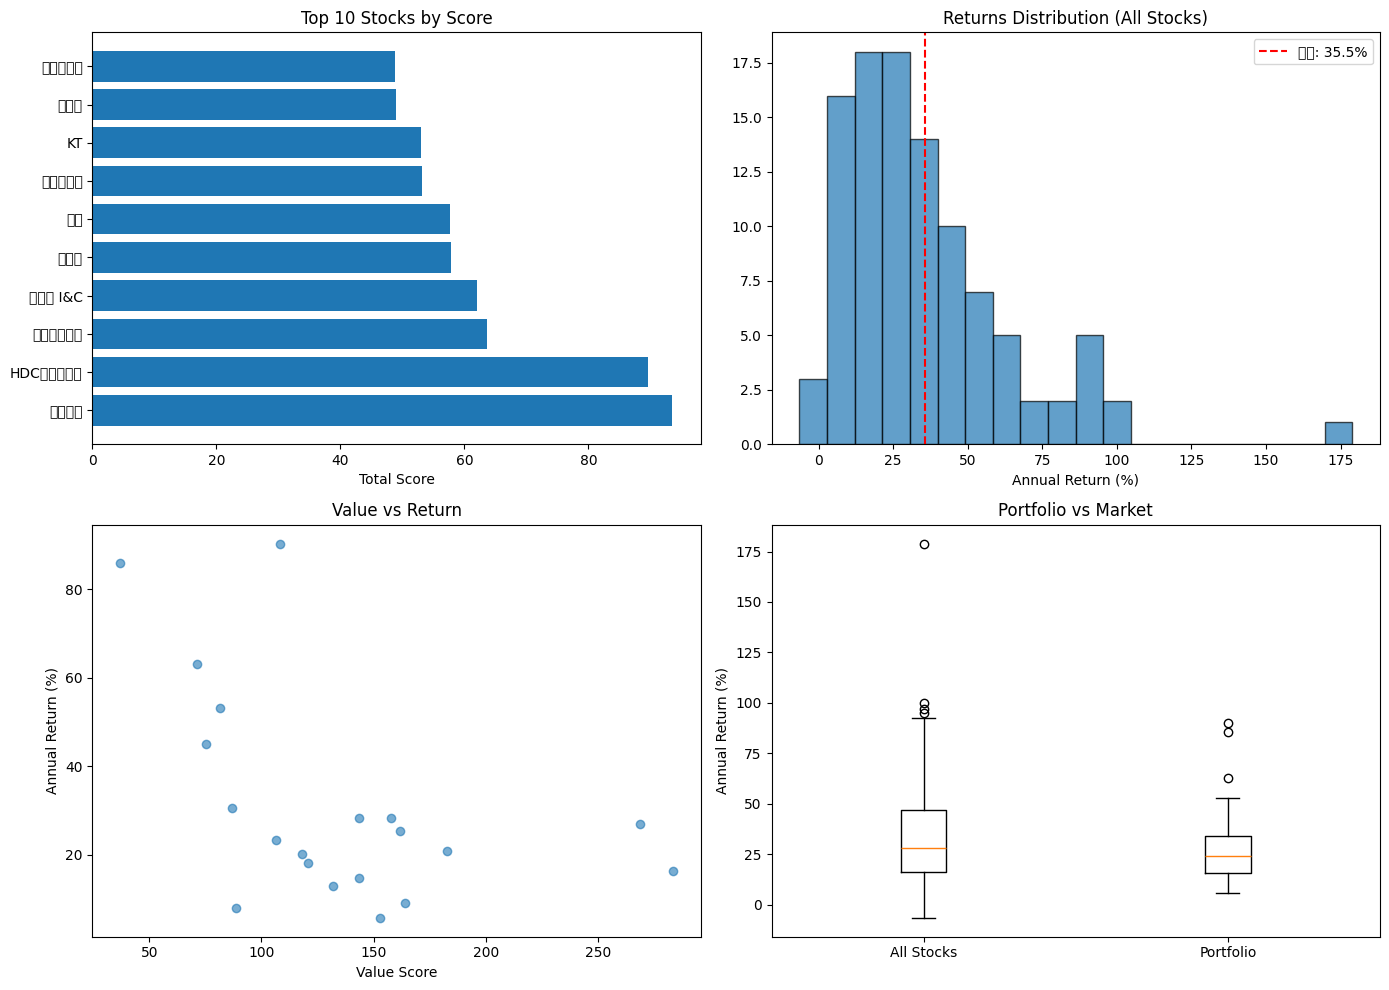


‚úÖ Î∂ÑÏÑù ÏôÑÎ£å!

üí° Ìà¨Ïûê Ï†ÑÎûµ ÏöîÏïΩ:
1. ÏÉÅÏúÑ 20Í∞ú Ï¢ÖÎ™©ÏúºÎ°ú Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ Íµ¨ÏÑ±
2. ÎèôÏùº Í∞ÄÏ§ë (Í∞Å 5%) ÎòêÎäî ÏãúÍ∞ÄÏ¥ùÏï° Í∞ÄÏ§ë ÏÑ†ÌÉù
3. Î∂ÑÍ∏∞Î≥Ñ Î¶¨Î∞∏Îü∞Ïã± Í∂åÏû•
4. Í∞úÎ≥Ñ Ï¢ÖÎ™© Î¶¨Ïä§ÌÅ¨ Î™®ÎãàÌÑ∞ÎßÅ ÌïÑÏàò


In [185]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# ÌïúÍ∏Ä Ìè∞Ìä∏ ÏÑ§Ï†ï
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

def load_data(file_path):
    """
    Îç∞Ïù¥ÌÑ∞ Î°úÎìú Î∞è Í∏∞Î≥∏ Ï†ÑÏ≤òÎ¶¨
    """
    print("üìÇ Îç∞Ïù¥ÌÑ∞ Î°úÎî© Ï§ë...")
    df = pd.read_csv(file_path, encoding='utf-8')
    
    # ÎÇ†Ïßú Ïª¨Îüº Ï∂îÏ∂ú (YYYYMMDD ÌòïÌÉú)
    date_cols = [col for col in df.columns if col.isdigit() and len(col) == 8]
    
    print(f"‚úÖ Î°úÎî© ÏôÑÎ£å: {len(df)} Ìñâ, {len(date_cols)} Í±∞ÎûòÏùº")
    print(f"üìÖ Í∏∞Í∞Ñ: {date_cols[0]} ~ {date_cols[-1]}")
    
    return df, date_cols

def get_stock_data(df, date_cols):
    """
    Íµ¨Î∂ÑÎ≥Ñ Îç∞Ïù¥ÌÑ∞ Ï∂îÏ∂ú
    """
    print("\nüìä Îç∞Ïù¥ÌÑ∞ Íµ¨Ï°∞ ÌååÏïÖ Ï§ë...")
    
    # Íµ¨Î∂ÑÎ≥ÑÎ°ú Îç∞Ïù¥ÌÑ∞ Î∂ÑÎ¶¨
    stock_data = {}
    for category in df['Íµ¨Î∂Ñ'].unique():
        stock_data[category] = df[df['Íµ¨Î∂Ñ'] == category].set_index('Ï¢ÖÎ™©Î™Ö')[date_cols]
    
    print(f"üìà Íµ¨Î∂Ñ: {list(stock_data.keys())}")
    print(f"üè¢ Ï¢ÖÎ™© Ïàò: {len(stock_data['Ï¢ÖÍ∞Ä'])} Í∞ú")
    
    return stock_data

def calculate_returns(price_data, date_cols):
    """
    ÏàòÏùµÎ•† Í≥ÑÏÇ∞
    """
    print("\nüí∞ ÏàòÏùµÎ•† Í≥ÑÏÇ∞ Ï§ë...")
    
    returns = {}
    for stock in price_data.index:
        start_price = price_data.loc[stock, date_cols[0]]
        end_price = price_data.loc[stock, date_cols[-1]]
        
        if pd.notna(start_price) and pd.notna(end_price) and start_price > 0:
            annual_return = (end_price / start_price - 1) * 100
            returns[stock] = annual_return
    
    # Í∏∞Î≥∏ ÌÜµÍ≥Ñ
    return_values = list(returns.values())
    print(f"üìä ÌèâÍ∑† ÏàòÏùµÎ•†: {np.mean(return_values):.1f}%")
    print(f"üìä ÏµúÍ≥† ÏàòÏùµÎ•†: {max(return_values):.1f}%")
    print(f"üìä ÏµúÏ†Ä ÏàòÏùµÎ•†: {min(return_values):.1f}%")
    
    return returns

def analyze_fundamentals(stock_data, date_cols):
    """
    Ïû¨Î¨¥ÏßÄÌëú Î∂ÑÏÑù
    """
    print("\nüîç Ïû¨Î¨¥ÏßÄÌëú Î∂ÑÏÑù Ï§ë...")
    
    # ÏµúÏã† Ïû¨Î¨¥ÏßÄÌëú Îç∞Ïù¥ÌÑ∞
    fundamentals = {}
    metrics = ['PER', 'PBR', 'ROE', 'ROA', 'ÏòÅÏóÖÏù¥ÏùµÎ•†', 'Î∂ÄÏ±ÑÎπÑÏú®']
    
    for metric in metrics:
        if metric in stock_data:
            latest_data = stock_data[metric][date_cols[-1]]
            fundamentals[metric] = latest_data
    
    fund_df = pd.DataFrame(fundamentals)
    
    # Í∞Å ÏßÄÌëúÏùò Î∂ÑÌè¨ Ï∂úÎ†•
    for metric in metrics:
        if metric in fund_df.columns:
            values = fund_df[metric].dropna()
            if len(values) > 0:
                print(f"{metric}: Ï§ëÍ∞ÑÍ∞í {values.median():.1f}, ÌèâÍ∑† {values.mean():.1f}")
    
    return fund_df

def screen_stocks(fund_df, returns):
    """
    Ï¢ÖÎ™© Ïä§ÌÅ¨Î¶¨Îãù (Ïã§Ï†ú Îç∞Ïù¥ÌÑ∞ Í∏∞Î∞ò)
    """
    print("\nüéØ Ï¢ÖÎ™© Ïä§ÌÅ¨Î¶¨Îãù Ï§ë...")
    
    # Ïã§Ï†ú Îç∞Ïù¥ÌÑ∞ Î∂ÑÌè¨Î•º Í≥†Î†§Ìïú ÌòÑÏã§Ï†Å Í∏∞Ï§Ä
    criteria = {
        'PER': (0, 100),      # 0 < PER < 100
        'PBR': (0, 4),        # 0 < PBR < 4  
        'ROE': (1, 100),      # ROE > 1%
        'Î∂ÄÏ±ÑÎπÑÏú®': (0, 150)   # Î∂ÄÏ±ÑÎπÑÏú® < 150%
    }
    
    selected = []
    
    for stock in fund_df.index:
        if stock not in returns:
            continue
            
        # Î™®Îì† Ï°∞Í±¥ ÌôïÏù∏
        valid = True
        for metric, (min_val, max_val) in criteria.items():
            if metric not in fund_df.columns:
                continue
                
            value = fund_df.loc[stock, metric]
            if pd.isna(value) or value <= min_val or value >= max_val:
                valid = False
                break
        
        if valid:
            selected.append(stock)
    
    print(f"‚úÖ ÏÑ†Î≥ÑÎêú Ï¢ÖÎ™©: {len(selected)} Í∞ú")
    return selected

def calculate_scores(fund_df, returns, selected_stocks):
    """
    Ìå©ÌÑ∞ Ïä§ÏΩîÏñ¥ Í≥ÑÏÇ∞
    """
    print("\nüèÜ Ìå©ÌÑ∞ Ïä§ÏΩîÏñ¥ Í≥ÑÏÇ∞ Ï§ë...")
    
    scores = []
    
    for stock in selected_stocks:
        try:
            per = fund_df.loc[stock, 'PER']
            pbr = fund_df.loc[stock, 'PBR']
            roe = fund_df.loc[stock, 'ROE']
            roa = fund_df.loc[stock, 'ROA']
            profit = fund_df.loc[stock, 'ÏòÅÏóÖÏù¥ÏùµÎ•†']
            ret = returns[stock]
            
            # Ìå©ÌÑ∞ Ï†êÏàò Í≥ÑÏÇ∞
            value = (1/per + 1/pbr) * 100  # Î∞∏Î•ò (ÎÇÆÏùÑÏàòÎ°ù Ï¢ãÏùå)
            quality = (roe + roa + profit) / 3  # ÌÄÑÎ¶¨Ìã∞ (ÎÜíÏùÑÏàòÎ°ù Ï¢ãÏùå)
            momentum = ret  # Î™®Î©òÌÖÄ (ÎÜíÏùÑÏàòÎ°ù Ï¢ãÏùå)
            
            # Ï¢ÖÌï© Ï†êÏàò (Ï†ïÍ∑úÌôî ÌõÑ Í∞ÄÏ§ëÌèâÍ∑†)
            total = value * 0.3 + quality * 0.4 + momentum * 0.3
            
            scores.append({
                'Ï¢ÖÎ™©': stock,
                'PER': per,
                'PBR': pbr,
                'ROE': roe,
                'ÏàòÏùµÎ•†': ret,
                'Value': value,
                'Quality': quality,
                'Momentum': momentum,
                'Ï¥ùÏ†ê': total
            })
        except:
            continue
    
    score_df = pd.DataFrame(scores).set_index('Ï¢ÖÎ™©')
    print(f"‚úÖ Ïä§ÏΩîÏñ¥ Í≥ÑÏÇ∞ ÏôÑÎ£å: {len(score_df)} Í∞ú Ï¢ÖÎ™©")
    
    return score_df

def create_portfolio(score_df, top_n=20):
    """
    Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ ÏÉùÏÑ±
    """
    print(f"\nüéØ TOP {top_n} Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ ÏÉùÏÑ± Ï§ë...")
    
    # Ï¥ùÏ†ê Í∏∞Ï§Ä ÏÉÅÏúÑ Ï¢ÖÎ™©
    top_stocks = score_df.nlargest(top_n, 'Ï¥ùÏ†ê')
    
    # ÎèôÏùºÍ∞ÄÏ§ë Ìè¨Ìä∏Ìè¥Î¶¨Ïò§
    equal_weights = {stock: 1/top_n for stock in top_stocks.index}
    
    print(f"‚úÖ Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ Íµ¨ÏÑ± ÏôÑÎ£å")
    return top_stocks, equal_weights

def show_results(top_stocks, returns):
    """
    Í≤∞Í≥º Ï∂úÎ†•
    """
    print("\n" + "="*60)
    print("üèÜ ÌÄÄÌä∏ Ìà¨Ïûê Î∂ÑÏÑù Í≤∞Í≥º")
    print("="*60)
    
    print(f"\nüìà TOP 10 Ï∂îÏ≤ú Ï¢ÖÎ™©:")
    for i, (stock, row) in enumerate(top_stocks.head(10).iterrows(), 1):
        print(f"{i:2d}. {stock:<15} | Ï¥ùÏ†ê: {row['Ï¥ùÏ†ê']:6.1f} | ÏàòÏùµÎ•†: {row['ÏàòÏùµÎ•†']:6.1f}%")
    
    # Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ ÌÜµÍ≥Ñ
    portfolio_returns = top_stocks['ÏàòÏùµÎ•†'].values
    print(f"\nüìä Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ ÌÜµÍ≥Ñ:")
    print(f"   ÌèâÍ∑† ÏàòÏùµÎ•†: {np.mean(portfolio_returns):6.1f}%")
    print(f"   ÏàòÏùµÎ•† Î≤îÏúÑ: {min(portfolio_returns):6.1f}% ~ {max(portfolio_returns):6.1f}%")
    print(f"   ÌëúÏ§ÄÌé∏Ï∞®:   {np.std(portfolio_returns):6.1f}%")
    
    # ÏÑπÌÑ∞/ÏóÖÏ¢Ö Î∂ÑÏÑù (Ï¢ÖÎ™©Î™Ö Í∏∞Î∞ò Ï∂îÏ†ï)
    print(f"\nüè≠ ÏóÖÏ¢Ö Î∂ÑÌè¨ (Ï∂îÏ†ï):")
    tech_stocks = [s for s in top_stocks.index if any(keyword in s for keyword in ['ÏãúÏä§ÌÖú', 'ÌÖåÌÅ¨', 'ÏÜåÌîÑÌä∏', 'IT'])]
    heavy_stocks = [s for s in top_stocks.index if any(keyword in s for keyword in ['Ï§ëÍ≥µÏóÖ', 'Ï°∞ÏÑ†', 'Í±¥ÏÑ§', 'Ï≤†Í∞ï'])]
    chem_stocks = [s for s in top_stocks.index if any(keyword in s for keyword in ['ÌôîÌïô', 'ÏºÄÎØ∏', 'Ï†úÏïΩ', 'Î∞îÏù¥Ïò§'])]
    
    print(f"   Í∏∞Ïà†Ï£º:     {len(tech_stocks)} Í∞ú")
    print(f"   Ï§ëÍ≥µÏóÖ:     {len(heavy_stocks)} Í∞ú") 
    print(f"   ÌôîÌïô/Î∞îÏù¥Ïò§: {len(chem_stocks)} Í∞ú")
    print(f"   Í∏∞ÌÉÄ:       {len(top_stocks) - len(tech_stocks) - len(heavy_stocks) - len(chem_stocks)} Í∞ú")

def create_charts(top_stocks, returns):
    """
    ÏãúÍ∞ÅÌôî
    """
    print(f"\nüìä Ï∞®Ìä∏ ÏÉùÏÑ± Ï§ë...")
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # 1. ÏÉÅÏúÑ Ï¢ÖÎ™© Ï†êÏàò
    top_10 = top_stocks.head(10)
    axes[0,0].barh(range(len(top_10)), top_10['Ï¥ùÏ†ê'])
    axes[0,0].set_yticks(range(len(top_10)))
    axes[0,0].set_yticklabels([name[:8] for name in top_10.index])
    axes[0,0].set_title('Top 10 Stocks by Score')
    axes[0,0].set_xlabel('Total Score')
    
    # 2. ÏàòÏùµÎ•† Î∂ÑÌè¨
    all_returns = list(returns.values())
    axes[0,1].hist(all_returns, bins=20, alpha=0.7, edgecolor='black')
    axes[0,1].axvline(np.mean(all_returns), color='red', linestyle='--', label=f'ÌèâÍ∑†: {np.mean(all_returns):.1f}%')
    axes[0,1].set_title('Returns Distribution (All Stocks)')
    axes[0,1].set_xlabel('Annual Return (%)')
    axes[0,1].legend()
    
    # 3. Ìå©ÌÑ∞ Î∂ÑÏÑù
    axes[1,0].scatter(top_stocks['Value'], top_stocks['ÏàòÏùµÎ•†'], alpha=0.6)
    axes[1,0].set_xlabel('Value Score')
    axes[1,0].set_ylabel('Annual Return (%)')
    axes[1,0].set_title('Value vs Return')
    
    # 4. Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ vs Ï†ÑÏ≤¥ ÎπÑÍµê
    portfolio_returns = top_stocks['ÏàòÏùµÎ•†'].values
    axes[1,1].boxplot([all_returns, portfolio_returns], labels=['All Stocks', 'Portfolio'])
    axes[1,1].set_title('Portfolio vs Market')
    axes[1,1].set_ylabel('Annual Return (%)')
    
    plt.tight_layout()
    plt.show()
    
    return fig

def run_analysis(file_path='analysis_df.csv'):
    """
    Ï†ÑÏ≤¥ Î∂ÑÏÑù Ïã§Ìñâ
    """
    print("üöÄ ÌÄÄÌä∏ Ìà¨Ïûê Ï†ÑÎûµ Î∂ÑÏÑù ÏãúÏûë!")
    print("="*60)
    
    # 1. Îç∞Ïù¥ÌÑ∞ Î°úÎìú
    df, date_cols = load_data(file_path)
    
    # 2. Îç∞Ïù¥ÌÑ∞ Íµ¨Ï°∞ ÌååÏïÖ
    stock_data = get_stock_data(df, date_cols)
    
    # 3. ÏàòÏùµÎ•† Í≥ÑÏÇ∞
    returns = calculate_returns(stock_data['Ï¢ÖÍ∞Ä'], date_cols)
    
    # 4. Ïû¨Î¨¥ÏßÄÌëú Î∂ÑÏÑù
    fundamentals = analyze_fundamentals(stock_data, date_cols)
    
    # 5. Ï¢ÖÎ™© Ïä§ÌÅ¨Î¶¨Îãù
    selected = screen_stocks(fundamentals, returns)
    
    # 6. Ìå©ÌÑ∞ Ïä§ÏΩîÏñ¥ Í≥ÑÏÇ∞
    scores = calculate_scores(fundamentals, returns, selected)
    
    # 7. Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ ÏÉùÏÑ±
    top_stocks, portfolio = create_portfolio(scores, top_n=20)
    
    # 8. Í≤∞Í≥º Ï∂úÎ†•
    show_results(top_stocks, returns)
    
    # 9. ÏãúÍ∞ÅÌôî
    create_charts(top_stocks, returns)
    
    print(f"\n‚úÖ Î∂ÑÏÑù ÏôÑÎ£å!")
    
    return {
        'top_stocks': top_stocks,
        'portfolio_weights': portfolio,
        'all_scores': scores,
        'fundamentals': fundamentals
    }

# Ïã§Ìñâ
if __name__ == "__main__":
    results = run_analysis('analysis_df.csv')
    
    print(f"\nüí° Ìà¨Ïûê Ï†ÑÎûµ ÏöîÏïΩ:")
    print(f"1. ÏÉÅÏúÑ 20Í∞ú Ï¢ÖÎ™©ÏúºÎ°ú Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ Íµ¨ÏÑ±")
    print(f"2. ÎèôÏùº Í∞ÄÏ§ë (Í∞Å 5%) ÎòêÎäî ÏãúÍ∞ÄÏ¥ùÏï° Í∞ÄÏ§ë ÏÑ†ÌÉù")
    print(f"3. Î∂ÑÍ∏∞Î≥Ñ Î¶¨Î∞∏Îü∞Ïã± Í∂åÏû•")
    print(f"4. Í∞úÎ≥Ñ Ï¢ÖÎ™© Î¶¨Ïä§ÌÅ¨ Î™®ÎãàÌÑ∞ÎßÅ ÌïÑÏàò")

# =======

#### Îç∞Ïù¥ÌÑ∞ Ïû¨Íµ¨Ï°∞Ìôî

In [143]:
target_stock_name = analysis_df['Ï¢ÖÎ™©Î™Ö'].iloc[0]
excluded_metrics = ['PER', 'PBR']
df_stock = analysis_df[
    (analysis_df['Ï¢ÖÎ™©Î™Ö'] == target_stock_name) &
    (~analysis_df['Íµ¨Î∂Ñ'].isin(excluded_metrics))
].copy()

# 3.2. ÎÇ†Ïßú Ïª¨ÎüºÎ™Ö Ï∂îÏ∂ú
date_cols = [col for col in df_stock.columns if col not in ['Ï¢ÖÎ™©Î™Ö', 'Íµ¨Î∂Ñ']]

# 3.3. 'Íµ¨Î∂Ñ' Ïª¨ÎüºÏùÑ Ïù∏Îç±Ïä§Î°ú ÏÑ§Ï†ïÌïòÍ≥†, ÎÇ†Ïßú Ïª¨ÎüºÏùÑ ÌîºÎ≤ó (Ï†ÑÏπò)
df_pivot = df_stock.set_index('Íµ¨Î∂Ñ')[date_cols].T
df_pivot.columns.name = None
df_pivot.index.name = 'ÎÇ†Ïßú'

# ÎÇ†Ïßú Ïù∏Îç±Ïä§Î•º datetime ÌòïÏãùÏúºÎ°ú Î≥ÄÌôò
df_pivot.index = pd.to_datetime(df_pivot.index)

print(f"\nÏû¨Íµ¨Ï°∞ÌôîÎêú '{target_stock_name}' Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑ (PER, PBR Ï†úÏô∏) head:")
print(df_pivot.head())
print("\ndf_pivot info:")
df_pivot.info()


Ïû¨Íµ¨Ï°∞ÌôîÎêú 'HDÌïúÍµ≠Ï°∞ÏÑ†Ìï¥Ïñë' Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑ (PER, PBR Ï†úÏô∏) head:
                  Ï¢ÖÍ∞Ä       ROE       ROA    ÏòÅÏóÖÏù¥ÏùµÎ•†      Î∂ÄÏ±ÑÎπÑÏú®
ÎÇ†Ïßú                                                         
2024-01-02  118500.0  2.614635  2.560307 -4.29154  2.121944
2024-01-03  113500.0  2.614635  2.560307 -4.29154  2.121944
2024-01-04  112000.0  2.614635  2.560307 -4.29154  2.121944
2024-01-05  110700.0  2.614635  2.560307 -4.29154  2.121944
2024-01-08  111900.0  2.614635  2.560307 -4.29154  2.121944

df_pivot info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 244 entries, 2024-01-02 to 2024-12-30
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Ï¢ÖÍ∞Ä      244 non-null    float64
 1   ROE     244 non-null    float64
 2   ROA     244 non-null    float64
 3   ÏòÅÏóÖÏù¥ÏùµÎ•†   244 non-null    float64
 4   Î∂ÄÏ±ÑÎπÑÏú®    244 non-null    float64
dtypes: float64(5)
memory usage: 11.4 KB


In [144]:
print("\nÍ≤∞Ï∏°Ïπò Ï≤òÎ¶¨ Ï†Ñ df_pivotÏùò Í≤∞Ï∏°Ïπò Í∞úÏàò:")
print(df_pivot.isnull().sum())

# 4.1. Î™®Îì† NaN Í∞íÏùÑ 0ÏúºÎ°ú ÎåÄÏ≤¥
df_filled_zero = df_pivot.fillna(0)

print("\nNaNÏùÑ 0ÏúºÎ°ú Ï±ÑÏö¥ ÌõÑ df_filled_zeroÏùò Í≤∞Ï∏°Ïπò Í∞úÏàò:")
print(df_filled_zero.isnull().sum()) # Î™®Îì† Í≤∞Ï∏°ÏπòÍ∞Ä 0Ïù¥ ÎêòÏóàÏùåÏùÑ ÌôïÏù∏Ìï† Ïàò ÏûàÏäµÎãàÎã§.
print("\nNaNÏùÑ 0ÏúºÎ°ú Ï±ÑÏö¥ ÌõÑ df_filled_zero head:")
print(df_filled_zero.head())
print("\ndf_filled_zero info:")
df_filled_zero.info()


Í≤∞Ï∏°Ïπò Ï≤òÎ¶¨ Ï†Ñ df_pivotÏùò Í≤∞Ï∏°Ïπò Í∞úÏàò:
Ï¢ÖÍ∞Ä       0
ROE      0
ROA      0
ÏòÅÏóÖÏù¥ÏùµÎ•†    0
Î∂ÄÏ±ÑÎπÑÏú®     0
dtype: int64

NaNÏùÑ 0ÏúºÎ°ú Ï±ÑÏö¥ ÌõÑ df_filled_zeroÏùò Í≤∞Ï∏°Ïπò Í∞úÏàò:
Ï¢ÖÍ∞Ä       0
ROE      0
ROA      0
ÏòÅÏóÖÏù¥ÏùµÎ•†    0
Î∂ÄÏ±ÑÎπÑÏú®     0
dtype: int64

NaNÏùÑ 0ÏúºÎ°ú Ï±ÑÏö¥ ÌõÑ df_filled_zero head:
                  Ï¢ÖÍ∞Ä       ROE       ROA    ÏòÅÏóÖÏù¥ÏùµÎ•†      Î∂ÄÏ±ÑÎπÑÏú®
ÎÇ†Ïßú                                                         
2024-01-02  118500.0  2.614635  2.560307 -4.29154  2.121944
2024-01-03  113500.0  2.614635  2.560307 -4.29154  2.121944
2024-01-04  112000.0  2.614635  2.560307 -4.29154  2.121944
2024-01-05  110700.0  2.614635  2.560307 -4.29154  2.121944
2024-01-08  111900.0  2.614635  2.560307 -4.29154  2.121944

df_filled_zero info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 244 entries, 2024-01-02 to 2024-12-30
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  


ÏÉÅÍ¥ÄÍ¥ÄÍ≥Ñ Îß§Ìä∏Î¶≠Ïä§ (PER, PBR Ï†úÏô∏, NaNÏùÄ 0ÏúºÎ°ú Ï≤òÎ¶¨):
             Ï¢ÖÍ∞Ä       ROE       ROA     ÏòÅÏóÖÏù¥ÏùµÎ•†      Î∂ÄÏ±ÑÎπÑÏú®
Ï¢ÖÍ∞Ä     1.000000 -0.613590 -0.612761 -0.134087 -0.087242
ROE   -0.613590  1.000000  0.999999 -0.358244  0.016170
ROA   -0.612761  0.999999  1.000000 -0.358137  0.015061
ÏòÅÏóÖÏù¥ÏùµÎ•† -0.134087 -0.358244 -0.358137  1.000000 -0.712025
Î∂ÄÏ±ÑÎπÑÏú®  -0.087242  0.016170  0.015061 -0.712025  1.000000


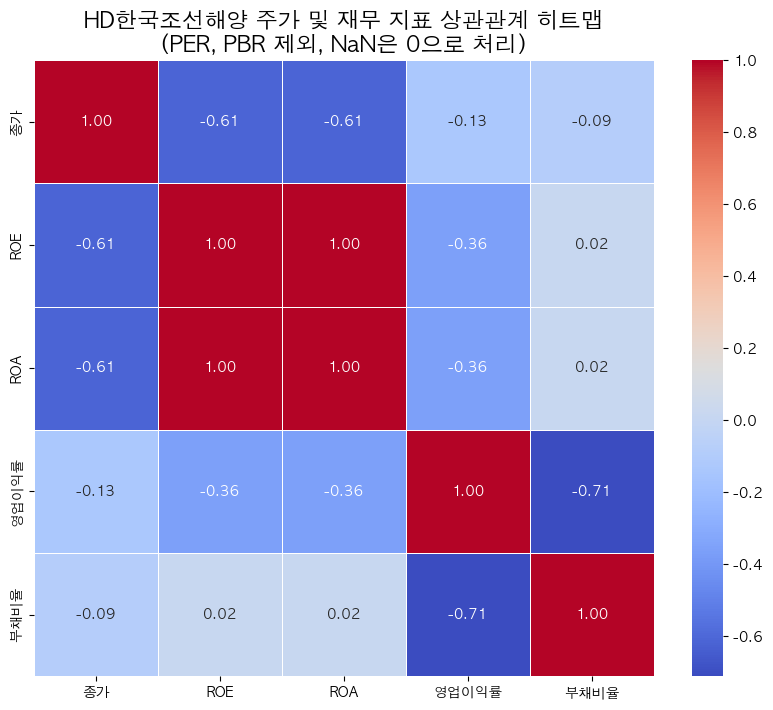

In [145]:
# 6.1. ÏÉÅÍ¥ÄÍ¥ÄÍ≥Ñ Îß§Ìä∏Î¶≠Ïä§ Í≥ÑÏÇ∞
# Ïù¥Ï†ú df_filled_zeroÎ•º ÏÇ¨Ïö©Ìï©ÎãàÎã§.
correlation_matrix = df_filled_zero.corr()

print("\nÏÉÅÍ¥ÄÍ¥ÄÍ≥Ñ Îß§Ìä∏Î¶≠Ïä§ (PER, PBR Ï†úÏô∏, NaNÏùÄ 0ÏúºÎ°ú Ï≤òÎ¶¨):")
print(correlation_matrix)

# 6.2. Seaborn ÌûàÌä∏Îßµ Í∑∏Î¶¨Í∏∞
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix,
            annot=True,
            cmap='coolwarm',
            fmt=".2f",
            linewidths=.5)
plt.title(f'{target_stock_name} Ï£ºÍ∞Ä Î∞è Ïû¨Î¨¥ ÏßÄÌëú ÏÉÅÍ¥ÄÍ¥ÄÍ≥Ñ ÌûàÌä∏Îßµ\n(PER, PBR Ï†úÏô∏, NaNÏùÄ 0ÏúºÎ°ú Ï≤òÎ¶¨)', fontsize=16)
plt.show()

In [174]:
# 3.1. 'Ï†úÏù¥ Ïä§ÏΩî ÌôÄÎî©Ïä§' Ï¢ÖÎ™© ÌïÑÌÑ∞ÎßÅ (PER, PBR Ìè¨Ìï®Îêú ÏõêÎ≥∏ ÏÉÅÌÉúÎ°ú)
target_stock_name = analysis_df['Ï¢ÖÎ™©Î™Ö'].iloc[0]
# Ïó¨Í∏∞ÏÑúÎäî Î™®Îì† ÏßÄÌëúÎ•º Í∞ÄÏ†∏ÏòµÎãàÎã§. (PER, PBR Ìè¨Ìï®)
df_stock_original = analysis_df[analysis_df['Ï¢ÖÎ™©Î™Ö'] == target_stock_name].copy()

# 3.2. ÎÇ†Ïßú Ïª¨ÎüºÎ™Ö Ï∂îÏ∂ú
date_cols_original = [col for col in df_stock_original.columns if col not in ['Ï¢ÖÎ™©Î™Ö', 'Íµ¨Î∂Ñ']]

# 3.3. 'Íµ¨Î∂Ñ' Ïª¨ÎüºÏùÑ Ïù∏Îç±Ïä§Î°ú ÏÑ§Ï†ïÌïòÍ≥†, ÎÇ†Ïßú Ïª¨ÎüºÏùÑ ÌîºÎ≤ó (Ï†ÑÏπò)
df_pivot_original = df_stock_original.set_index('Íµ¨Î∂Ñ')[date_cols_original].T
df_pivot_original.columns.name = None
df_pivot_original.index.name = 'ÎÇ†Ïßú'

# ÎÇ†Ïßú Ïù∏Îç±Ïä§Î•º datetime ÌòïÏãùÏúºÎ°ú Î≥ÄÌôò
df_pivot_original.index = pd.to_datetime(df_pivot_original.index)

print(f"\nÏû¨Íµ¨Ï°∞ÌôîÎêú '{target_stock_name}' Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑ (Î™®Îì† ÏßÄÌëú Ìè¨Ìï®) head:")
print(df_pivot_original.head())
print("\ndf_pivot_original info:")
df_pivot_original.info()

print("\nÏòÅÏóÖÏù¥ÏùµÎ•† Ïª¨ÎüºÏùò Í≤∞Ï∏°Ïπò Í∞úÏàò (NaN Ï≤òÎ¶¨ Ï†Ñ):")
print(df_pivot_original['ÏòÅÏóÖÏù¥ÏùµÎ•†'].isnull().sum())
print("\nÏòÅÏóÖÏù¥ÏùµÎ•† Ïª¨ÎüºÏùò Í≥†Ïú† Í∞í (NaN Ìè¨Ìï®):")
print(df_pivot_original['ÏòÅÏóÖÏù¥ÏùµÎ•†'].unique())


Ïû¨Íµ¨Ï°∞ÌôîÎêú 'HDÌïúÍµ≠Ï°∞ÏÑ†Ìï¥Ïñë' Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑ (Î™®Îì† ÏßÄÌëú Ìè¨Ìï®) head:
                  Ï¢ÖÍ∞Ä        PER       PBR       ROE       ROA    ÏòÅÏóÖÏù¥ÏùµÎ•†  \
ÎÇ†Ïßú                                                                       
2024-01-02  118500.0  27.820270  0.727399  2.614635  2.560307 -4.29154   
2024-01-03  113500.0  26.646419  0.696707  2.614635  2.560307 -4.29154   
2024-01-04  112000.0  26.294264  0.687499  2.614635  2.560307 -4.29154   
2024-01-05  110700.0  25.989063  0.679519  2.614635  2.560307 -4.29154   
2024-01-08  111900.0  26.270787  0.686885  2.614635  2.560307 -4.29154   

                Î∂ÄÏ±ÑÎπÑÏú®  
ÎÇ†Ïßú                    
2024-01-02  2.121944  
2024-01-03  2.121944  
2024-01-04  2.121944  
2024-01-05  2.121944  
2024-01-08  2.121944  

df_pivot_original info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 244 entries, 2024-01-02 to 2024-12-30
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  ----

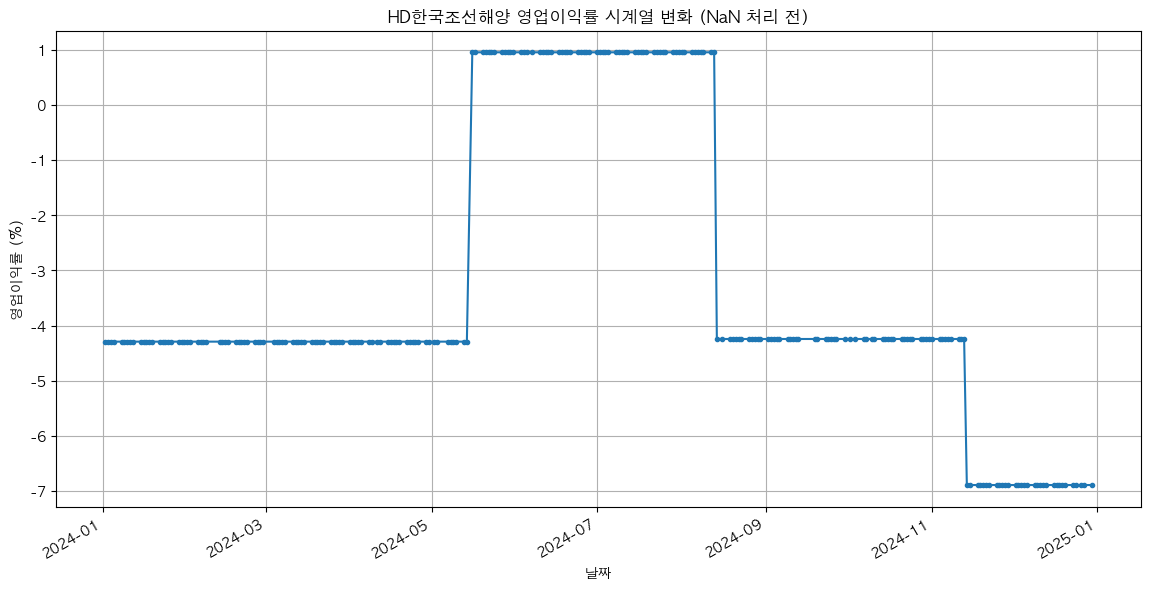

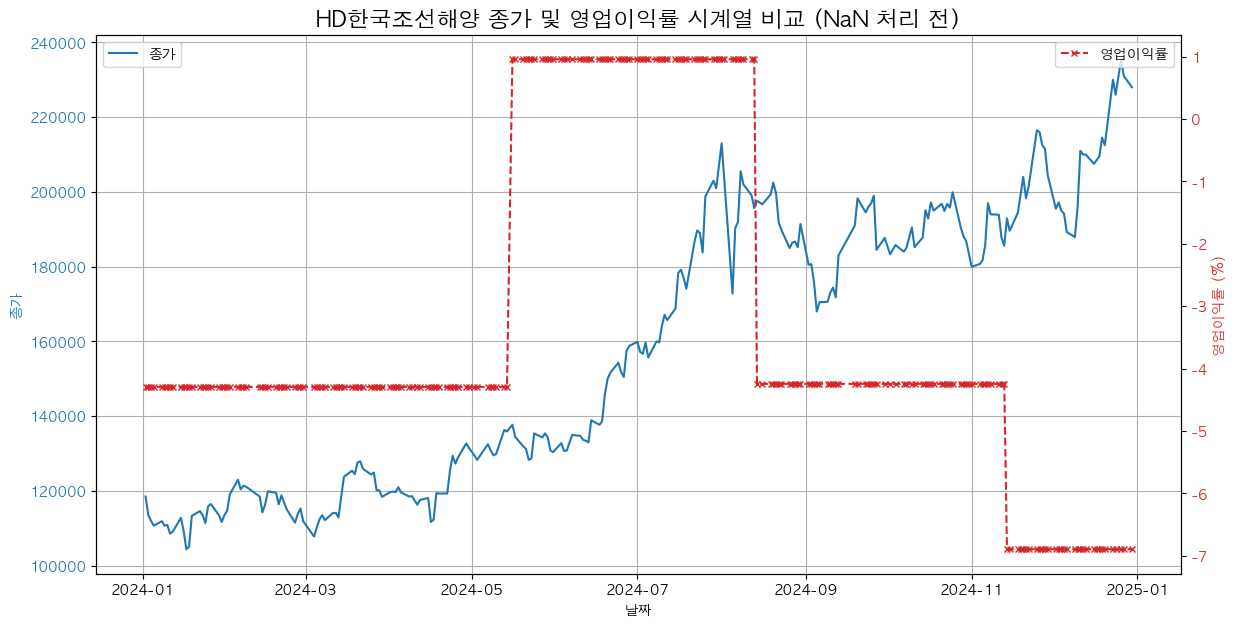

In [147]:
plt.figure(figsize=(14, 7))
# plot() Ìï®ÏàòÎäî NaN Í∞íÏùÑ ÏûêÎèôÏúºÎ°ú Í±¥ÎÑàÎõ∞Í≥† Í∑∏ÎûòÌîÑÎ•º Í∑∏Î¶ΩÎãàÎã§.
df_pivot_original['ÏòÅÏóÖÏù¥ÏùµÎ•†'].plot(title=f'{target_stock_name} ÏòÅÏóÖÏù¥ÏùµÎ•† ÏãúÍ≥ÑÏó¥ Î≥ÄÌôî (NaN Ï≤òÎ¶¨ Ï†Ñ)',
                                    grid=True,
                                    linestyle='-',
                                    marker='o', # Îç∞Ïù¥ÌÑ∞ Ìè¨Ïù∏Ìä∏ ÌëúÏãú
                                    markersize=3)
plt.ylabel('ÏòÅÏóÖÏù¥ÏùµÎ•† (%)')
plt.xlabel('ÎÇ†Ïßú')
plt.show()

# Ï∂îÍ∞ÄÏ†ÅÏúºÎ°ú, Ï¢ÖÍ∞ÄÏôÄ ÏòÅÏóÖÏù¥ÏùµÎ•†ÏùÑ Ìï®Íªò Í∑∏Î†§Î≥¥Îäî Í≤ÉÎèÑ Ï¢ãÏäµÎãàÎã§.
# Ï¢ÖÍ∞ÄÏùò Ïä§ÏºÄÏùºÏù¥ Îã§Î•¥ÎØÄÎ°ú, 2Í∞úÏùò YÏ∂ïÏùÑ ÏÇ¨Ïö©Ìï©ÎãàÎã§.
fig, ax1 = plt.subplots(figsize=(14, 7))

# Ï≤´ Î≤àÏß∏ YÏ∂ï: Ï¢ÖÍ∞Ä
color = 'tab:blue'
ax1.set_xlabel('ÎÇ†Ïßú')
ax1.set_ylabel('Ï¢ÖÍ∞Ä', color=color)
ax1.plot(df_pivot_original['Ï¢ÖÍ∞Ä'], color=color, label='Ï¢ÖÍ∞Ä', linestyle='-')
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(loc='upper left')
ax1.grid(True)

# Îëê Î≤àÏß∏ YÏ∂ï: ÏòÅÏóÖÏù¥ÏùµÎ•†
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('ÏòÅÏóÖÏù¥ÏùµÎ•† (%)', color=color)
ax2.plot(df_pivot_original['ÏòÅÏóÖÏù¥ÏùµÎ•†'], color=color, label='ÏòÅÏóÖÏù¥ÏùµÎ•†', linestyle='--', marker='x', markersize=4)
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc='upper right')

plt.title(f'{target_stock_name} Ï¢ÖÍ∞Ä Î∞è ÏòÅÏóÖÏù¥ÏùµÎ•† ÏãúÍ≥ÑÏó¥ ÎπÑÍµê (NaN Ï≤òÎ¶¨ Ï†Ñ)', fontsize=16)
plt.show()

In [148]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['axes.unicode_minus'] = False

In [149]:
# analysis_dfÍ∞Ä Ïù¥ÎØ∏ Î°úÎìúÎêòÏñ¥ ÏûàÎã§Í≥† Í∞ÄÏ†ïÌï©ÎãàÎã§.
# ÎßåÏïΩ Ïù¥ ÏÖÄÏóêÏÑú 'analysis_df is not defined' ÏóêÎü¨Í∞Ä Î∞úÏÉùÌïúÎã§Î©¥,
# Ïù¥Ï†Ñ ÎåÄÌôîÏóêÏÑú analysis_dfÎ•º Î°úÎìúÌïòÎäî ÏΩîÎìúÎ•º Îã§Ïãú Ïã§ÌñâÌï¥Ï£ºÏÑ∏Ïöî.
# Ïòà: analysis_df = pd.read_csv('your_data.csv')

# --- 'Ï†úÏù¥ Ïä§ÏΩî ÌôÄÎî©Ïä§' Îç∞Ïù¥ÌÑ∞ Ïû¨Íµ¨Ï°∞Ìôî Î∞è NaN 0 Ï≤òÎ¶¨ Í≥ºÏ†ï ---
# Ïù¥ Î∂ÄÎ∂ÑÏùÄ Ïù¥Ï†Ñ Îã®Í≥ÑÏóêÏÑú Ïù¥ÎØ∏ Ïã§ÌñâÌñàÏßÄÎßå, ÏΩîÎìúÏùò Ïó∞ÏÜçÏÑ±ÏùÑ ÏúÑÌï¥ Îã§Ïãú Î™ÖÏãúÌï©ÎãàÎã§.

target_stock_name = analysis_df['Ï¢ÖÎ™©Î™Ö'].iloc[0]
excluded_metrics = ['PER', 'PBR']

# 'Ï†úÏù¥ Ïä§ÏΩî ÌôÄÎî©Ïä§' Ï¢ÖÎ™© ÌïÑÌÑ∞ÎßÅ Î∞è PER, PBR Ï†úÏô∏
df_stock = analysis_df[
    (analysis_df['Ï¢ÖÎ™©Î™Ö'] == target_stock_name) &
    (~analysis_df['Íµ¨Î∂Ñ'].isin(excluded_metrics))
].copy()

# ÎÇ†Ïßú Ïª¨ÎüºÎ™Ö Ï∂îÏ∂ú
date_cols = [col for col in df_stock.columns if col not in ['Ï¢ÖÎ™©Î™Ö', 'Íµ¨Î∂Ñ']]

# 'Íµ¨Î∂Ñ' Ïª¨ÎüºÏùÑ Ïù∏Îç±Ïä§Î°ú ÏÑ§Ï†ïÌïòÍ≥†, ÎÇ†Ïßú Ïª¨ÎüºÏùÑ ÌîºÎ≤ó (Ï†ÑÏπò)
df_pivot = df_stock.set_index('Íµ¨Î∂Ñ')[date_cols].T
df_pivot.columns.name = None
df_pivot.index.name = 'ÎÇ†Ïßú'

# ÎÇ†Ïßú Ïù∏Îç±Ïä§Î•º datetime ÌòïÏãùÏúºÎ°ú Î≥ÄÌôò
df_pivot.index = pd.to_datetime(df_pivot.index)

# Î™®Îì† NaN Í∞íÏùÑ 0ÏúºÎ°ú ÎåÄÏ≤¥
df_filled_zero = df_pivot.fillna(0)

print("\nÌöåÍ∑Ä Î∂ÑÏÑùÏóê ÏÇ¨Ïö©Îê† 'Ï†úÏù¥ Ïä§ÏΩî ÌôÄÎî©Ïä§' Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑ (df_filled_zero) head:")
print(df_filled_zero.head())
print("\ndf_filled_zero info:")
df_filled_zero.info()

# ÌäπÏßï(X)Í≥º ÌÉÄÍ≤ü(y) Î∂ÑÎ¶¨
X = df_filled_zero[['ROE', 'ROA', 'ÏòÅÏóÖÏù¥ÏùµÎ•†', 'Î∂ÄÏ±ÑÎπÑÏú®']]
y = df_filled_zero['Ï¢ÖÍ∞Ä']

print("\nFeatures (X) head:")
print(X.head())
print("\nTarget (y) head:")
print(y.head())


ÌöåÍ∑Ä Î∂ÑÏÑùÏóê ÏÇ¨Ïö©Îê† 'Ï†úÏù¥ Ïä§ÏΩî ÌôÄÎî©Ïä§' Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑ (df_filled_zero) head:
                  Ï¢ÖÍ∞Ä       ROE       ROA    ÏòÅÏóÖÏù¥ÏùµÎ•†      Î∂ÄÏ±ÑÎπÑÏú®
ÎÇ†Ïßú                                                         
2024-01-02  118500.0  2.614635  2.560307 -4.29154  2.121944
2024-01-03  113500.0  2.614635  2.560307 -4.29154  2.121944
2024-01-04  112000.0  2.614635  2.560307 -4.29154  2.121944
2024-01-05  110700.0  2.614635  2.560307 -4.29154  2.121944
2024-01-08  111900.0  2.614635  2.560307 -4.29154  2.121944

df_filled_zero info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 244 entries, 2024-01-02 to 2024-12-30
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Ï¢ÖÍ∞Ä      244 non-null    float64
 1   ROE     244 non-null    float64
 2   ROA     244 non-null    float64
 3   ÏòÅÏóÖÏù¥ÏùµÎ•†   244 non-null    float64
 4   Î∂ÄÏ±ÑÎπÑÏú®    244 non-null    float64
dtypes: float64(5)
memory usage:

In [150]:
# ÌõàÎ†® ÏÑ∏Ìä∏ÏôÄ ÌÖåÏä§Ìä∏ ÏÑ∏Ìä∏ ÎπÑÏú® ÏÑ§Ï†ï (Ïòà: 80% ÌõàÎ†®, 20% ÌÖåÏä§Ìä∏)
train_size = int(len(X) * 0.8)

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"\nÌõàÎ†® ÏÑ∏Ìä∏ ÌÅ¨Í∏∞: {len(X_train)} Í∞ú")
print(f"ÌÖåÏä§Ìä∏ ÏÑ∏Ìä∏ ÌÅ¨Í∏∞: {len(X_test)} Í∞ú")


ÌõàÎ†® ÏÑ∏Ìä∏ ÌÅ¨Í∏∞: 195 Í∞ú
ÌÖåÏä§Ìä∏ ÏÑ∏Ìä∏ ÌÅ¨Í∏∞: 49 Í∞ú


In [151]:
scaler = StandardScaler()

# ÌõàÎ†® Îç∞Ïù¥ÌÑ∞Ïóê fit_transform Ï†ÅÏö©
X_train_scaled = scaler.fit_transform(X_train)
# ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞Ïóê transform Ï†ÅÏö© (ÌõàÎ†® Îç∞Ïù¥ÌÑ∞Ïùò Ïä§ÏºÄÏùºÎßÅ Í∏∞Ï§Ä ÏÇ¨Ïö©)
X_test_scaled = scaler.transform(X_test)

# Ïä§ÏºÄÏùºÎßÅÎêú Îç∞Ïù¥ÌÑ∞Î•º Îã§Ïãú DataFrameÏúºÎ°ú Î≥ÄÌôò (Î∂ÑÏÑù Ïö©Ïù¥ÏÑ±ÏùÑ ÏúÑÌï¥)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns, index=X_test.index)

print("\nÏä§ÏºÄÏùºÎßÅÎêú ÌõàÎ†® Îç∞Ïù¥ÌÑ∞ (X_train_scaled) head:")
print(X_train_scaled.head())


Ïä§ÏºÄÏùºÎßÅÎêú ÌõàÎ†® Îç∞Ïù¥ÌÑ∞ (X_train_scaled) head:
                 ROE       ROA    ÏòÅÏóÖÏù¥ÏùµÎ•†      Î∂ÄÏ±ÑÎπÑÏú®
ÎÇ†Ïßú                                               
2024-01-02  0.895391  0.894436 -0.69709  1.080073
2024-01-03  0.895391  0.894436 -0.69709  1.080073
2024-01-04  0.895391  0.894436 -0.69709  1.080073
2024-01-05  0.895391  0.894436 -0.69709  1.080073
2024-01-08  0.895391  0.894436 -0.69709  1.080073


In [152]:
model = LinearRegression()

# Î™®Îç∏ ÌïôÏäµ
model.fit(X_train_scaled, y_train)

print("\nÏÑ†Ìòï ÌöåÍ∑Ä Î™®Îç∏ ÌïôÏäµ ÏôÑÎ£å.")


ÏÑ†Ìòï ÌöåÍ∑Ä Î™®Îç∏ ÌïôÏäµ ÏôÑÎ£å.


In [153]:
# ÌÖåÏä§Ìä∏ ÏÑ∏Ìä∏Ïóê ÎåÄÌïú ÏòàÏ∏°
y_pred = model.predict(X_test_scaled)

# Î™®Îç∏ ÏÑ±Îä• ÌèâÍ∞Ä
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse) # Root Mean Squared Error
r2 = r2_score(y_test, y_pred) # R-squared

print(f"\nÎ™®Îç∏ ÏÑ±Îä• ÌèâÍ∞Ä (ÌÖåÏä§Ìä∏ ÏÑ∏Ìä∏):")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared (R2 Score): {r2:.2f}")

# ÌöåÍ∑Ä Í≥ÑÏàò ÌôïÏù∏ (Í∞Å ÏßÄÌëúÏùò ÏòÅÌñ•Î†•)
coefficients = pd.DataFrame({'Feature': X.columns, 'Coefficient': model.coef_})
print("\nÍ∞Å ÏßÄÌëúÏùò ÌöåÍ∑Ä Í≥ÑÏàò:")
print(coefficients.sort_values(by='Coefficient', ascending=False))

# Ï†àÌé∏ (intercept) ÌôïÏù∏
print(f"\nÎ™®Îç∏ Ï†àÌé∏ (Intercept): {model.intercept_:.2f}")


Î™®Îç∏ ÏÑ±Îä• ÌèâÍ∞Ä (ÌÖåÏä§Ìä∏ ÏÑ∏Ìä∏):
Mean Squared Error (MSE): 10809807803.03
Root Mean Squared Error (RMSE): 103970.23
R-squared (R2 Score): -55.78

Í∞Å ÏßÄÌëúÏùò ÌöåÍ∑Ä Í≥ÑÏàò:
  Feature   Coefficient
1     ROA  -1217.843421
0     ROE  -1308.071656
2   ÏòÅÏóÖÏù¥ÏùµÎ•† -14296.112970
3    Î∂ÄÏ±ÑÎπÑÏú® -33486.287787

Î™®Îç∏ Ï†àÌé∏ (Intercept): 146983.59


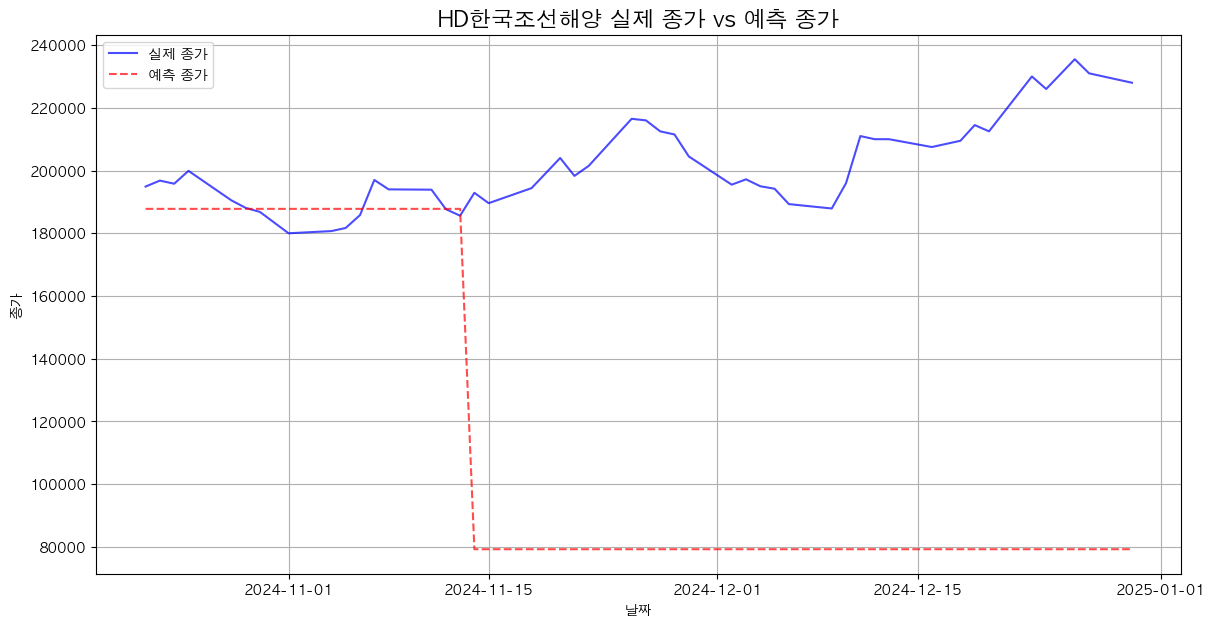

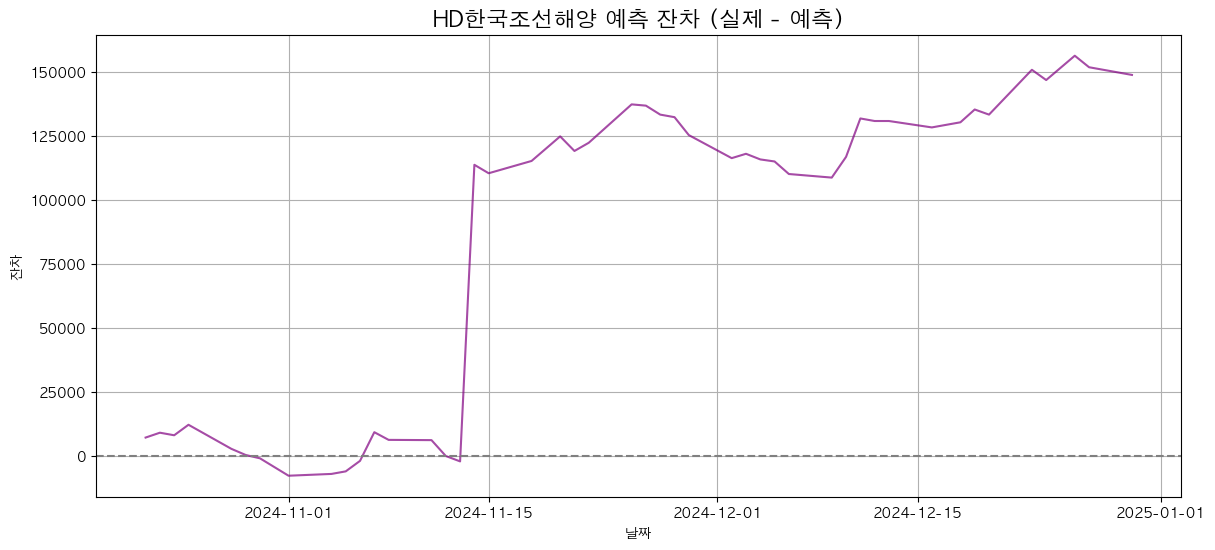

In [154]:
plt.figure(figsize=(14, 7))
plt.plot(y_test.index, y_test, label='Ïã§Ï†ú Ï¢ÖÍ∞Ä', color='blue', alpha=0.7)
plt.plot(y_test.index, y_pred, label='ÏòàÏ∏° Ï¢ÖÍ∞Ä', color='red', linestyle='--', alpha=0.7)
plt.title(f'{target_stock_name} Ïã§Ï†ú Ï¢ÖÍ∞Ä vs ÏòàÏ∏° Ï¢ÖÍ∞Ä', fontsize=16)
plt.xlabel('ÎÇ†Ïßú')
plt.ylabel('Ï¢ÖÍ∞Ä')
plt.legend()
plt.grid(True)
plt.show()

# ÏûîÏ∞®(Residual) Î∂ÑÏÑù
residuals = y_test - y_pred
plt.figure(figsize=(14, 6))
plt.plot(y_test.index, residuals, color='purple', alpha=0.7)
plt.axhline(y=0, color='gray', linestyle='--')
plt.title(f'{target_stock_name} ÏòàÏ∏° ÏûîÏ∞® (Ïã§Ï†ú - ÏòàÏ∏°)', fontsize=16)
plt.xlabel('ÎÇ†Ïßú')
plt.ylabel('ÏûîÏ∞®')
plt.grid(True)
plt.show()

In [155]:
import pandas as pd
import numpy as np

# analysis_dfÍ∞Ä Ïù¥ÎØ∏ Î°úÎìúÎêòÏñ¥ ÏûàÎã§Í≥† Í∞ÄÏ†ïÌï©ÎãàÎã§.
# ÎßåÏïΩ Ïù¥ ÏÖÄÏóêÏÑú 'analysis_df is not defined' ÏóêÎü¨Í∞Ä Î∞úÏÉùÌïúÎã§Î©¥,
# Ïù¥Ï†Ñ ÎåÄÌôîÏóêÏÑú analysis_dfÎ•º Î°úÎìúÌïòÎäî ÏΩîÎìúÎ•º Îã§Ïãú Ïã§ÌñâÌï¥Ï£ºÏÑ∏Ïöî.
# Ïòà: analysis_df = pd.read_csv('your_data.csv')

# --- 1. analysis_dfÏùò ÎÇ†Ïßú Ïª¨ÎüºÏùÑ Î™®Îëê Ï∞æÍ∏∞ ---
# 'Ï¢ÖÎ™©Î™Ö'Í≥º 'Íµ¨Î∂Ñ'ÏùÑ Ï†úÏô∏Ìïú Î™®Îì† Ïª¨ÎüºÏù¥ ÎÇ†Ïßú Ïª¨ÎüºÏûÖÎãàÎã§.
date_cols = [col for col in analysis_df.columns if col not in ['Ï¢ÖÎ™©Î™Ö', 'Íµ¨Î∂Ñ']]

# --- 2. Long FormatÏúºÎ°ú Î≥ÄÌôò (stack) ---
# Î™®Îì† ÎÇ†Ïßú Ïª¨ÎüºÏùÑ ÌïòÎÇòÏùò 'ÎÇ†Ïßú' Ïª¨ÎüºÏúºÎ°ú ÏåìÏïÑ Ïò¨Î¶ΩÎãàÎã§.
df_long = analysis_df.set_index(['Ï¢ÖÎ™©Î™Ö', 'Íµ¨Î∂Ñ'])[date_cols].stack().reset_index()
df_long.columns = ['Ï¢ÖÎ™©Î™Ö', 'Íµ¨Î∂Ñ', 'ÎÇ†Ïßú', 'Í∞í'] # Ïª¨ÎüºÎ™Ö Î≥ÄÍ≤Ω

# 'ÎÇ†Ïßú' Ïª¨ÎüºÏùÑ datetime ÌòïÏãùÏúºÎ°ú Î≥ÄÌôò
df_long['ÎÇ†Ïßú'] = pd.to_datetime(df_long['ÎÇ†Ïßú'])

print("Long FormatÏúºÎ°ú Î≥ÄÌôòÎêú Îç∞Ïù¥ÌÑ∞ (df_long) head:")
print(df_long.head())
print("\ndf_long info:")
df_long.info()

# --- 3. Wide FormatÏúºÎ°ú Î≥ÄÌôò (unstack/pivot) ---
# 'Íµ¨Î∂Ñ' Ïª¨ÎüºÏùò Í∞í(Ï¢ÖÍ∞Ä, PER Îì±)ÏùÑ ÏÉàÎ°úÏö¥ Ïª¨ÎüºÏúºÎ°ú ÎßåÎì≠ÎãàÎã§.
# 'ÎÇ†Ïßú'ÏôÄ 'Ï¢ÖÎ™©Î™Ö'ÏùÑ Í∏∞Ï§ÄÏúºÎ°ú ÌîºÎ≤óÌï©ÎãàÎã§.
df_wide = df_long.pivot_table(index=['ÎÇ†Ïßú', 'Ï¢ÖÎ™©Î™Ö'], columns='Íµ¨Î∂Ñ', values='Í∞í')

# Ïª¨ÎüºÎ™Ö Ï†ïÎ¶¨
df_wide = df_wide.reset_index()
df_wide.columns.name = None # Ïª¨ÎüºÎ™Ö Ïù∏Îç±Ïä§ Ïù¥Î¶Ñ Ï†úÍ±∞

# Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑ Ïª¨Îüº ÏàúÏÑú Ï°∞Ï†ï (Î≥¥Í∏∞ Ï¢ãÍ≤å)
# Î™®Îì† ÏßÄÌëúÍ∞Ä Îã§ ÏûàÏùÑ Í≤ΩÏö∞Ïùò Ïª¨Îüº ÏàúÏÑú ÏßÄÏ†ï
all_metrics = ['Ï¢ÖÍ∞Ä', 'PER', 'PBR', 'ROE', 'ROA', 'ÏòÅÏóÖÏù¥ÏùµÎ•†', 'Î∂ÄÏ±ÑÎπÑÏú®']
# Ïã§Ï†ú df_wideÏóê ÏûàÎäî Ïª¨ÎüºÎßå ÏÇ¨Ïö©ÌïòÏó¨ ÏàúÏÑú Ï°∞Ï†ï
ordered_cols = ['ÎÇ†Ïßú', 'Ï¢ÖÎ™©Î™Ö'] + [metric for metric in all_metrics if metric in df_wide.columns]
df_wide = df_wide[ordered_cols]

print("\nWide FormatÏúºÎ°ú Ïû¨Íµ¨Ï°∞ÌôîÎêú Îç∞Ïù¥ÌÑ∞ (df_wide) head:")
print(df_wide.head())
print("\ndf_wide info:")
df_wide.info()

# --- 4. PER, PBR Ïª¨Îüº Ï†úÏô∏ Î∞è NaN 0 Ï≤òÎ¶¨ ---
# Ïù¥Ï†ú Î™®Îì† Ï¢ÖÎ™©Ïóê ÎåÄÌï¥ ÏùºÍ¥ÑÏ†ÅÏúºÎ°ú Ï†ÅÏö©Ìï©ÎãàÎã§.
# Ï†úÏô∏Ìï† ÏßÄÌëú Î¶¨Ïä§Ìä∏
metrics_to_exclude = ['PER', 'PBR']

# Ìï¥Îãπ ÏßÄÌëú Ïª¨ÎüºÏù¥ Ï°¥Ïû¨ÌïòÎ©¥ Ï†úÏô∏
for metric in metrics_to_exclude:
    if metric in df_wide.columns:
        df_wide = df_wide.drop(columns=[metric])
        print(f"'{metric}' Ïª¨ÎüºÏù¥ Ï†úÍ±∞ÎêòÏóàÏäµÎãàÎã§.")

# ÎÇòÎ®∏ÏßÄ Î™®Îì† Ïà´Ïûê Ïª¨ÎüºÏóê ÎåÄÌï¥ NaN Í∞íÏùÑ 0ÏúºÎ°ú Ï±ÑÏõÅÎãàÎã§.
# 'ÎÇ†Ïßú'ÏôÄ 'Ï¢ÖÎ™©Î™Ö' Ïª¨ÎüºÏùÄ Ï†úÏô∏ÌïòÍ≥† Ïà´ÏûêÌòï Ïª¨ÎüºÏóêÎßå Ï†ÅÏö©
numeric_cols = df_wide.select_dtypes(include=np.number).columns
df_final = df_wide.copy() # ÏõêÎ≥∏ Î≥¥Ï°¥ÏùÑ ÏúÑÌï¥ Î≥µÏÇ¨Î≥∏ ÏÉùÏÑ±
df_final[numeric_cols] = df_final[numeric_cols].fillna(0)

print("\nPER, PBR Ï†úÏô∏ Î∞è NaN 0 Ï≤òÎ¶¨ ÌõÑ ÏµúÏ¢Ö Îç∞Ïù¥ÌÑ∞ (df_final) head:")
print(df_final.head())
print("\ndf_final info:")
df_final.info()
print("\ndf_finalÏùò Í≤∞Ï∏°Ïπò ÌôïÏù∏:")
print(df_final.isnull().sum())
df_final

Long FormatÏúºÎ°ú Î≥ÄÌôòÎêú Îç∞Ïù¥ÌÑ∞ (df_long) head:
        Ï¢ÖÎ™©Î™Ö  Íµ¨Î∂Ñ         ÎÇ†Ïßú         Í∞í
0  HDÌïúÍµ≠Ï°∞ÏÑ†Ìï¥Ïñë  Ï¢ÖÍ∞Ä 2024-01-02  118500.0
1  HDÌïúÍµ≠Ï°∞ÏÑ†Ìï¥Ïñë  Ï¢ÖÍ∞Ä 2024-01-03  113500.0
2  HDÌïúÍµ≠Ï°∞ÏÑ†Ìï¥Ïñë  Ï¢ÖÍ∞Ä 2024-01-04  112000.0
3  HDÌïúÍµ≠Ï°∞ÏÑ†Ìï¥Ïñë  Ï¢ÖÍ∞Ä 2024-01-05  110700.0
4  HDÌïúÍµ≠Ï°∞ÏÑ†Ìï¥Ïñë  Ï¢ÖÍ∞Ä 2024-01-08  111900.0

df_long info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168332 entries, 0 to 168331
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   Ï¢ÖÎ™©Î™Ö     168332 non-null  object        
 1   Íµ¨Î∂Ñ      168332 non-null  object        
 2   ÎÇ†Ïßú      168332 non-null  datetime64[ns]
 3   Í∞í       168332 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 5.1+ MB

Wide FormatÏúºÎ°ú Ïû¨Íµ¨Ï°∞ÌôîÎêú Îç∞Ïù¥ÌÑ∞ (df_wide) head:
          ÎÇ†Ïßú        Ï¢ÖÎ™©Î™Ö        Ï¢ÖÍ∞Ä        PER       PBR        ROE      

ÎÇ†Ïßú        Ï¢ÖÎ™©Î™Ö        Ï¢ÖÍ∞Ä        ROE       ROA      ÏòÅÏóÖÏù¥ÏùµÎ•†  \
0     2024-01-02       GSÍ±¥ÏÑ§   14730.0 -13.775571 -4.343823  -7.564895   
1     2024-01-02  HDCÌòÑÎåÄÏÇ∞ÏóÖÍ∞úÎ∞ú   14210.0   5.581413  2.541921   4.548237   
2     2024-01-02   HDÌïúÍµ≠Ï°∞ÏÑ†Ìï¥Ïñë  118500.0   2.614635  2.560307  -4.291540   
3     2024-01-02       HDÌòÑÎåÄ   62600.0  13.037357  8.474707  83.628112   
4     2024-01-02      HJÏ§ëÍ≥µÏóÖ    4040.0 -33.242240 -3.933024  -5.007713   
...          ...        ...       ...        ...       ...        ...   
25127 2024-12-30       ÌôîÏäπÏù∏Îçî    4450.0   2.673919  1.372287   2.218714   
25128 2024-12-30        Ìú¥ÎãàÎìú    7710.0   3.304813  2.132344   6.741814   
25129 2024-12-30      Ìú¥Î¶ºÏóêÏù¥ÌÖç     564.0  -0.751278 -0.631506   3.638788   
25130 2024-12-30       Ìú¥Î©îÎîïÏä§   42250.0   4.197535  3.859098  24.748460   
25131 2024-12-30       Ìù•Íµ¨ÏÑùÏú†   12490.0   0.678986  0.585999   0.639497   

             Î∂ÄÏ±ÑÎπÑÏú®  
0      217.130152  
1      119.574583  
2        2.121944  
3       53.838434  
4      745.208240  
...           ...  
25127   94.851288  
25128   54.984981  
25129   18.966073  
25130    8.769847  
25131   15.868206  

[25132 rows x 7 columns]

In [156]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


plt.rcParams['axes.unicode_minus'] = False

In [157]:
# df_final Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑÏù¥ Ïù¥ÎØ∏ Î©îÎ™®Î¶¨Ïóê ÏûàÎã§Í≥† Í∞ÄÏ†ïÌï©ÎãàÎã§.
# ÎßåÏïΩ Ïù¥ ÏÖÄÏóêÏÑú 'df_final is not defined' ÏóêÎü¨Í∞Ä Î∞úÏÉùÌïúÎã§Î©¥,
# Ïù¥Ï†Ñ ÎåÄÌôîÏóêÏÑú df_finalÏùÑ ÏÉùÏÑ±ÌïòÎäî ÏΩîÎìúÎ•º Îã§Ïãú Ïã§ÌñâÌï¥Ï£ºÏÑ∏Ïöî.
# (Îã®Í≥Ñ 1: Îç∞Ïù¥ÌÑ∞ Ïû¨Íµ¨Ï°∞Ìôî Î∂ÄÎ∂Ñ)
print("Ï¢ÖÎ™©Î≥Ñ ÏÉÅÍ¥ÄÍ¥ÄÍ≥Ñ Î∂ÑÏÑùÏùÑ ÏúÑÌïú df_final head:")
print(df_final.head())
print("\ndf_final info:")
df_final.info()

Ï¢ÖÎ™©Î≥Ñ ÏÉÅÍ¥ÄÍ¥ÄÍ≥Ñ Î∂ÑÏÑùÏùÑ ÏúÑÌïú df_final head:
          ÎÇ†Ïßú        Ï¢ÖÎ™©Î™Ö        Ï¢ÖÍ∞Ä        ROE       ROA      ÏòÅÏóÖÏù¥ÏùµÎ•†        Î∂ÄÏ±ÑÎπÑÏú®
0 2024-01-02       GSÍ±¥ÏÑ§   14730.0 -13.775571 -4.343823  -7.564895  217.130152
1 2024-01-02  HDCÌòÑÎåÄÏÇ∞ÏóÖÍ∞úÎ∞ú   14210.0   5.581413  2.541921   4.548237  119.574583
2 2024-01-02   HDÌïúÍµ≠Ï°∞ÏÑ†Ìï¥Ïñë  118500.0   2.614635  2.560307  -4.291540    2.121944
3 2024-01-02       HDÌòÑÎåÄ   62600.0  13.037357  8.474707  83.628112   53.838434
4 2024-01-02      HJÏ§ëÍ≥µÏóÖ    4040.0 -33.242240 -3.933024  -5.007713  745.208240

df_final info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25132 entries, 0 to 25131
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ÎÇ†Ïßú      25132 non-null  datetime64[ns]
 1   Ï¢ÖÎ™©Î™Ö     25132 non-null  object        
 2   Ï¢ÖÍ∞Ä      25132 non-null  float64       
 3   ROE     25132 non-null  float64       
 4   

In [158]:
all_stocks = df_final['Ï¢ÖÎ™©Î™Ö'].unique()
print(f"\nÎ∂ÑÏÑùÌï† Ï¥ù Ï¢ÖÎ™© Ïàò: {len(all_stocks)}")
print(f"Î∂ÑÏÑùÌï† Ï¢ÖÎ™© Î¶¨Ïä§Ìä∏: {all_stocks[:5]} ... (ÏùºÎ∂ÄÎßå ÌëúÏãú)") # ÎÑàÎ¨¥ ÎßéÏúºÎ©¥ ÏùºÎ∂ÄÎßå Ï∂úÎ†•


Î∂ÑÏÑùÌï† Ï¥ù Ï¢ÖÎ™© Ïàò: 103
Î∂ÑÏÑùÌï† Ï¢ÖÎ™© Î¶¨Ïä§Ìä∏: ['GSÍ±¥ÏÑ§' 'HDCÌòÑÎåÄÏÇ∞ÏóÖÍ∞úÎ∞ú' 'HDÌïúÍµ≠Ï°∞ÏÑ†Ìï¥Ïñë' 'HDÌòÑÎåÄ' 'HJÏ§ëÍ≥µÏóÖ'] ... (ÏùºÎ∂ÄÎßå ÌëúÏãú)



Î™®Îì† Ï¢ÖÎ™©Ïùò 'Ï¢ÖÍ∞Ä'ÏôÄ Ïû¨Î¨¥ ÏßÄÌëú Í∞Ñ ÏÉÅÍ¥ÄÍ¥ÄÍ≥Ñ ÏöîÏïΩ (df_correlations):
                ROE       ROA     ÏòÅÏóÖÏù¥ÏùµÎ•†      Î∂ÄÏ±ÑÎπÑÏú®
Ï¢ÖÎ™©Î™Ö                                              
GSÍ±¥ÏÑ§       0.447839  0.455469  0.649361 -0.603106
HDCÌòÑÎåÄÏÇ∞ÏóÖÍ∞úÎ∞ú -0.482019 -0.499811  0.612235  0.507965
HDÌïúÍµ≠Ï°∞ÏÑ†Ìï¥Ïñë  -0.613590 -0.612761 -0.134087 -0.087242
HDÌòÑÎåÄ      -0.614113 -0.620203 -0.522240 -0.462331
HJÏ§ëÍ≥µÏóÖ      0.338858  0.366839  0.557554 -0.621225

Ï¥ù 103Í∞ú Ï¢ÖÎ™©Ïùò ÏÉÅÍ¥ÄÍ¥ÄÍ≥ÑÍ∞Ä Í≥ÑÏÇ∞ÎêòÏóàÏäµÎãàÎã§.


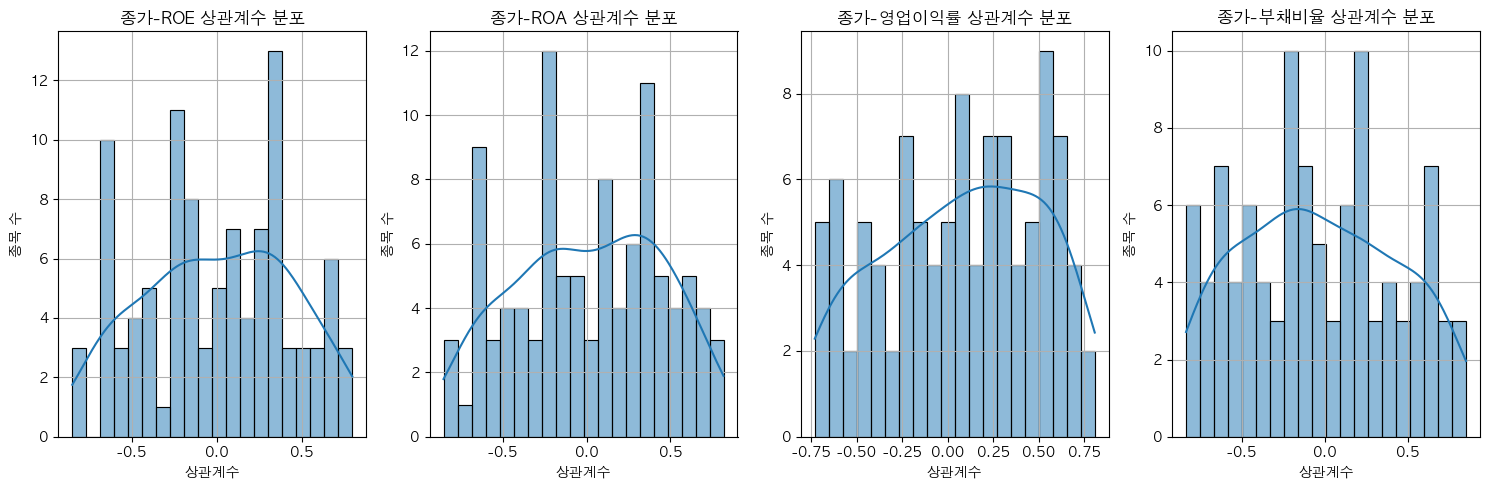

In [159]:
# ÏÉÅÍ¥ÄÍ¥ÄÍ≥Ñ Í≤∞Í≥ºÎ•º Ï†ÄÏû•Ìï† ÎîïÏÖîÎÑàÎ¶¨
correlation_results = {}

# Î∂ÑÏÑùÌï† ÏßÄÌëúÎì§ (Ï¢ÖÍ∞ÄÎ•º Ï†úÏô∏Ìïú ÌäπÏßï ÏßÄÌëú)
features = ['ROE', 'ROA', 'ÏòÅÏóÖÏù¥ÏùµÎ•†', 'Î∂ÄÏ±ÑÎπÑÏú®']
target = 'Ï¢ÖÍ∞Ä'

# Í∞Å Ï¢ÖÎ™©Î≥ÑÎ°ú Î∞òÎ≥µ
for stock_name in all_stocks:
    # Ìï¥Îãπ Ï¢ÖÎ™©Ïùò Îç∞Ïù¥ÌÑ∞Îßå ÌïÑÌÑ∞ÎßÅ
    df_stock = df_final[df_final['Ï¢ÖÎ™©Î™Ö'] == stock_name].copy()

    # ÏÉÅÍ¥ÄÍ¥ÄÍ≥Ñ Í≥ÑÏÇ∞ÏùÑ ÏúÑÌïú Ïà´ÏûêÌòï Ïª¨ÎüºÎßå ÏÑ†ÌÉù
    # Ï¢ÖÍ∞ÄÏôÄ ÌäπÏßï ÏßÄÌëúÍ∞Ä Î™®Îëê ÏûàÎäîÏßÄ ÌôïÏù∏ (Í≤∞Ï∏°Ïπò Ï≤òÎ¶¨ ÌõÑ Îç∞Ïù¥ÌÑ∞Í∞Ä Î∂ÄÏ°±Ìï† Ïàò ÏûàÏùå)
    cols_for_corr = [target] + [f for f in features if f in df_stock.columns]

    if len(df_stock) > 1 and all(col in df_stock.columns for col in cols_for_corr): # Îç∞Ïù¥ÌÑ∞Í∞Ä ÏµúÏÜå 2Í∞ú Ïù¥ÏÉÅÏù¥Í≥† ÌïÑÏöîÌïú Ïª¨ÎüºÏù¥ ÏûàÎäîÏßÄ ÌôïÏù∏
        # ÏÉÅÍ¥ÄÍ¥ÄÍ≥Ñ Îß§Ìä∏Î¶≠Ïä§ Í≥ÑÏÇ∞
        corr_matrix = df_stock[cols_for_corr].corr()

        # 'Ï¢ÖÍ∞Ä'ÏôÄ Í∞Å ÏßÄÌëú Í∞ÑÏùò ÏÉÅÍ¥ÄÍ≥ÑÏàòÎßå Ï∂îÏ∂ú
        if target in corr_matrix.index and len(corr_matrix.columns) > 1:
            stock_corr = corr_matrix.loc[target, features].to_dict()
            correlation_results[stock_name] = stock_corr
        else:
            print(f"Ï£ºÏùò: '{stock_name}' Ï¢ÖÎ™©ÏùÄ ÏÉÅÍ¥ÄÍ¥ÄÍ≥ÑÎ•º Í≥ÑÏÇ∞ÌïòÍ∏∞Ïóê Ï∂©Î∂ÑÌïú Îç∞Ïù¥ÌÑ∞Í∞Ä ÏóÜÍ±∞ÎÇò, 'Ï¢ÖÍ∞Ä' Ïª¨ÎüºÏù¥ ÏóÜÏäµÎãàÎã§. Í±¥ÎÑàÎúÅÎãàÎã§.")
    else:
        print(f"Ï£ºÏùò: '{stock_name}' Ï¢ÖÎ™©ÏùÄ Îç∞Ïù¥ÌÑ∞ Ìè¨Ïù∏Ìä∏Í∞Ä Î∂ÄÏ°±ÌïòÏó¨ ÏÉÅÍ¥ÄÍ¥ÄÍ≥ÑÎ•º Í≥ÑÏÇ∞Ìï† Ïàò ÏóÜÏäµÎãàÎã§. (Îç∞Ïù¥ÌÑ∞ Ïàò: {len(df_stock)})")

# Í≤∞Í≥ºÎ•º DataFrameÏúºÎ°ú Î≥ÄÌôòÌïòÏó¨ Î≥¥Í∏∞ ÏâΩÍ≤å ÎßåÎì≠ÎãàÎã§.
df_correlations = pd.DataFrame.from_dict(correlation_results, orient='index')
df_correlations.index.name = 'Ï¢ÖÎ™©Î™Ö'

print("\nÎ™®Îì† Ï¢ÖÎ™©Ïùò 'Ï¢ÖÍ∞Ä'ÏôÄ Ïû¨Î¨¥ ÏßÄÌëú Í∞Ñ ÏÉÅÍ¥ÄÍ¥ÄÍ≥Ñ ÏöîÏïΩ (df_correlations):")
print(df_correlations.head())
print(f"\nÏ¥ù {len(df_correlations)}Í∞ú Ï¢ÖÎ™©Ïùò ÏÉÅÍ¥ÄÍ¥ÄÍ≥ÑÍ∞Ä Í≥ÑÏÇ∞ÎêòÏóàÏäµÎãàÎã§.")

# Í∞Å ÏÉÅÍ¥ÄÍ¥ÄÍ≥Ñ Î∂ÑÌè¨Î•º ÏãúÍ∞ÅÌôîÌïòÏó¨ ÎåÄÎûµÏ†ÅÏù∏ Í≤ΩÌñ• ÌååÏïÖ (ÏÑ†ÌÉù ÏÇ¨Ìï≠)
plt.figure(figsize=(15, 5))
for i, feature in enumerate(features):
    plt.subplot(1, len(features), i + 1)
    sns.histplot(df_correlations[feature].dropna(), bins=20, kde=True)
    plt.title(f'Ï¢ÖÍ∞Ä-{feature} ÏÉÅÍ¥ÄÍ≥ÑÏàò Î∂ÑÌè¨')
    plt.xlabel('ÏÉÅÍ¥ÄÍ≥ÑÏàò')
    plt.ylabel('Ï¢ÖÎ™© Ïàò')
    plt.grid(True)
plt.tight_layout()
plt.show()

In [160]:
# Ïã†Î¢∞ Ï¢ÖÎ™©ÏùÑ Ï∂îÏ∂úÌï† Í∏∞Ï§Ä Ï†ïÏùò
# Ïó¨Í∏∞ÏÑúÎäî ÏòàÏãúÎ°ú 'ROE'ÏôÄ 'Ï¢ÖÍ∞Ä'Ïùò ÏÉÅÍ¥ÄÍ≥ÑÏàòÍ∞Ä ÌäπÏ†ï Í∞í Ïù¥ÏÉÅÏù∏ Í≤ΩÏö∞Î•º Í∏∞Ï§ÄÏúºÎ°ú Ìï©ÎãàÎã§.
# Ïó¨Îü¨ ÏßÄÌëúÎ•º Ï°∞Ìï©ÌïòÏó¨ Î≥µÌï©Ï†ÅÏù∏ Í∏∞Ï§ÄÏùÑ ÎßåÎì§ ÏàòÎèÑ ÏûàÏäµÎãàÎã§.

# ÏòàÏãú Í∏∞Ï§Ä: Ï¢ÖÍ∞ÄÏôÄ ROE Í∞ÑÏùò ÏÉÅÍ¥ÄÍ≥ÑÏàòÍ∞Ä 0.3 Ïù¥ÏÉÅÏù∏ Ï¢ÖÎ™©
# (0.3ÏùÄ ÏûÑÏùòÏùò Í∞íÏù¥Î©∞, Ïã§Ï†ú Î∂ÑÏÑùÏóêÏÑú Ï°∞Ï†ï ÌïÑÏöî)
threshold_roe_corr = 0.3
reliable_stocks_roe = df_correlations[
    (df_correlations['ROE'].abs() >= threshold_roe_corr) & # ÏÉÅÍ¥ÄÍ≥ÑÏàò Ï†àÎåÄÍ∞íÏù¥ ÏûÑÍ≥ÑÍ∞í Ïù¥ÏÉÅ
    (df_correlations['ROE'] > 0) # ÏñëÏùò ÏÉÅÍ¥ÄÍ¥ÄÍ≥ÑÎßå Í≥†Î†§Ìï† Í≤ΩÏö∞
].copy()

# ÏòàÏãú Í∏∞Ï§Ä: Ï¢ÖÍ∞ÄÏôÄ ÏòÅÏóÖÏù¥ÏùµÎ•† Í∞ÑÏùò ÏÉÅÍ¥ÄÍ≥ÑÏàòÍ∞Ä -0.4 Ïù¥ÌïòÏù∏ Ï¢ÖÎ™© (ÏùåÏùò ÏÉÅÍ¥ÄÍ¥ÄÍ≥ÑÍ∞Ä Í∞ïÌïú Ï¢ÖÎ™©)
threshold_op_profit_corr = -0.4
reliable_stocks_op_profit = df_correlations[
    (df_correlations['ÏòÅÏóÖÏù¥ÏùµÎ•†'].abs() >= abs(threshold_op_profit_corr)) &
    (df_correlations['ÏòÅÏóÖÏù¥ÏùµÎ•†'] < 0) # ÏùåÏùò ÏÉÅÍ¥ÄÍ¥ÄÍ≥ÑÎßå Í≥†Î†§Ìï† Í≤ΩÏö∞
].copy()

# Î™®Îì† Í∏∞Ï§ÄÏùÑ ÎßåÏ°±ÌïòÎäî Ï¢ÖÎ™© (AND Ï°∞Í±¥)
# Ïòà: ROE ÏÉÅÍ¥ÄÍ≥ÑÏàò 0.3 Ïù¥ÏÉÅ AND Î∂ÄÏ±ÑÎπÑÏú® ÏÉÅÍ¥ÄÍ≥ÑÏàò -0.2 Ïù¥ÌïòÏù∏ Ï¢ÖÎ™©
threshold_debt_ratio_corr = -0.2
highly_reliable_stocks = df_correlations[
    (df_correlations['ROE'] >= threshold_roe_corr) &
    (df_correlations['Î∂ÄÏ±ÑÎπÑÏú®'] <= threshold_debt_ratio_corr)
].copy()


print(f"\nÏã†Î¢∞ÎèÑ Í∏∞Ï§Ä 1 (Ï¢ÖÍ∞Ä-ROE ÏÉÅÍ¥ÄÍ≥ÑÏàò >= {threshold_roe_corr}) ÎßåÏ°± Ï¢ÖÎ™©:")
print(reliable_stocks_roe)
print(f"\nÏã†Î¢∞ÎèÑ Í∏∞Ï§Ä 2 (Ï¢ÖÍ∞Ä-ÏòÅÏóÖÏù¥ÏùµÎ•† ÏÉÅÍ¥ÄÍ≥ÑÏàò <= {threshold_op_profit_corr}) ÎßåÏ°± Ï¢ÖÎ™©:")
print(reliable_stocks_op_profit)
print(f"\nÏã†Î¢∞ÎèÑ Í∏∞Ï§Ä 3 (Ï¢ÖÍ∞Ä-ROE ÏÉÅÍ¥ÄÍ≥ÑÏàò >= {threshold_roe_corr} AND Ï¢ÖÍ∞Ä-Î∂ÄÏ±ÑÎπÑÏú® ÏÉÅÍ¥ÄÍ≥ÑÏàò <= {threshold_debt_ratio_corr}) ÎßåÏ°± Ï¢ÖÎ™©:")
print(highly_reliable_stocks)

# Í∞Å Ï¢ÖÎ™©Ïùò ÏÉÅÍ¥ÄÍ¥ÄÍ≥Ñ Í∞íÎì§ÏùÑ ÌïúÎààÏóê Î≥¥Í∏∞ ÏâΩÍ≤å Ï†ÄÏû• (CSV Îì±ÏúºÎ°ú Ï†ÄÏû• Í∞ÄÎä•)
# df_correlations.to_csv('stock_correlations.csv')


Ïã†Î¢∞ÎèÑ Í∏∞Ï§Ä 1 (Ï¢ÖÍ∞Ä-ROE ÏÉÅÍ¥ÄÍ≥ÑÏàò >= 0.3) ÎßåÏ°± Ï¢ÖÎ™©:
               ROE       ROA     ÏòÅÏóÖÏù¥ÏùµÎ•†      Î∂ÄÏ±ÑÎπÑÏú®
Ï¢ÖÎ™©Î™Ö                                             
GSÍ±¥ÏÑ§      0.447839  0.455469  0.649361 -0.603106
HJÏ§ëÍ≥µÏóÖ     0.338858  0.366839  0.557554 -0.621225
SKÌïòÏù¥ÎãâÏä§    0.616748  0.609269  0.471991 -0.119083
STXÏóîÏßÑ     0.607016  0.600713  0.646971  0.538678
Í¥ëÎ¨¥        0.670297  0.667862  0.103641 -0.686112
Íµ≠ÏòÅÏßÄÏï§Ïó†     0.564860  0.566490  0.548915 -0.212509
ÎåÄÎ™ÖÏÜåÎÖ∏ÏãúÏ¶å    0.660895  0.659605  0.650085 -0.382312
ÎëêÏÇ∞ÏóêÎÑàÎπåÎ¶¨Ìã∞   0.651278  0.652107 -0.673300 -0.103622
ÎùºÏù¥ÏΩ§       0.738837  0.740813 -0.642395  0.766346
Î†àÏù∏Î≥¥Ïö∞Î°úÎ≥¥Ìã±Ïä§  0.369124  0.367357 -0.624874 -0.815832
ÏÇºÏÑ±Ï§ëÍ≥µÏóÖ     0.314937  0.319061  0.202344 -0.758265
ÏÇºÏùºÏ†úÏïΩ      0.681199  0.646703 -0.102305 -0.580401
ÏÑúÏßÑÏãúÏä§ÌÖú     0.404382  0.399696 -0.668537 -0.164707
Ïã†ÏÑ±Îç∏ÌÉÄÌÖåÌÅ¨    0.334316  0.344275  0.551349 -0.731058


In [161]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression # ÌöåÍ∑Ä Î™®Îç∏
from sklearn.preprocessing import StandardScaler # Ïä§ÏºÄÏùºÎßÅ
import matplotlib.pyplot as plt
import seaborn as sns

In [162]:
# df_final Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑÏù¥ Ïù¥ÎØ∏ Î©îÎ™®Î¶¨Ïóê ÏûàÎã§Í≥† Í∞ÄÏ†ïÌï©ÎãàÎã§.
# Ïù¥Ï†Ñ Îã®Í≥ÑÏóêÏÑú ÏÉùÏÑ±Îêú df_finalÏù¥ ÏóÜÎã§Î©¥, 'Îã®Í≥Ñ 1: Îç∞Ïù¥ÌÑ∞ Ïû¨Íµ¨Ï°∞Ìôî' ÏΩîÎìúÎ•º Îã§Ïãú Ïã§ÌñâÌï¥Ï£ºÏÑ∏Ïöî.
print("Í≥ÑÏàò Î∂ÑÏÑùÏùÑ ÏúÑÌïú df_final head:")
print(df_final.head())
print("\ndf_final info:")
df_final.info()

Í≥ÑÏàò Î∂ÑÏÑùÏùÑ ÏúÑÌïú df_final head:
          ÎÇ†Ïßú        Ï¢ÖÎ™©Î™Ö        Ï¢ÖÍ∞Ä        ROE       ROA      ÏòÅÏóÖÏù¥ÏùµÎ•†        Î∂ÄÏ±ÑÎπÑÏú®
0 2024-01-02       GSÍ±¥ÏÑ§   14730.0 -13.775571 -4.343823  -7.564895  217.130152
1 2024-01-02  HDCÌòÑÎåÄÏÇ∞ÏóÖÍ∞úÎ∞ú   14210.0   5.581413  2.541921   4.548237  119.574583
2 2024-01-02   HDÌïúÍµ≠Ï°∞ÏÑ†Ìï¥Ïñë  118500.0   2.614635  2.560307  -4.291540    2.121944
3 2024-01-02       HDÌòÑÎåÄ   62600.0  13.037357  8.474707  83.628112   53.838434
4 2024-01-02      HJÏ§ëÍ≥µÏóÖ    4040.0 -33.242240 -3.933024  -5.007713  745.208240

df_final info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25132 entries, 0 to 25131
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ÎÇ†Ïßú      25132 non-null  datetime64[ns]
 1   Ï¢ÖÎ™©Î™Ö     25132 non-null  object        
 2   Ï¢ÖÍ∞Ä      25132 non-null  float64       
 3   ROE     25132 non-null  float64       
 4   ROA     25132 no

In [163]:
# Í≥ÑÏàò Í≤∞Í≥ºÎ•º Ï†ÄÏû•Ìï† ÎîïÏÖîÎÑàÎ¶¨
coefficient_results = {}

# Î∂ÑÏÑùÌï† ÌäπÏßï ÏßÄÌëúÎì§
features = ['ROE', 'ROA', 'ÏòÅÏóÖÏù¥ÏùµÎ•†', 'Î∂ÄÏ±ÑÎπÑÏú®']
target = 'Ï¢ÖÍ∞Ä'

# Î™®Îì† Í≥†Ïú† Ï¢ÖÎ™©Î™Ö Í∞ÄÏ†∏Ïò§Í∏∞
all_stocks = df_final['Ï¢ÖÎ™©Î™Ö'].unique()

# Í∞Å Ï¢ÖÎ™©Î≥ÑÎ°ú Î∞òÎ≥µ
for stock_name in all_stocks:
    # Ìï¥Îãπ Ï¢ÖÎ™©Ïùò Îç∞Ïù¥ÌÑ∞Îßå ÌïÑÌÑ∞ÎßÅ
    df_stock = df_final[df_final['Ï¢ÖÎ™©Î™Ö'] == stock_name].copy()

    # Ï¢ÖÏÜçÎ≥ÄÏàò(y)ÏôÄ ÎèÖÎ¶ΩÎ≥ÄÏàò(X) ÏÑ§Ï†ï
    X = df_stock[features]
    y = df_stock[target]

    # Í≤∞Ï∏°Ïπò ÌôïÏù∏ Î∞è Ï≤òÎ¶¨ (NaNÏùÄ Ïù¥ÎØ∏ 0ÏúºÎ°ú Ï≤òÎ¶¨ÎêòÏñ¥ ÏûàÏúºÎØÄÎ°ú Ï∂îÍ∞ÄÏ†ÅÏù∏ NaN ÏóÜÏùå)
    # ÌïòÏßÄÎßå ÌäπÏ†ï Ïª¨ÎüºÏùò Í∞íÏù¥ Î™®Îëê Í∞ôÍ±∞ÎÇò Îç∞Ïù¥ÌÑ∞Í∞Ä Î∂ÄÏ°±ÌïòÎ©¥ Î™®Îç∏ ÌïôÏäµ Î∂àÍ∞Ä
    # ÏµúÏÜåÌïú ÎèÖÎ¶ΩÎ≥ÄÏàò Í∞úÏàò + 1 ÎßåÌÅºÏùò Îç∞Ïù¥ÌÑ∞ Ìè¨Ïù∏Ìä∏Í∞Ä ÏûàÏñ¥Ïïº Ìï®
    if len(X) <= len(features):
        print(f"Í≤ΩÍ≥†: '{stock_name}' Ï¢ÖÎ™©ÏùÄ Îç∞Ïù¥ÌÑ∞ Ìè¨Ïù∏Ìä∏({len(X)}Í∞ú)Í∞Ä ÎÑàÎ¨¥ Ï†ÅÏñ¥ Í≥ÑÏàò Î∂ÑÏÑùÏùÑ Í±¥ÎÑà_ÏûÖÎãàÎã§.")
        continue

    # ÎèÖÎ¶ΩÎ≥ÄÏàòÎì§ Ï§ë Î∂ÑÏÇ∞Ïù¥ 0Ïù∏ (Î™®Îì† Í∞íÏù¥ ÎèôÏùºÌïú) Ïª¨Îüº ÌôïÏù∏ Î∞è Ï†úÍ±∞ (Ïä§ÏºÄÏùºÎßÅ Ïãú ÏóêÎü¨ Î∞úÏÉù Î∞©ÏßÄ)
    # ÏòàÎ•º Îì§Ïñ¥ ROE, ROA Îì± Ïû¨Î¨¥ ÏßÄÌëúÎäî ÌäπÏ†ï Í∏∞Í∞Ñ ÎèôÏïà Í∞íÏù¥ ÎèôÏùºÌïòÍ≤å Ïú†ÏßÄÎêòÎäî Í≤ΩÏö∞Í∞Ä ÎßéÏäµÎãàÎã§.
    # Ïù¥Îü∞ Ïª¨ÎüºÏùÄ ÌöåÍ∑Ä Î∂ÑÏÑùÏóê Ïú†ÏùòÎØ∏ÌïòÏßÄ ÏïäÏúºÎØÄÎ°ú Ï†úÍ±∞ÌïòÍ±∞ÎÇò Ï≤òÎ¶¨Ìï¥Ïïº Ìï©ÎãàÎã§.
    # Ïó¨Í∏∞ÏÑúÎäî Î™®Îëê ÎèôÏùºÌïú Í∞íÏùÑ Í∞ÄÏßÄÎäî Ïª¨ÎüºÏùÑ Ï†úÍ±∞Ìï©ÎãàÎã§.
    # ÌïòÏßÄÎßå, Ïû¨Î¨¥ ÏßÄÌëúÍ∞Ä Î∂ÑÍ∏∞/Ïó∞ ÏóÖÎç∞Ïù¥Ìä∏Ïù¥ÎØÄÎ°ú Í∞íÏù¥ Í∞ôÏùÑ Ïàò ÏûàÏäµÎãàÎã§.
    # Ïù¥ Í≤ΩÏö∞ Ìï¥Îãπ Ïª¨ÎüºÏùÑ Ï†úÍ±∞ÌïòÏßÄ ÏïäÍ≥† Ïä§ÏºÄÏùºÎßÅ ÏãúÏóê `with_std=False` ÏòµÏÖòÏùÑ Ï£ºÍ±∞ÎÇò,
    # ÏïÑÎãàÎ©¥ Ìï¥Îãπ Ï¢ÖÎ™©Ïùò Í≥ÑÏàò Î∂ÑÏÑùÏùÑ Í±¥ÎÑàÎõ∞Îäî Î∞©Î≤ïÏùÑ ÏÇ¨Ïö©Ìï¥Ïïº Ìï©ÎãàÎã§.
    # Ïó¨Í∏∞ÏÑúÎäî Î™®Îì† Í∞íÏù¥ ÎèôÏùºÌïú Ïª¨ÎüºÏùÄ Ïä§ÏºÄÏùºÎßÅÏóêÏÑú Ï†úÏô∏ÌïòÍ≥† Í≥ÑÏàòÎèÑ 0ÏúºÎ°ú Ï≤òÎ¶¨ÌïòÎäî Î∞©ÏãùÏúºÎ°ú ÏßÑÌñâÌï©ÎãàÎã§.

    # Ïä§ÏºÄÏùºÎßÅÏùÑ ÏúÑÌïú Ïú†Ìö®Ìïú Ïª¨ÎüºÎßå ÏÑ†ÌÉù
    valid_features = []
    for col in features:
        if X[col].nunique() > 1: # Í≥†Ïú†Ìïú Í∞íÏù¥ 1Í∞úÎ≥¥Îã§ ÎßéÏïÑÏïº (Ï¶â, Î™®Îì† Í∞íÏù¥ ÎèôÏùºÌïòÏßÄ ÏïäÏïÑÏïº) Î∂ÑÏÇ∞ÏùÑ Í∞ÄÏßê
            valid_features.append(col)
        else:
            print(f"Ï†ïÎ≥¥: '{stock_name}' Ï¢ÖÎ™©Ïùò '{col}' Ïª¨ÎüºÏùÄ Î™®Îì† Í∞íÏù¥ ÎèôÏùºÌïòÏó¨ Í≥ÑÏàò Î∂ÑÏÑùÏóêÏÑú Ï†úÏô∏Îê©ÎãàÎã§.")

    if not valid_features:
        print(f"Í≤ΩÍ≥†: '{stock_name}' Ï¢ÖÎ™©ÏùÄ Î∂ÑÏÑù Í∞ÄÎä•Ìïú ÎèÖÎ¶Ω Î≥ÄÏàòÍ∞Ä ÏóÜÏñ¥ Í≥ÑÏàò Î∂ÑÏÑùÏùÑ Í±¥ÎÑàÎúÅÎãàÎã§.")
        continue

    X_valid = X[valid_features]

    # Îç∞Ïù¥ÌÑ∞ Ïä§ÏºÄÏùºÎßÅ (StandardScaler ÏÇ¨Ïö©)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_valid)

    # Ïä§ÏºÄÏùºÎßÅÎêú Îç∞Ïù¥ÌÑ∞Î•º DataFrameÏúºÎ°ú Î≥ÄÌôò (Ïª¨ÎüºÎ™Ö Ïú†ÏßÄÎ•º ÏúÑÌï¥)
    X_scaled_df = pd.DataFrame(X_scaled, columns=valid_features, index=X.index)

    # ÏÑ†Ìòï ÌöåÍ∑Ä Î™®Îç∏ ÌïôÏäµ
    model = LinearRegression()
    model.fit(X_scaled_df, y)

    # Í≥ÑÏàò Ï∂îÏ∂ú
    stock_coefficients = model.coef_
    intercept = model.intercept_

    # Í≤∞Í≥ºÎ•º ÎîïÏÖîÎÑàÎ¶¨Ïóê Ï†ÄÏû•
    coefficients = {feature: coef for feature, coef in zip(valid_features, stock_coefficients)}
    coefficients['_Intercept'] = intercept # Ï†àÌé∏ÎèÑ Ìï®Íªò Ï†ÄÏû•
    coefficient_results[stock_name] = coefficients

# Í≤∞Í≥ºÎ•º DataFrameÏúºÎ°ú Î≥ÄÌôòÌïòÏó¨ Î≥¥Í∏∞ ÏâΩÍ≤å ÎßåÎì≠ÎãàÎã§.
df_coefficients = pd.DataFrame.from_dict(coefficient_results, orient='index')
df_coefficients.index.name = 'Ï¢ÖÎ™©Î™Ö'

print("\nÎ™®Îì† Ï¢ÖÎ™©Ïùò ÌöåÍ∑Ä Í≥ÑÏàò (df_coefficients) head:")
print(df_coefficients.head())
print(f"\nÏ¥ù {len(df_coefficients)}Í∞ú Ï¢ÖÎ™©Ïùò Í≥ÑÏàòÍ∞Ä Î∂ÑÏÑùÎêòÏóàÏäµÎãàÎã§.")

Ï†ïÎ≥¥: 'ÎØ∏ÎûòÏóêÏÖãÏ¶ùÍ∂å' Ï¢ÖÎ™©Ïùò 'ROE' Ïª¨ÎüºÏùÄ Î™®Îì† Í∞íÏù¥ ÎèôÏùºÌïòÏó¨ Í≥ÑÏàò Î∂ÑÏÑùÏóêÏÑú Ï†úÏô∏Îê©ÎãàÎã§.
Ï†ïÎ≥¥: 'ÎØ∏ÎûòÏóêÏÖãÏ¶ùÍ∂å' Ï¢ÖÎ™©Ïùò 'ROA' Ïª¨ÎüºÏùÄ Î™®Îì† Í∞íÏù¥ ÎèôÏùºÌïòÏó¨ Í≥ÑÏàò Î∂ÑÏÑùÏóêÏÑú Ï†úÏô∏Îê©ÎãàÎã§.
Ï†ïÎ≥¥: 'ÎØ∏ÎûòÏóêÏÖãÏ¶ùÍ∂å' Ï¢ÖÎ™©Ïùò 'ÏòÅÏóÖÏù¥ÏùµÎ•†' Ïª¨ÎüºÏùÄ Î™®Îì† Í∞íÏù¥ ÎèôÏùºÌïòÏó¨ Í≥ÑÏàò Î∂ÑÏÑùÏóêÏÑú Ï†úÏô∏Îê©ÎãàÎã§.
Ï†ïÎ≥¥: 'ÎØ∏ÎûòÏóêÏÖãÏ¶ùÍ∂å' Ï¢ÖÎ™©Ïùò 'Î∂ÄÏ±ÑÎπÑÏú®' Ïª¨ÎüºÏùÄ Î™®Îì† Í∞íÏù¥ ÎèôÏùºÌïòÏó¨ Í≥ÑÏàò Î∂ÑÏÑùÏóêÏÑú Ï†úÏô∏Îê©ÎãàÎã§.
Í≤ΩÍ≥†: 'ÎØ∏ÎûòÏóêÏÖãÏ¶ùÍ∂å' Ï¢ÖÎ™©ÏùÄ Î∂ÑÏÑù Í∞ÄÎä•Ìïú ÎèÖÎ¶Ω Î≥ÄÏàòÍ∞Ä ÏóÜÏñ¥ Í≥ÑÏàò Î∂ÑÏÑùÏùÑ Í±¥ÎÑàÎúÅÎãàÎã§.

Î™®Îì† Ï¢ÖÎ™©Ïùò ÌöåÍ∑Ä Í≥ÑÏàò (df_coefficients) head:
                    ROE           ROA         ÏòÅÏóÖÏù¥ÏùµÎ•†          Î∂ÄÏ±ÑÎπÑÏú®  \
Ï¢ÖÎ™©Î™Ö                                                                 
GSÍ±¥ÏÑ§       -1968.164953  -2000.050288   5178.538634    428.474960   
HDCÌòÑÎåÄÏÇ∞ÏóÖÍ∞úÎ∞ú   -139.513037   -214.720813   1507.412377   1101.589760   
HDÌïúÍµ≠Ï°∞ÏÑ†Ìï¥

In [167]:
df_coefficients.to_csv('df_coefficients.csv', encoding='utf-8-sig')

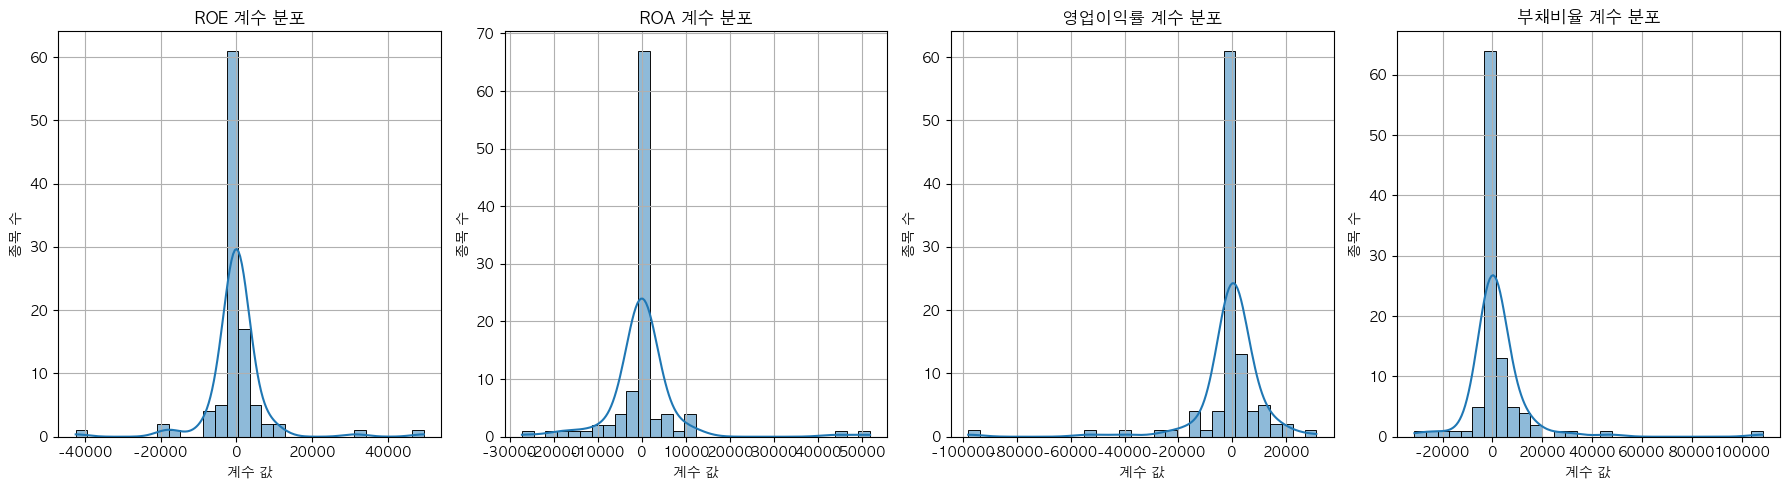


Í∞Å ÏßÄÌëúÎ≥Ñ ÌöåÍ∑Ä Í≥ÑÏàòÏùò ÌèâÍ∑† Î∞è ÌëúÏ§ÄÌé∏Ï∞®:
              ROE          ROA         ÏòÅÏóÖÏù¥ÏùµÎ•†          Î∂ÄÏ±ÑÎπÑÏú®
mean    22.654054   184.201797  -1029.906858   2425.118555
std   8382.932871  8702.487748  13879.785228  13899.943305

ROE Í≥ÑÏàòÍ∞Ä ÎÜíÏùÄ ÏÉÅÏúÑ 10Í∞ú Ï¢ÖÎ™©:
                   ROE           ROA         ÏòÅÏóÖÏù¥ÏùµÎ•†           Î∂ÄÏ±ÑÎπÑÏú®  \
Ï¢ÖÎ™©Î™Ö                                                                 
SKÌïòÏù¥ÎãâÏä§    49618.465766  43996.073742 -98122.370624  -24942.584229   
ÏóîÏºê        31544.817477  51741.130109  11451.503559  108397.194218   
ÏûêÎûåÌÖåÌÅ¨ÎÜÄÎ°úÏßÄ   10407.463668   9632.875986 -21958.584699    3546.285514   
ÌòÑÎåÄÏ∞®       10280.423253  10365.263892   5954.637839   -5533.558045   
Ï†úÏù¥Ïï§Ìã∞Ïî®      9201.160929  12096.966010 -12520.297743   -9632.714044   
Î†àÏù∏Î≥¥Ïö∞Î°úÎ≥¥Ìã±Ïä§   7950.930703  10701.775867 -25126.851016   11997.894720   
STXÏóîÏßÑ      6370.467563   6002.828179 -11979.362572    5701.364185  

In [164]:
# Í≥ÑÏàòÎì§Ïùò Î∂ÑÌè¨Î•º ÏãúÍ∞ÅÌôî (ÌûàÏä§ÌÜ†Í∑∏Îû®)
plt.figure(figsize=(18, 5)) # Í∑∏ÎûòÌîÑ ÌÅ¨Í∏∞ Ï°∞Ï†ï

for i, feature in enumerate(features):
    if feature in df_coefficients.columns: # Ìï¥Îãπ ÌäπÏßïÏùò Í≥ÑÏàò Ïª¨ÎüºÏù¥ Ï°¥Ïû¨ÌïòÎäî Í≤ΩÏö∞ÏóêÎßå
        plt.subplot(1, len(features), i + 1)
        sns.histplot(df_coefficients[feature].dropna(), bins=30, kde=True)
        plt.title(f'{feature} Í≥ÑÏàò Î∂ÑÌè¨', fontsize=12)
        plt.xlabel('Í≥ÑÏàò Í∞í')
        plt.ylabel('Ï¢ÖÎ™© Ïàò')
        plt.grid(True)
    else:
        # Ìï¥Îãπ ÌäπÏßïÏùò Í≥ÑÏàò Ïª¨ÎüºÏù¥ ÏïÑÏòà ÏóÜÎäî Í≤ΩÏö∞ (Ïòà: Î™®Îì† Ï¢ÖÎ™©ÏóêÏÑú Ìï¥Îãπ Ïª¨ÎüºÏùò Í∞íÏù¥ ÎèôÏùºÌñàÍ±∞ÎÇò)
        plt.subplot(1, len(features), i + 1)
        plt.title(f'{feature} Í≥ÑÏàò Î∂ÑÌè¨ (Îç∞Ïù¥ÌÑ∞ Î∂ÄÏ°±)', fontsize=12)
        plt.text(0.5, 0.5, 'Í≥ÑÏàò Îç∞Ïù¥ÌÑ∞ ÏóÜÏùå', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
        plt.grid(True)


plt.tight_layout()
plt.show()

# Í∞Å ÏßÄÌëúÎ≥Ñ Í≥ÑÏàòÏùò ÌèâÍ∑† Î∞è ÌëúÏ§ÄÌé∏Ï∞® ÌôïÏù∏
print("\nÍ∞Å ÏßÄÌëúÎ≥Ñ ÌöåÍ∑Ä Í≥ÑÏàòÏùò ÌèâÍ∑† Î∞è ÌëúÏ§ÄÌé∏Ï∞®:")
print(df_coefficients[features].describe().loc[['mean', 'std']])

# ÌäπÏ†ï Í∏∞Ï§ÄÏóê Îî∞Îùº Í≥ÑÏàò Í∞í ÌôïÏù∏ (ÏòàÏãú: ROE Í≥ÑÏàòÍ∞Ä ÎÜíÏùÄ ÏÉÅÏúÑ 10Í∞ú Ï¢ÖÎ™©)
print("\nROE Í≥ÑÏàòÍ∞Ä ÎÜíÏùÄ ÏÉÅÏúÑ 10Í∞ú Ï¢ÖÎ™©:")
print(df_coefficients.sort_values(by='ROE', ascending=False).head(10))

print("\nÏòÅÏóÖÏù¥ÏùµÎ•† Í≥ÑÏàòÍ∞Ä ÎÇÆÏùÄ (ÏùåÏùò ÏòÅÌñ•Î†•Ïù¥ ÌÅ∞) ÌïòÏúÑ 10Í∞ú Ï¢ÖÎ™©:")
print(df_coefficients.sort_values(by='ÏòÅÏóÖÏù¥ÏùµÎ•†', ascending=True).head(10))

In [306]:
analysis_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 938 entries, 0 to 937
Columns: 246 entries, Ï¢ÖÎ™©Î™Ö to 20241230
dtypes: float64(244), object(2)
memory usage: 1.8+ MB


In [304]:
analysis_df['Íµ¨Î∂Ñ'].unique()

array(['Ï¢ÖÍ∞Ä', 'PER', 'PBR', 'ROE', 'ROA', 'ÏòÅÏóÖÏù¥ÏùµÎ•†', 'Î∂ÄÏ±ÑÎπÑÏú®'], dtype=object)

In [168]:
analysis_df

Ï¢ÖÎ™©Î™Ö     Íµ¨Î∂Ñ       20240102       20240103       20240104  \
0    HDÌïúÍµ≠Ï°∞ÏÑ†Ìï¥Ïñë     Ï¢ÖÍ∞Ä  118500.000000  113500.000000  112000.000000   
1    HDÌïúÍµ≠Ï°∞ÏÑ†Ìï¥Ïñë    PER      27.820270      26.646419      26.294264   
2    HDÌïúÍµ≠Ï°∞ÏÑ†Ìï¥Ïñë    PBR       0.727399       0.696707       0.687499   
3    HDÌïúÍµ≠Ï°∞ÏÑ†Ìï¥Ïñë    ROE       2.614635       2.614635       2.614635   
4    HDÌïúÍµ≠Ï°∞ÏÑ†Ìï¥Ïñë    ROA       2.560307       2.560307       2.560307   
..        ...    ...            ...            ...            ...   
716      Í∏àÌò∏Ï†ÑÍ∏∞    PBR       8.791947       8.760169       8.728391   
717      Í∏àÌò∏Ï†ÑÍ∏∞    ROE    -297.906540    -297.906540    -297.906540   
718      Í∏àÌò∏Ï†ÑÍ∏∞    ROA     -36.354011     -36.354011     -36.354011   
719      Í∏àÌò∏Ï†ÑÍ∏∞  ÏòÅÏóÖÏù¥ÏùµÎ•†     -10.157383     -10.157383     -10.157383   
720      Í∏àÌò∏Ï†ÑÍ∏∞   Î∂ÄÏ±ÑÎπÑÏú®     719.459896     719.459896     719.459896   

          20240105       20240108       20240109       20240110  \
0    110700.000000  111900.000000  110700.000000  110900.000000   
1        25.989063      26.270787      25.989063      26.036017   
2         0.679519       0.686885       0.679519       0.680747   
3         2.614635       2.614635       2.614635       2.614635   
4         2.560307       2.560307       2.560307       2.560307   
..             ...            ...            ...            ...   
716       8.791947       8.728391       8.728391       8.760169   
717    -297.906540    -297.906540    -297.906540    -297.906540   
718     -36.354011     -36.354011     -36.354011     -36.354011   
719     -10.157383     -10.157383     -10.157383     -10.157383   
720     719.459896     719.459896     719.459896     719.459896   

          20240111  ...       20241216       20241217       20241218  \
0    108600.000000  ...  207500.000000  208500.000000  209500.000000   
1        25.496045  ...    1638.942580    1646.841098    1654.739617   
2         0.666629  ...       1.260073       1.266146       1.272219   
3         2.614635  ...       0.076883       0.076883       0.076883   
4         2.560307  ...       0.075148       0.075148       0.075148   
..             ...  ...            ...            ...            ...   
716       8.728391  ...       8.606987       8.585496       8.488788   
717    -297.906540  ...     -18.219323     -18.219323     -18.219323   
718     -36.354011  ...      -2.717013      -2.717013      -2.717013   
719     -10.157383  ...      -7.314557      -7.314557      -7.314557   
720     719.459896  ...     570.564368     570.564368     570.564368   

          20241219       20241220       20241223       20241224  \
0    214500.000000  212500.000000  230000.000000  226000.000000   
1      1694.232209    1678.435172    1816.659245    1785.065171   
2         1.302582       1.290437       1.396708       1.372417   
3         0.076883       0.076883       0.076883       0.076883   
4         0.075148       0.075148       0.075148       0.075148   
..             ...            ...            ...            ...   
716       8.499534       8.574751       8.714440       8.585496   
717     -18.219323     -18.219323     -18.219323     -18.219323   
718      -2.717013      -2.717013      -2.717013      -2.717013   
719      -7.314557      -7.314557      -7.314557      -7.314557   
720     570.564368     570.564368     570.564368     570.564368   

          20241226       20241227       20241230  
0    235500.000000  231000.000000  228000.000000  
1      1860.101097    1824.557764    1800.862208  
2         1.430107       1.402780       1.384563  
3         0.076883       0.076883       0.076883  
4         0.075148       0.075148       0.075148  
..             ...            ...            ...  
716       8.692949       9.638536      10.100584  
717     -18.219323     -18.219323     -18.219323  
718      -2.717013      -2.717013      -2.717013  
719      -7.314557      -7.314557      -7.314557  
720     570.5

# =================================================================

In [300]:
def meaningful_correlation_analysis(analysis_df):
    """ÏùòÎØ∏ÏûàÎäî ÏÉÅÍ¥ÄÍ¥ÄÍ≥Ñ Î∂ÑÏÑù (PER, PBR Ï†úÏô∏)"""
    
    results = []
    companies = analysis_df['Ï¢ÖÎ™©Î™Ö'].unique()
    
    for company in companies:
        try:
            company_data = analysis_df[analysis_df['Ï¢ÖÎ™©Î™Ö'] == company]
            
            # Íµ¨Î∂ÑÎ≥ÑÎ°ú ÎîïÏÖîÎÑàÎ¶¨ ÎßåÎì§Í∏∞
            metrics_dict = {}
            for _, row in company_data.iterrows():
                metric = row['Íµ¨Î∂Ñ']
                values = []
                for col in row.index[2:]:
                    if pd.notna(row[col]):
                        values.append(float(row[col]))
                
                if len(values) > 0:
                    metrics_dict[metric] = values
            
            if 'Ï¢ÖÍ∞Ä' in metrics_dict and len(metrics_dict) > 1:
                stock_prices = metrics_dict['Ï¢ÖÍ∞Ä']
                correlations = {'Ï¢ÖÎ™©Î™Ö': company, 'Îç∞Ïù¥ÌÑ∞Ïàò': len(stock_prices)}
                
                # PER, PBR Ï†úÏô∏ÌïòÍ≥† Î∂ÑÏÑù
                exclude_metrics = ['Ï¢ÖÍ∞Ä', 'PER', 'PBR']
                
                for metric, values in metrics_dict.items():
                    if (metric not in exclude_metrics and 
                        len(values) == len(stock_prices)):
                        
                        # Í∞íÏù¥ Î™®Îëê Í∞ôÏúºÎ©¥ Ïä§ÌÇµ (ÏÉÅÏàò Ï≤¥ÌÅ¨)
                        if len(set(values)) > 1:  # ÏÑúÎ°ú Îã§Î•∏ Í∞íÏù¥ ÏûàÏùÑ ÎïåÎßå
                            corr = pd.Series(stock_prices).corr(pd.Series(values))
                            correlations[metric] = corr
                        else:
                            correlations[metric] = 0.0  # ÏÉÅÏàòÎ©¥ ÏÉÅÍ¥ÄÍ¥ÄÍ≥Ñ 0
                
                results.append(correlations)
                
        except Exception as e:
            continue
    
    return pd.DataFrame(results)

# Ïã§Ìñâ
meaningful_results = meaningful_correlation_analysis(analysis_df)
print(meaningful_results.head())

       Ï¢ÖÎ™©Î™Ö  Îç∞Ïù¥ÌÑ∞Ïàò       ROE       ROA     ÏòÅÏóÖÏù¥ÏùµÎ•†      Î∂ÄÏ±ÑÎπÑÏú®
0  Ï†úÏù¥Ïä§ÏΩîÌôÄÎî©Ïä§   244  0.270580  0.253226 -0.440476 -0.202563
1   ÌÄÄÌÉÄÎß§Ìä∏Î¶≠Ïä§   244  0.377161  0.514529 -0.156500  0.381488
2     ÏÇºÏùµÏïÖÍ∏∞   244  0.131611  0.126966  0.027908  0.461236
3     ÎÇòÎÖ∏ÏóîÌÖç   244 -0.176444 -0.176193 -0.270843 -0.013277
4       ÎèôÎ∞©   244  0.439246  0.454988 -0.250219 -0.413954


In [301]:
meaningful_results

Ï¢ÖÎ™©Î™Ö  Îç∞Ïù¥ÌÑ∞Ïàò       ROE       ROA     ÏòÅÏóÖÏù¥ÏùµÎ•†      Î∂ÄÏ±ÑÎπÑÏú®
0      Ï†úÏù¥Ïä§ÏΩîÌôÄÎî©Ïä§   244  0.270580  0.253226 -0.440476 -0.202563
1       ÌÄÄÌÉÄÎß§Ìä∏Î¶≠Ïä§   244  0.377161  0.514529 -0.156500  0.381488
2         ÏÇºÏùµÏïÖÍ∏∞   244  0.131611  0.126966  0.027908  0.461236
3         ÎÇòÎÖ∏ÏóîÌÖç   244 -0.176444 -0.176193 -0.270843 -0.013277
4           ÎèôÎ∞©   244  0.439246  0.454988 -0.250219 -0.413954
..         ...   ...       ...       ...       ...       ...
129  HDCÌòÑÎåÄÏÇ∞ÏóÖÍ∞úÎ∞ú   244 -0.482019 -0.499811  0.612235  0.507965
130    HLBÏÉùÎ™ÖÍ≥ºÌïô   244  0.000000  0.000000 -0.089372  0.731293
131       ÌïúÍµ≠ÏΩúÎßà   244  0.900728  0.894434  0.556081  0.308976
132   ÏóêÏä§ÎîîÎ∞îÏù¥Ïò§ÏÑºÏÑú   244 -0.475579 -0.475409       NaN  0.387196
133    DGBÍ∏àÏúµÏßÄÏ£º   244  0.382986  0.381847       NaN -0.418849

[134 rows x 6 columns]

In [307]:
analysis_df

Ï¢ÖÎ™©Î™Ö     Íµ¨Î∂Ñ     20240102     20240103     20240104     20240105  \
0    Ï†úÏù¥Ïä§ÏΩîÌôÄÎî©Ïä§     Ï¢ÖÍ∞Ä  1430.000000  1477.000000  1408.000000  1401.000000   
1    Ï†úÏù¥Ïä§ÏΩîÌôÄÎî©Ïä§    PER          NaN          NaN          NaN          NaN   
2    Ï†úÏù¥Ïä§ÏΩîÌôÄÎî©Ïä§    PBR     1.400996     1.447042     1.379442     1.372584   
3    Ï†úÏù¥Ïä§ÏΩîÌôÄÎî©Ïä§    ROE   -38.864932   -38.864932   -38.864932   -38.864932   
4    Ï†úÏù¥Ïä§ÏΩîÌôÄÎî©Ïä§    ROA   -19.087926   -19.087926   -19.087926   -19.087926   
..       ...    ...          ...          ...          ...          ...   
933  DGBÍ∏àÏúµÏßÄÏ£º    PBR     0.420864     0.420864     0.414858     0.407352   
934  DGBÍ∏àÏúµÏßÄÏ£º    ROE     5.416470     5.416470     5.416470     5.416470   
935  DGBÍ∏àÏúµÏßÄÏ£º    ROA     4.086800     4.086800     4.086800     4.086800   
936  DGBÍ∏àÏúµÏßÄÏ£º  ÏòÅÏóÖÏù¥ÏùµÎ•†          NaN          NaN          NaN          NaN   
937  DGBÍ∏àÏúµÏßÄÏ£º   Î∂ÄÏ±ÑÎπÑÏú®    32.535720    32.535720    32.535720    32.535720   

        20240108     20240109     20240110     20240111  ...     20241216  \
0    1414.000000  1425.000000  1460.000000  1469.000000  ...  1854.000000   
1            NaN          NaN          NaN          NaN  ...          NaN   
2       1.385320     1.396097     1.430387     1.439205  ...     1.777508   
3     -38.864932   -38.864932   -38.864932   -38.864932  ...   -13.082513   
4     -19.087926   -19.087926   -19.087926   -19.087926  ...    -6.709918   
..           ...          ...          ...          ...  ...          ...   
933     0.404349     0.407852     0.412356     0.412356  ...     0.443487   
934     5.416470     5.416470     5.416470     5.416470  ...    -1.397186   
935     4.086800     4.086800     4.086800     4.086800  ...    -1.046711   
936          NaN          NaN          NaN          NaN  ...          NaN   
937    32.535720    32.535720    32.535720    32.535720  ...    33.483395   

        20241217     20241218     20241219     20241220     20241223  \
0    1871.000000  1825.000000  1847.000000  1744.000000  1725.000000   
1            NaN          NaN          NaN          NaN          NaN   
2       1.793806     1.749704     1.770796     1.672046     1.653830   
3     -13.082513   -13.082513   -13.082513   -13.082513   -13.082513   
4      -6.709918    -6.709918    -6.709918    -6.709918    -6.709918   
..           ...          ...          ...          ...          ...   
933     0.425199     0.431295     0.427231     0.417579     0.428755   
934    -1.397186    -1.397186    -1.397186    -1.397186    -1.397186   
935    -1.046711    -1.046711    -1.046711    -1.046711    -1.046711   
936          NaN          NaN          NaN          NaN          NaN   
937    33.483395    33.483395    33.483395    33.483395    33.483395   

        20241224     20241226     20241227     20241230  
0    1739.000000  1702.000000  1626.000000  1693.000000  
1            NaN          NaN          NaN          NaN  
2       1.667252     1.631779     1.558914     1.623150  
3     -13.082513   -13.082513   -13.082513   -13.082513  
4      -6.709918    -6.709918    -6.709918    -6.709918  
..           ...          ...          ...          ...  
933     0.429263     0.428755     0.422659     0.415547  
934    -1.397186    -1.397186    -1.397186    -1.397186  
935    -1.046711    -1.046711    -1.046711    -1.046711  
936          NaN          NaN          NaN          NaN  
937    33.483395    33.483395    33.483395    33.483395  

[938 rows x 246 columns]